# **Proyecto de Ciencia de Datos Aplicada 2025-20**


En este notebook se realiza la exploración y limpieza de los datos, con el fin de ser usados posteriormente en análisis estádisticos.

# **0. Ambiente de trabajo**
Importar las librerías necesarias y definir las rutas de los archivos a utilizar.

### Librerias

In [2183]:
import pandas as pd
import numpy as np
import json

# visualizacion
import matplotlib.pyplot as plt
import seaborn as sns


### Archivos usados en este notebook

In [2184]:
EXCEL_PATH = "../data/Base infecciones POPTH.xlsx"
CODEBOOK_PATH = "../data/new_codebook.json"
CLEAN_DB = "../data/Base_infecciones_POPTH_limpia.csv"
CLEAN_DB_XLSX = "../data/Base_infecciones_POPTH_limpia.xlsx"

In [2185]:
NO_APLICA = np.nan
GENERAL_MISSING = np.nan

### Funciones auxiliares

In [2186]:
from matplotlib.patches import Patch

df_codebook = pd.read_json(CODEBOOK_PATH)

def graficar_var_categorica(df, columna, nombre_columna=None, show_legend=False, include_na=False, ordinal=True):
    """
    Grafica barras de una variable categórica con porcentajes sobre cada barra.
    - Si 'ordinal' es True, ordena las categorías en orden ascendente. Si es False, ordena por frecuencia descendente.
    - Opcional: incluye NaN como categoría.
    """
    nombre_columna = nombre_columna or columna

    if columna not in df_codebook.index:
        show_legend = False  # desactivar leyenda si no hay encoding
    else:
        encoding = df_codebook.loc[columna, "Choices"]

    # Preparar datos (opcionalmente incluir NaN como categoría visible)
    serie = df[columna]
    if include_na:
        serie = serie.fillna("NA")

    # Determinar el orden de las categorías
    if ordinal:
        # Orden ascendente para ordinales
        counts = serie.value_counts().sort_index()
    else:
        # Orden descendente por frecuencia para nominales
        counts = serie.value_counts(ascending=False)

    order = counts.index.tolist()
    percentages = (counts / counts.sum() * 100).values
    print(f"Orden de categorías para '{columna}': {order}")

    # Paleta
    #pastel = sns.color_palette("pastel") + sns.color_palette("bright")
    #n = len(order) if order is not None else serie.nunique(dropna=False)
    #pastel = pastel[:n]

    n = len(order)
    pal = sns.husl_palette(n)  # n colores distintos, sin warnings

    # Gráfico
    plt.figure(figsize=(15, 6))
    ax = sns.countplot(data=serie.to_frame(), x=columna, order=order, palette=pal, hue=columna, legend=False)
    ax.set_title(f"Distribución por {nombre_columna}")
    ax.set_xlabel(nombre_columna)
    ax.set_ylabel("Frecuencia")

    # Anotar porcentajes - usar las barras en el orden correcto
    for i, patch in enumerate(ax.patches):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        pct = percentages[i]
        ax.annotate(f"{pct:.1f}%", (x, y), ha='center', va='bottom', fontsize=10, fontweight="bold")

    # Estética
    plt.xticks(rotation=45)
    plt.tight_layout()


    # ----------- LEYENDA PERSONALIZADA: "#_descripción" -----------

    if show_legend:
        # normaliza claves del encoding a str para evitar mismatches int/str
        encoding_str = {str(k): v for k, v in encoding.items()}

        def fmt_label(code):
            key = str(code)
            # intento de casteo si vienen como '1.0' etc.
            if key not in encoding_str:
                try:
                    key = str(int(float(key)))
                except:
                    pass
            desc = encoding_str.get(key, "No especificado")
            return f"{code}: {desc}"

        handles = [Patch(facecolor=pal[i], label=fmt_label(code)) for i, code in enumerate(sorted(order))]

        # leyenda fuera del gráfico, a la derecha
        ax.legend(
            handles=handles,
            title=nombre_columna,
            loc="upper left",
            bbox_to_anchor=(1.02, 1.0),   # fuera del eje
            frameon=False,
            borderaxespad=0.0
        )

    # deja espacio para la leyenda externa
    plt.tight_layout()
    plt.subplots_adjust(right=0.78)  # ajusta este valor si la leyenda se corta
    plt.show()


#graficar_var_categorica(df_clean, "Etiología_#1", show_legend=True, ordinal=False)


In [2187]:
def graficar_var_numerica(df, columna_a_graficar, nombre_columa = None):

    nombre_columa = nombre_columa if nombre_columa else columna_a_graficar

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    columna_stats = df[columna_a_graficar].describe()
    # Histograma con KDE
    sns.histplot(x = df[columna_a_graficar], bins=50, kde=True, ax=ax1, color='lightblue')
    ax1.set_title(f'Distribución de {columna_a_graficar}')
    ax1.set_xlabel(nombre_columa)
    ax1.set_ylabel('Frecuencia')
    ax1.axvline(int(columna_stats['mean']), color='red', linestyle='--', label=f'Media: {int(columna_stats["mean"])}')
    ax1.axvline(int(columna_stats['50%']), color='blue', linestyle='--', label=f'Mediana: {int(columna_stats["50%"])}')
    ax1.legend()

    # Boxplot horizontal
    sns.boxplot(x=df[columna_a_graficar], ax=ax2, color='lightgreen', showmeans=True)
    ax2.set_title(f'Box Plot de {columna_a_graficar}')
    ax2.set_xlabel(nombre_columa)
    ax2.set_ylabel('')

    plt.tight_layout()
    plt.show()

# **1. Entendimiento inicial**
Cargar los datos y realizar una exploración inicial para entender su estructura y contenido.

Se carga el dataset

In [2188]:
#df = pd.read_excel(EXCEL_PATH, sheet_name="Base de datos principal") #HOJA ORIGINAL
df = pd.read_excel(EXCEL_PATH, sheet_name="BD") #HOJA CON PRIMERA FILA BORRADA
# formatear el nombre de las columnas, algunas tienen espacios al inicio o final
df.columns = df.columns.str.strip()

Se revisan las dimensiones del dataset.

In [2189]:
print("Número de columnas(variables):", df.shape[1])
print("Número de filas (pacientes):", df.shape[0])

Número de columnas(variables): 60
Número de filas (pacientes): 557


Se listan los atributos (columnas) del dataset y sus tipos

In [2190]:
df.dtypes

#Paciente_Tx                                           int64
Año_Tx                                                 int64
Fecha_Tx                                      datetime64[ns]
Código anonimizado                                    object
Edad                                                   int64
Sexo                                                   int64
Etiología_#1                                           int64
Etiología_#2                                           int64
Child_Pugh_Score                                      object
Meld_Score                                            object
Diabetes_Mellitus                                     object
Tabaquismo                                            object
Alcoholismo                                           object
Hipertensión_Arterial                                float64
Peso_previo_Cx                                       float64
Talla                                                  int64
IMC                     

In [2191]:
# contar tipos de datos
df.dtypes.value_counts()

object            23
float64           22
int64             13
datetime64[ns]     2
Name: count, dtype: int64

Se muestran las primeras filas para entender la estructura de los datos

In [2192]:
df.tail()

,#Paciente_Tx,Año_Tx,Fecha_Tx,Código anonimizado,Edad,Sexo,Etiología_#1,Etiología_#2,Child_Pugh_Score,Meld_Score,...,Inmunosupresión_con_Anticuerpos,Inmunosupresor_1_1mesPostTx,Inmunosupresor_2_PostTx_1mesPx,Inmunosupresor_1_6mesesPostx,Inmunosupresor_2_6mesesPostTx,Vivo_Hoy,Fecha_Control/Muerte,SOBREVIDA_DIAS,SOBREVIDA_MESES,SOBREVIDA_AÑOS
552,553,2024,2024-09-21,P553,22,1,12,0,11,22,...,0.0,2.0,1.0,2.0,1.0,1,2024-09-21,0,0.0,0.0
553,554,2024,2024-09-21,P554,33,2,8,0,10,21,...,NaN,NaN,NaN,NaN,NaN,0,2025-03-31,174,5.0,0.0
554,555,2024,2024-10-08,P555,55,1,3,4,9,20,...,0.0,2.0,1.0,2.0,1.0,1,2025-05-07,203,6.0,0.0
555,556,2024,2024-10-16,P556,54,2,27,0,9,14,...,0.0,2.0,1.0,2.0,0.0,1,2025-05-13,196,6.0,0.0
556,557,2024,2024-10-29,P557,63,1,4,0,9,18,...,0.0,2.0,1.0,2.0,1.0,1,2025-05-13,45772,1503.0,125.0


# **2. Análisis de calidad y preparación de datos**

Dimensiones de calidad:
1. Completitud: Valores nulos​
2. Unicidad: Detectar valores duplicados
3. Consistencia: Validación de los tipos de datos

In [2193]:
#Revisamos valores nulos sobre todo el dataset
display(df.isna().sum().sort_values(ascending=False))
numero_filas_con_nulos = df.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor nulo: {numero_filas_con_nulos}, lo que representa el {numero_filas_con_nulos / df.shape[0] * 100:.2f}% del total de filas.")


Localización de la infección                  479
Germen/Microorganismo aislado                 479
Fecha_Egreso_UCI                              429
Fecha_Egreso_Hospitalario                     369
Antibiotico_previo_al_Tx                      300
Tiempo_Isquemia_Fria                          178
Tiempo_Isquemia_caliente                      136
Hipertensión_Arterial                         127
Inmunosupresor_2_6mesesPostTx                  11
Inmunosupresor_1_6mesesPostx                   11
Inmunosupresor_1_1mesPostTx                     8
Inmunosupresor_2_PostTx_1mesPx                  8
Inmunosupresión_con_Anticuerpos                 7
Complicaciones_Técnicas                         5
Requerimiento_de_diálisis                       4
Días_Nutrición_Enteral                          4
Trasfusión_GRE_hasta_1m_POP                     4
Reintervención_Quirúrgica_hasta_1m_POP          4
Nutrición_Enteral                               3
Tiempo_De_Dosis_Hasta_Tx#1                      3


Número de filas con al menos un valor nulo: 555, lo que representa el 99.64% del total de filas.


In [2194]:
# Revisamos duplicados sobre todo el dataset
num_duplicados = df.duplicated().sum()
print(f"Número de duplicados: {num_duplicados} (%{num_duplicados/len(df)*100:.2f})")

Número de duplicados: 0 (%0.00)


# **3. Análisis univariado**

In [2195]:
df_clean = df.copy()

## Grupo 1 — Caracterización preoperatoria y comorbilidades (baseline)

Las variables inmersas dentro este grupo son:

In [2196]:
demograficas = ["Edad", "Sexo", "Etiología_#1", "Etiología_#2", "Child_Pugh_Score", "Meld_Score", "Diabetes_Mellitus", "Tabaquismo", "Alcoholismo", "Hipertensión_Arterial", "Peso_previo_Cx", "Talla", "IMC", "Antecedente_UCI_6_meses_PreOP", "UCI_al_Momento_Tx"]



**Edad**: Se refiere a la edad del paciente. Es una variable numérica discreta.

**Sexo**: Se refiere al sexo del paciente. En el data se evidencia como una variable numérica como valores (1 o 2), pero se tratará como una variable categórica.

Posteriormente, encontramos 2 variables referentes a Etiología: **Etiología_#1** y **Etiología_#2**. Estas refieren a posibles causas de la enfermedad del paciente. Ambas son de caracter numérico discreto, con valores entre 0 y 25. Se tratará como variable categórica ya que cada una refiere al código de una causa.

**Child_Pugh_Score**: Esta variable refiere al resultado del modelo Child_Pugh, el cual puede tener valor entre 5 y 15. De acuerdo con la universidad Francisco Marroquin (n.d), esta prueba se utiliza actualmente para pronosticar expectativa de vida de un paciente con daño hepático y que se encuentra en lista de espera para un transplante, lo genera en consecuencia un sentido de urgencia a la necesidad de un transplante de hígado. Ahora, esta prueba es el resultado de una puntación asignada a rangos de valores de mediciones en: Bilirrubina, Albúmina sérica, INR / Tiempo de protrombina, Ascitis y Encefalopatía hepática. Asimismo, la sumatoria de la puntación, o Child Pugh score, se puede clasificar en tres clases: A, B y C, para puntajes entre 5-6, 7-9 y 10-15; respectivamente. Un puntaje más bajo refiere una esperanza de supervivencia más alta en un periodo de 2 años.

| Clase | Rango de puntaje | Supervivencia a 1 año | Supervivencia a 2 años |
| ----- | ---------------- | --------------------: | ---------------------: |
| **A** | 5–6              |                 ~100% |                   ~85% |
| **B** | 7–9              |                  ~80% |                   ~60% |
| **C** | 10–15            |                  ~45% |                   ~35% |


**Meld_Score**:  El MELD (Model for End-Stage Liver Disease) es un puntaje que estima el riesgo de mortalidad a 90 días en pacientes con cirrosis/enfermedad hepática avanzada y guía la priorización para trasplante. Es un valor entre 6 y 40, que traduce la necesidad de un transplante de hígado, entre más alto sea el valor, mayor será la necesidad. Asimismo, existen rangos de valores los cuales tienen asociado una probabilidad de muerte en un periodo de 90 días: 6-9, 10-19, 20-29, 30-30, 40.

**Diabetes_Mellitus**: Una variable númerica, que refiere a 3 categorías. 1 Para Diabetes tipo 1, 2 para Diabetes tipo 2 y 0 para la ausencia de diabetes en el paciente.

**Tabaquismo**: Variable binaria que indica que si el paciente presenta tabaquismo: 1 si presenta, 0 de lo contrario.

**Alcoholismo**: Variable binaria que indica que si el paciente presenta alcoholismo: 1 si presenta, 0 de lo contrario.

**Hipertensión_Arterial**: Variable binaria que indica que si el paciente presenta hipertensión arterial: 1 si presenta, 0 de lo contrario.

**Peso_previo_Cx**: Variable numérica continua que indica el peso del paciente previo a la cirugía.

**Talla**: Variable numérica discreta que indica la altura en centímetros del paciente.

**IMC**: Variable numérica continua que indica el índice de masa corporal en del paciente. Esta variable se usa dentro de la literatura para clasificar el paciente según su peso.

**Antecedente_UCI_6_meses_PreOP**: Variable binaria que indica que si el paciente tiene antecendente de asistencia a UCI en los 6 últimos meses previos a la operación: 1 si presenta, 0 de lo contrario.

**UCI_al_Momento_Tx**: Variable binaria que indica que si el paciente tiene antecendente de asistencia a UCI en el tiempo de tratamiento: 1 si presenta, 0 de lo contrario.




In [2197]:
df[demograficas].isna().sum()

Edad                               0
Sexo                               0
Etiología_#1                       0
Etiología_#2                       0
Child_Pugh_Score                   0
Meld_Score                         1
Diabetes_Mellitus                  0
Tabaquismo                         0
Alcoholismo                        0
Hipertensión_Arterial            127
Peso_previo_Cx                     0
Talla                              0
IMC                                0
Antecedente_UCI_6_meses_PreOP      1
UCI_al_Momento_Tx                  1
dtype: int64

In [2198]:
df[demograficas].dtypes

Edad                               int64
Sexo                               int64
Etiología_#1                       int64
Etiología_#2                       int64
Child_Pugh_Score                  object
Meld_Score                        object
Diabetes_Mellitus                 object
Tabaquismo                        object
Alcoholismo                       object
Hipertensión_Arterial            float64
Peso_previo_Cx                   float64
Talla                              int64
IMC                              float64
Antecedente_UCI_6_meses_PreOP     object
UCI_al_Momento_Tx                float64
dtype: object

### ``Peso_previo_Cx``

Peso en Kilogramos

In [2199]:
df["Peso_previo_Cx"].value_counts(dropna=False)

Peso_previo_Cx
0.0      271
65.0      17
70.0      15
63.0      13
62.0      12
        ... 
65.6       1
91.0       1
160.0      1
8.8        1
98.0       1
Name: count, Length: 84, dtype: int64

In [2200]:
peso = df["Peso_previo_Cx"].copy()
# crear máscara para valores válidos, 0 Kg no tiene sentido
mask_valid = peso.between(1, 300)
# mapear a np.nan los valores inválidos
score_valid = peso.where(mask_valid, other=np.nan)
df_clean["Peso_previo_Cx"] = score_valid

### ``Talla``

Talla en cms

In [2201]:
df["Talla"].value_counts(dropna=False)

Talla
0      278
160     23
170     19
165     17
174     14
150     13
158     12
162     12
168     12
175     11
155     11
167     10
164      9
163      9
156      8
178      7
154      7
157      7
169      6
171      5
148      5
153      5
161      5
173      5
172      4
151      4
159      4
152      3
147      3
176      3
166      3
180      2
144      2
184      2
149      2
145      2
98       1
122      1
138      1
109      1
141      1
187      1
108      1
179      1
1        1
140      1
185      1
64       1
75       1
Name: count, dtype: int64

In [2202]:
talla = df["Talla"].copy()
# crear máscara para valores válidos, 0 cm no tiene sentido
mask_valid = talla.between(1, 272)
# mapear a np.nan los valores inválidos
score_valid = talla.where(mask_valid, other=np.nan)
df_clean["Talla"] = score_valid

### ``IMC``

In [2203]:
df["IMC"].value_counts(dropna=False)

IMC
0.00     287
26.22      4
24.22      4
29.40      4
25.39      3
        ... 
25.67      1
31.89      1
25.33      1
25.25      1
17.10      1
Name: count, Length: 222, dtype: int64

In [2204]:
imc_calculated = df_clean["Peso_previo_Cx"] / ( (df_clean["Talla"]/100) **2 )
# crear máscara para valores válidos, 0 cm no tiene sentido
mask_valid = imc_calculated.between(10, 80)
# mapear a np.nan los valores inválidos
imc_valid = imc_calculated.where(mask_valid, other=np.nan)
df_clean["IMC"] = imc_valid.round(2)

### ``Child_Pugh_Score``

In [2205]:
df["Child_Pugh_Score"].value_counts(dropna=False)

Child_Pugh_Score
2       209
3        85
1        81
9        33
8        31
7        22
9999     20
11       19
10       17
5        11
12       10
6         6
C         4
13        3
19        2
0         2
A         2
Name: count, dtype: int64

In [2206]:
score = df["Child_Pugh_Score"].astype(str).str.strip()
mask_cat = score.isin(['A', 'B', 'C'])

# Asegura numérico (por si hay strings)
score_num = pd.to_numeric(score, errors="coerce")
mask_valid = score_num.between(5, 15)
# mapear a -1 los valores inválidos
score_valid = score_num.where(mask_valid, other=np.nan)

# Crea categorías: A=5–6, B=7–9, C=10–15
labels = ["A", "B", "C"]
score_cat = pd.cut(score_valid , bins=[-np.inf, 6, 9, 15], labels=labels, include_lowest=True)
score_cat.loc[mask_cat] = score.loc[mask_cat]

df_clean.drop(columns=["Child_Pugh_Score", "Child_Pugh_Score_Cat"], inplace=True, errors='ignore')
df_clean.loc[:, "Child_Pugh_Score"] = score_valid.astype("Int16")
df_clean.loc[:, "Child_Pugh_Score_Cat"] = score_cat

In [2207]:
df_clean["Child_Pugh_Score"]

0      <NA>
1      <NA>
2      <NA>
3      <NA>
4      <NA>
       ... 
552      11
553      10
554       9
555       9
556       9
Name: Child_Pugh_Score, Length: 557, dtype: Int16

### ``Meld_Score``

In [2208]:
df["Meld_Score"].value_counts(dropna=False)

Meld_Score
22      114
14       42
11       40
12       38
15       30
13       29
10       27
17       24
16       23
9        21
20       19
9999     18
8        16
19       15
18       13
21       12
23       11
24       11
26        8
7         8
6         7
28        5
25        5
29        4
27        4
40        3
          3
30        3
33        1
35        1
NaN       1
32        1
Name: count, dtype: int64

In [2209]:
meld_score = df["Meld_Score"].astype(str).str.strip()
meld_score_num = pd.to_numeric(meld_score, errors="coerce")
meld_score_valid = meld_score_num.where(meld_score_num.between(6, 40), other=np.nan)
df_clean["Meld_Score"] = meld_score_valid.astype("Int16")

In [2210]:
df_clean["Meld_Score"].value_counts(dropna=False)

Meld_Score
22      114
14       42
11       40
12       38
15       30
13       29
10       27
17       24
16       23
<NA>     22
9        21
20       19
8        16
19       15
18       13
21       12
24       11
23       11
7         8
26        8
6         7
28        5
25        5
29        4
27        4
40        3
30        3
33        1
35        1
32        1
Name: count, dtype: Int64

### graficas var númericas

In [2211]:
num_vars = ["Edad","Child_Pugh_Score", "Meld_Score", "Peso_previo_Cx", "Talla", "IMC"]

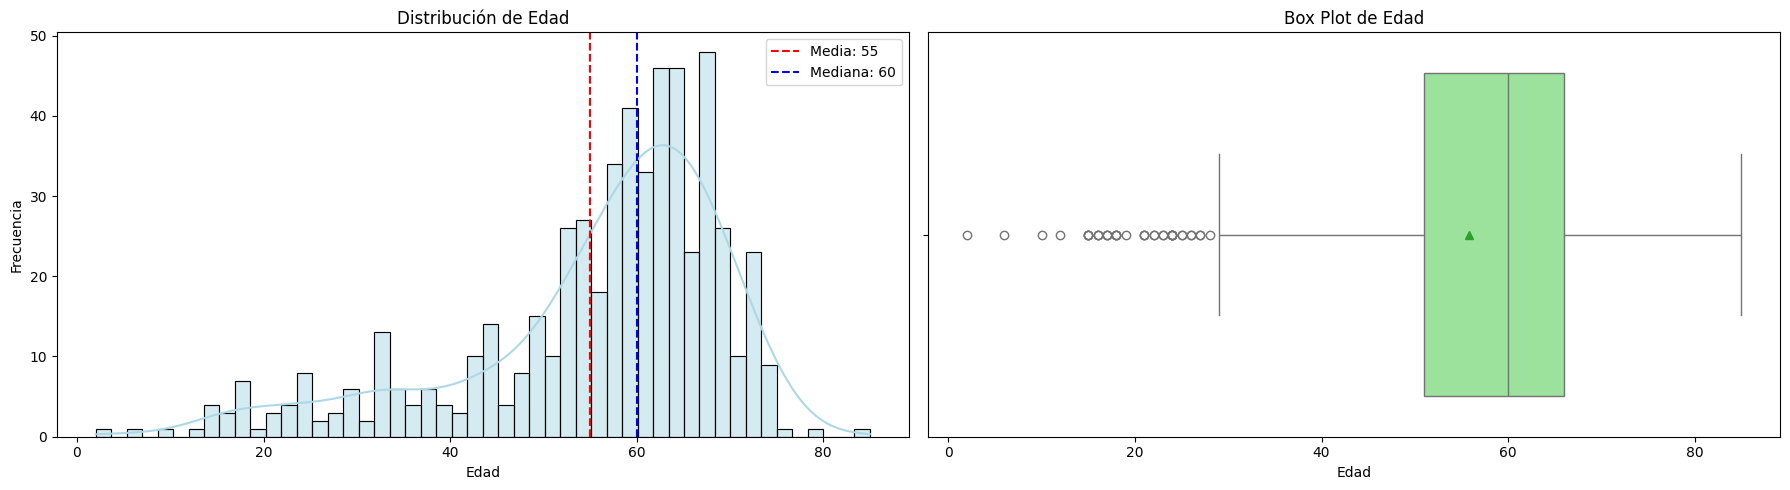

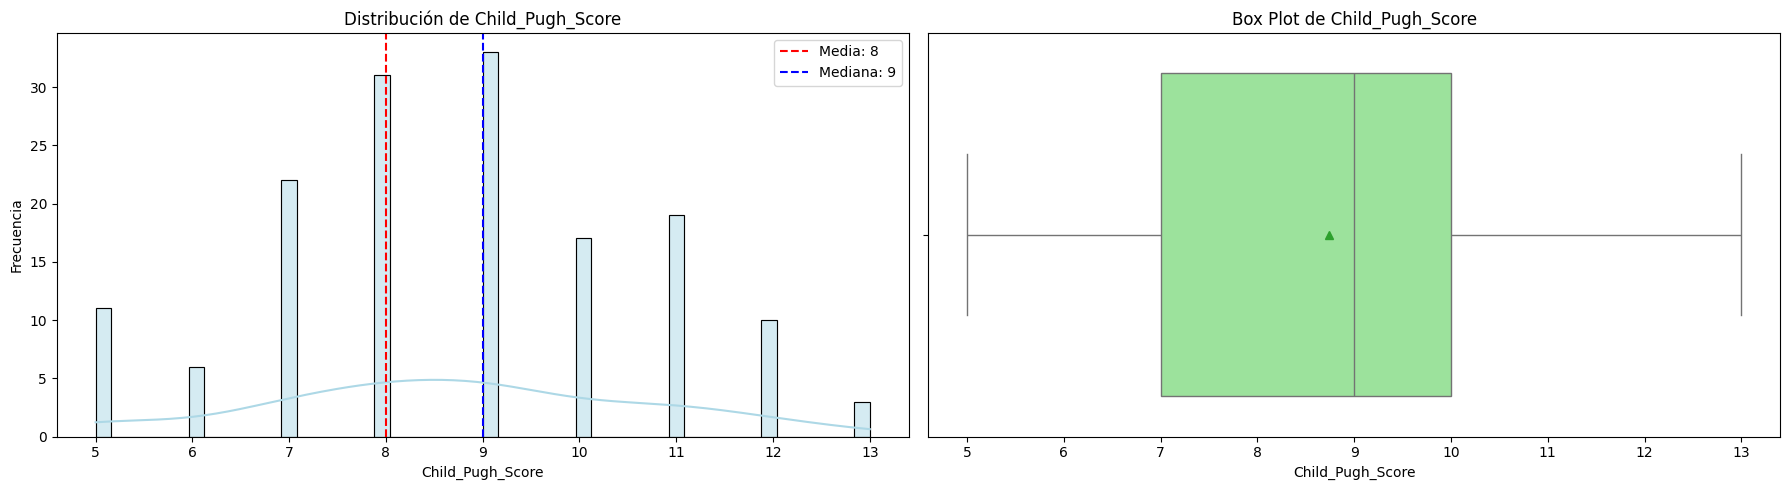

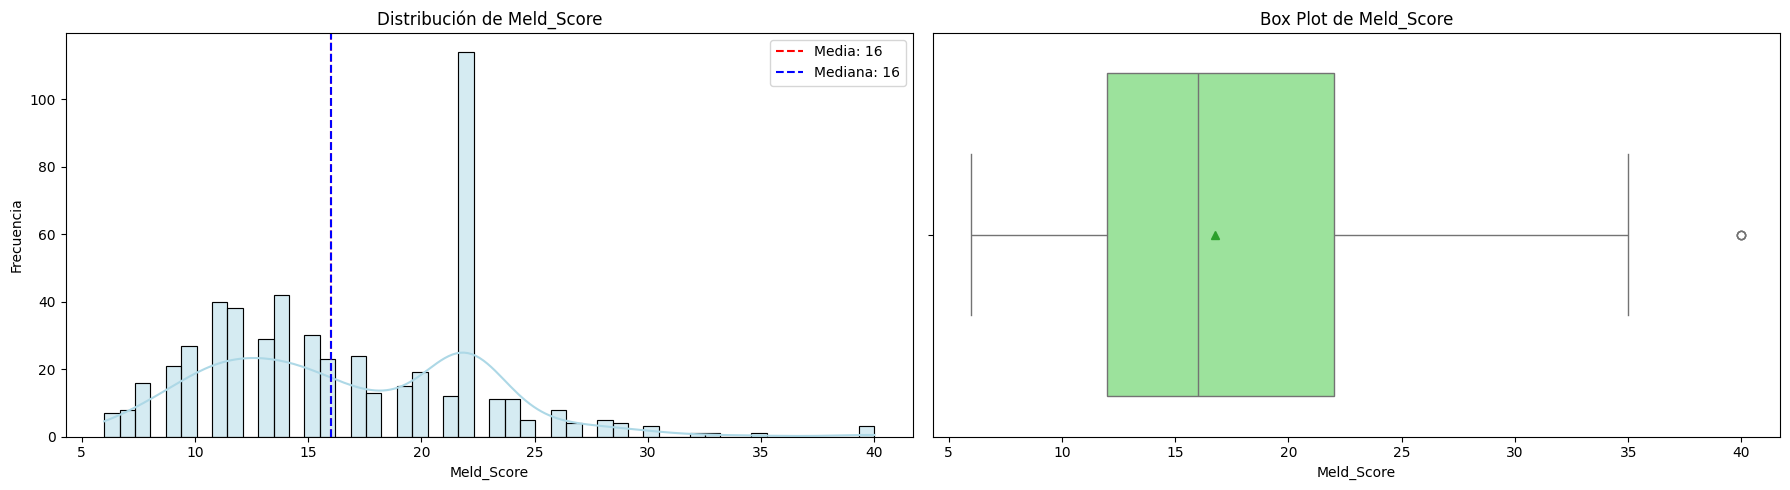

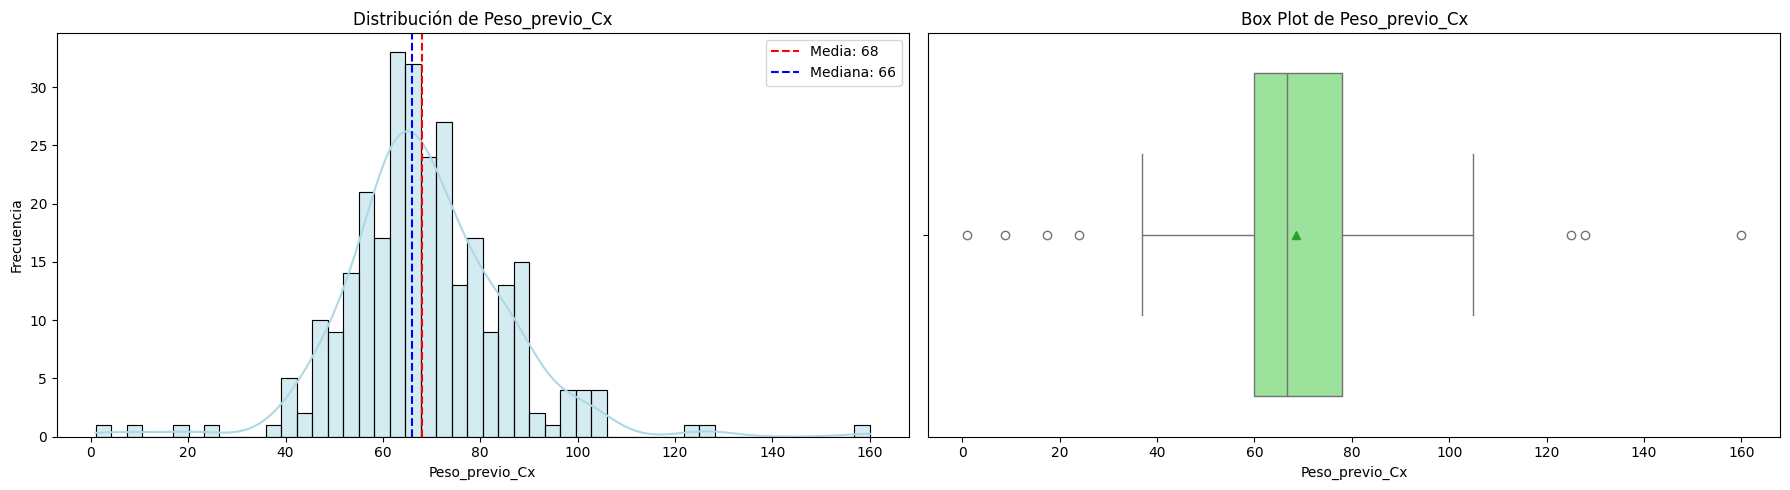

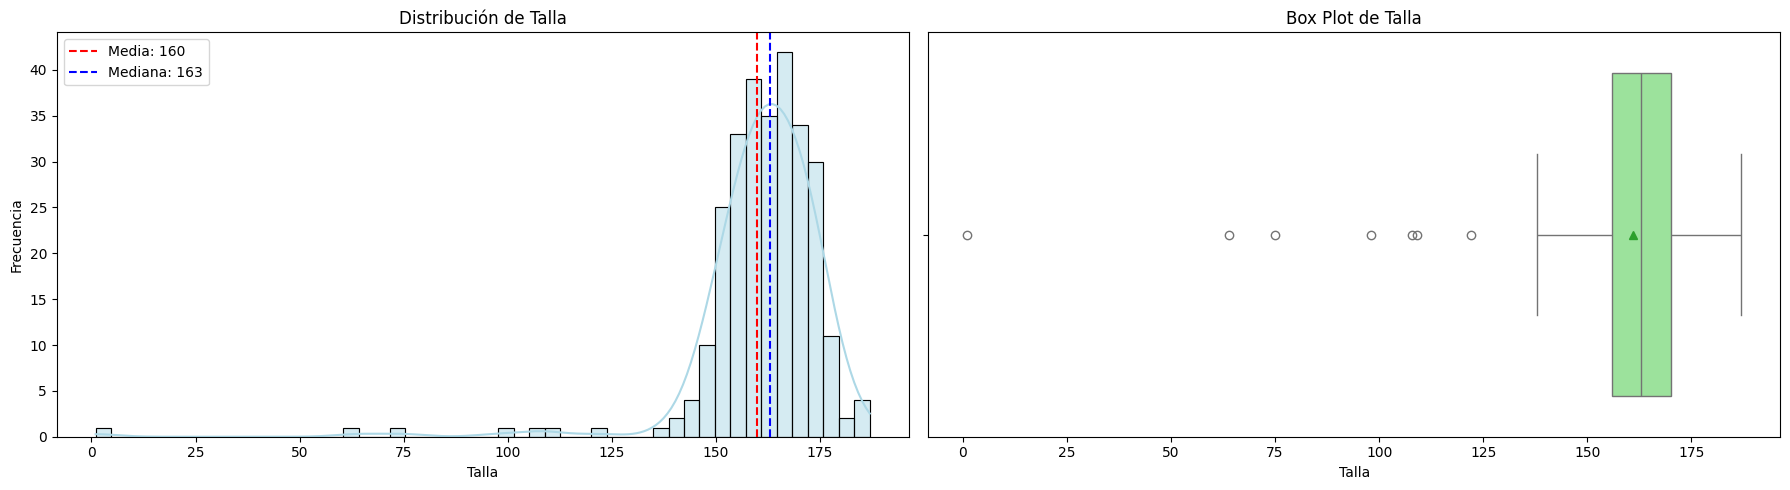

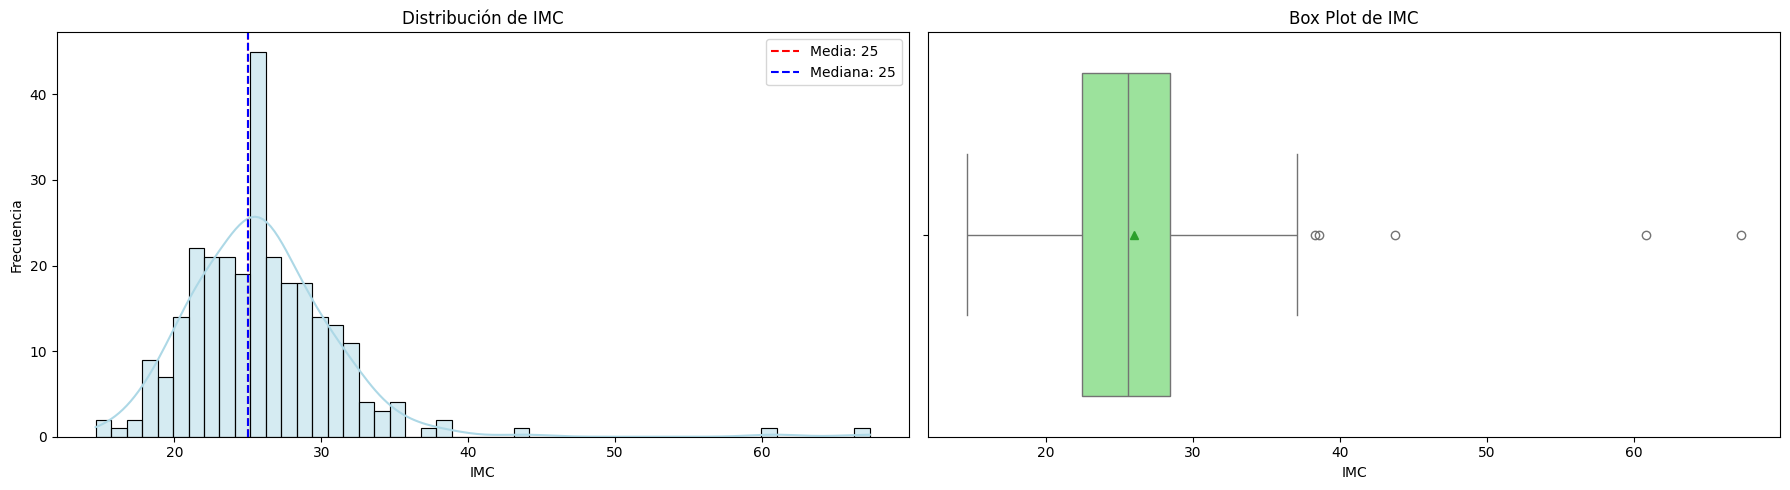

In [2212]:
for var in num_vars:
    try:
        graficar_var_numerica(df_clean, var)
    except Exception as e:
        print(f"Error al graficar {var}: {e}")

### ``Diabetes_Mellitus``

In [2213]:
df["Diabetes_Mellitus"].value_counts()

Diabetes_Mellitus
0       386
1       161
          5
9999      4
2         1
Name: count, dtype: int64

In [2214]:
esDiabetico = df["Diabetes_Mellitus"].copy()
mask_valid = esDiabetico.isin([0, 1])
esDiabetico[~mask_valid] = np.nan
df_clean["Diabetes_Mellitus"] = pd.to_numeric(esDiabetico, errors="coerce").astype('Int64')

### ``Tabaquismo``

In [2215]:
df["Tabaquismo"].value_counts(dropna=False)

Tabaquismo
0    382
1    170
       5
Name: count, dtype: int64

In [2216]:
esTabaquismo = df["Tabaquismo"].copy()
mask_valid = esTabaquismo.isin([0, 1])
esTabaquismo[~mask_valid] = np.nan
df_clean["Tabaquismo"] = pd.to_numeric(esTabaquismo, errors="coerce").astype('Int64')

In [2217]:
df_clean["Tabaquismo"].value_counts(dropna=False)

Tabaquismo
0       382
1       170
<NA>      5
Name: count, dtype: Int64

### ``Hipertensión_Arterial``

In [2218]:
df["Hipertensión_Arterial"].value_counts()

Hipertensión_Arterial
0.0    347
1.0     83
Name: count, dtype: int64

In [2219]:
df_clean["Hipertensión_Arterial"] = pd.to_numeric(df["Hipertensión_Arterial"], errors="coerce").astype('Int64')

### ``Alcoholismo``


In [2220]:
df["Alcoholismo"].value_counts()

Alcoholismo
0    359
1    193
       5
Name: count, dtype: int64

In [2221]:

df_clean["Alcoholismo"] = pd.to_numeric(df["Alcoholismo"], errors="coerce").astype('Int64')

### ``Antecedente_UCI_6_meses_PreOP``

In [2222]:
df["Antecedente_UCI_6_meses_PreOP"].value_counts()

Antecedente_UCI_6_meses_PreOP
0       447
1       103
9999      5
1*        1
Name: count, dtype: int64

In [2223]:
serie = df["Antecedente_UCI_6_meses_PreOP"].astype(str).str.strip()
mask_1 = df["Antecedente_UCI_6_meses_PreOP"].isin(["1*"])
serie[mask_1] = "1"
mask_valid = serie.isin(["0", "1"])
serie[~mask_valid] = np.nan
df_clean["Antecedente_UCI_6_meses_PreOP"] = pd.to_numeric(serie, errors="coerce").astype('Int64')

In [2224]:
df_clean["Antecedente_UCI_6_meses_PreOP"].value_counts(dropna=False)

Antecedente_UCI_6_meses_PreOP
0       447
1       104
<NA>      6
Name: count, dtype: Int64

### ``UCI_al_Momento_Tx``

In [2225]:
df["UCI_al_Momento_Tx"].value_counts()

UCI_al_Momento_Tx
0.0       511
1.0        43
9.0         1
9999.0      1
Name: count, dtype: int64

In [2226]:
esUCI = df["UCI_al_Momento_Tx"].copy()
mask_valid = esUCI.isin([0, 1])
esUCI[~mask_valid] = np.nan
df_clean["UCI_al_Momento_Tx"] = pd.to_numeric(esUCI, errors="coerce").astype('Int64')

### ``Etiología_#1``

In [2227]:
df_clean["Etiología_#1"].value_counts(dropna=False)

Etiología_#1
3     143
4      92
1      78
8      62
11     44
9      41
12     19
23     16
10     11
2      11
22     10
20      9
5       6
21      3
27      3
7       2
25      2
14      1
13      1
16      1
17      1
6       1
Name: count, dtype: int64

### graficas categoricas

In [2228]:
cat_vars = ["Sexo","Etiología_#1", "Etiología_#2","Diabetes_Mellitus", "Tabaquismo", "Alcoholismo", "Hipertensión_Arterial",  "Antecedente_UCI_6_meses_PreOP", "UCI_al_Momento_Tx"]

Orden de categorías para 'Sexo': [1, 2]


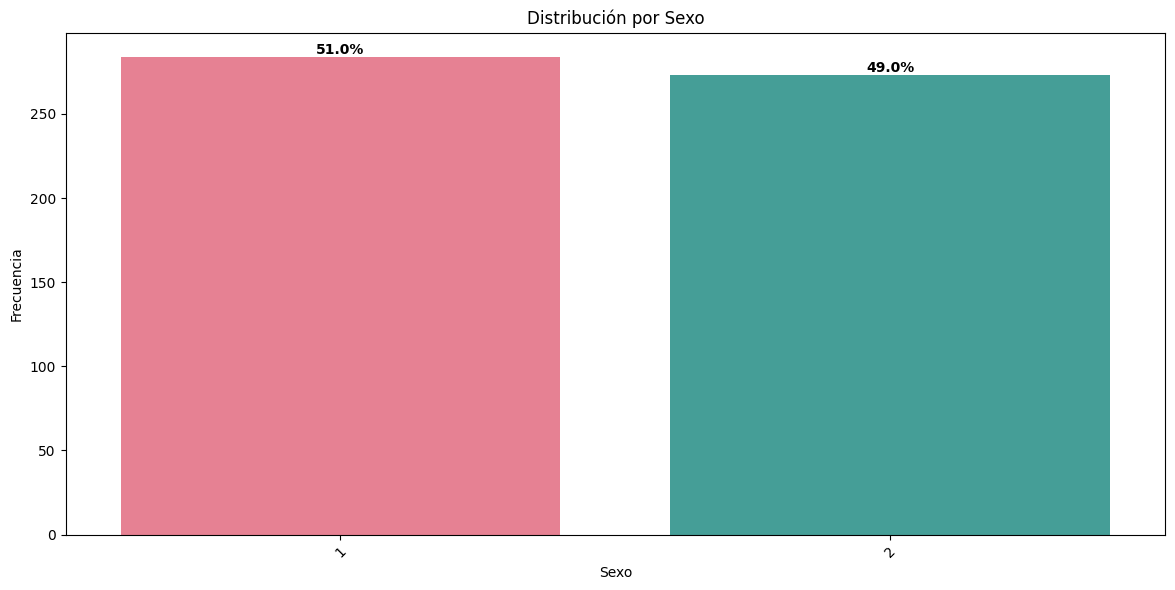

Orden de categorías para 'Etiología_#1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 25, 27]


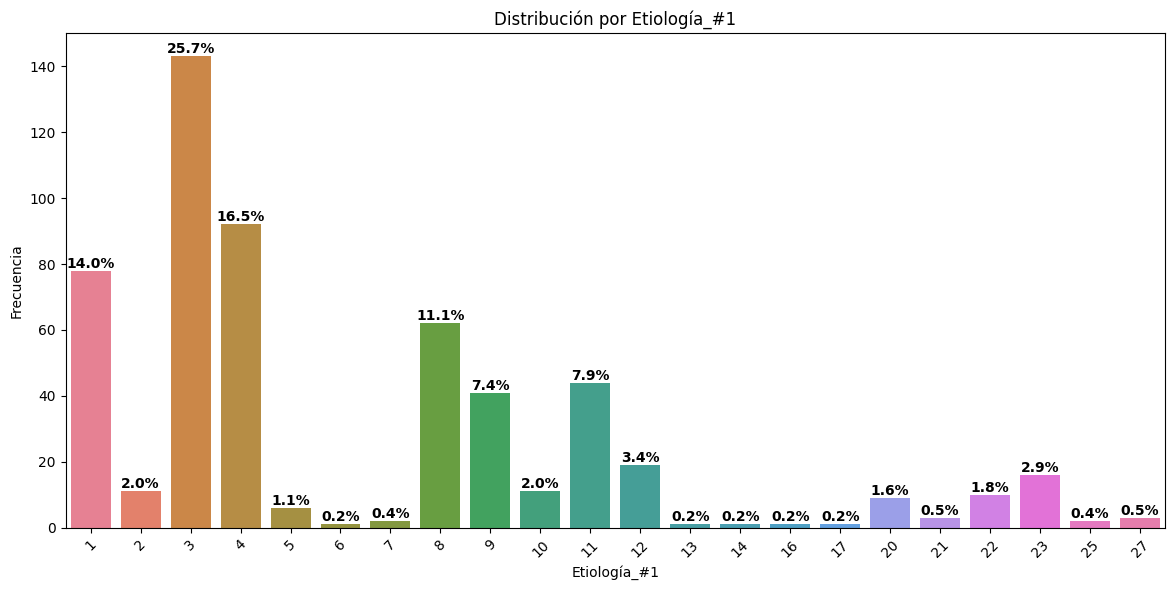

Orden de categorías para 'Etiología_#2': [0, 2, 3, 4, 5, 8, 9, 10, 21, 25]


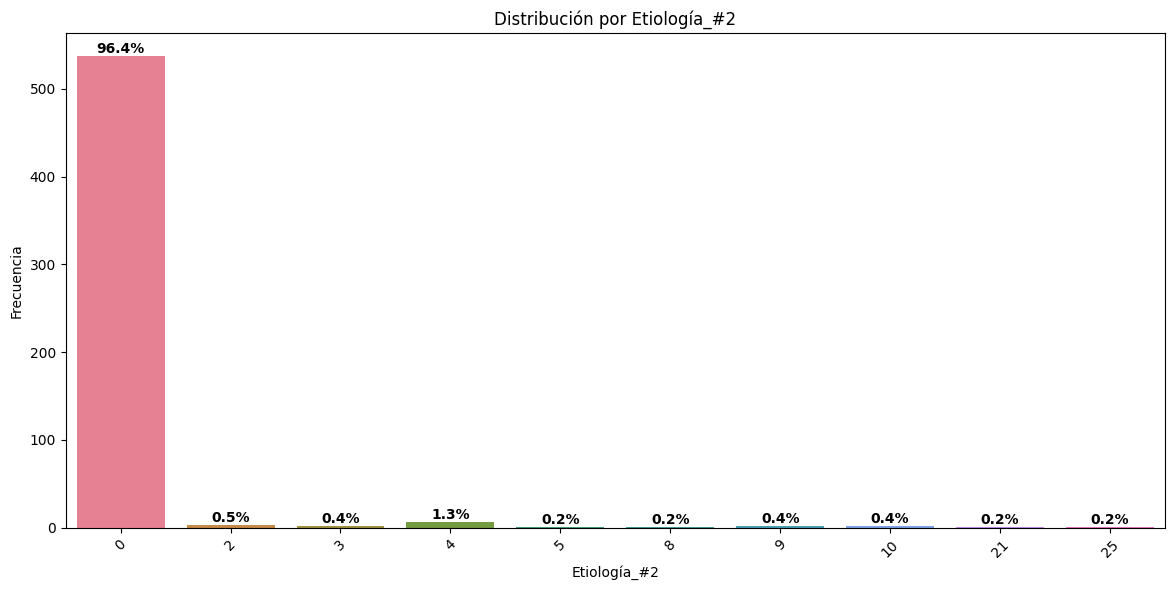

Orden de categorías para 'Diabetes_Mellitus': [0, 1]


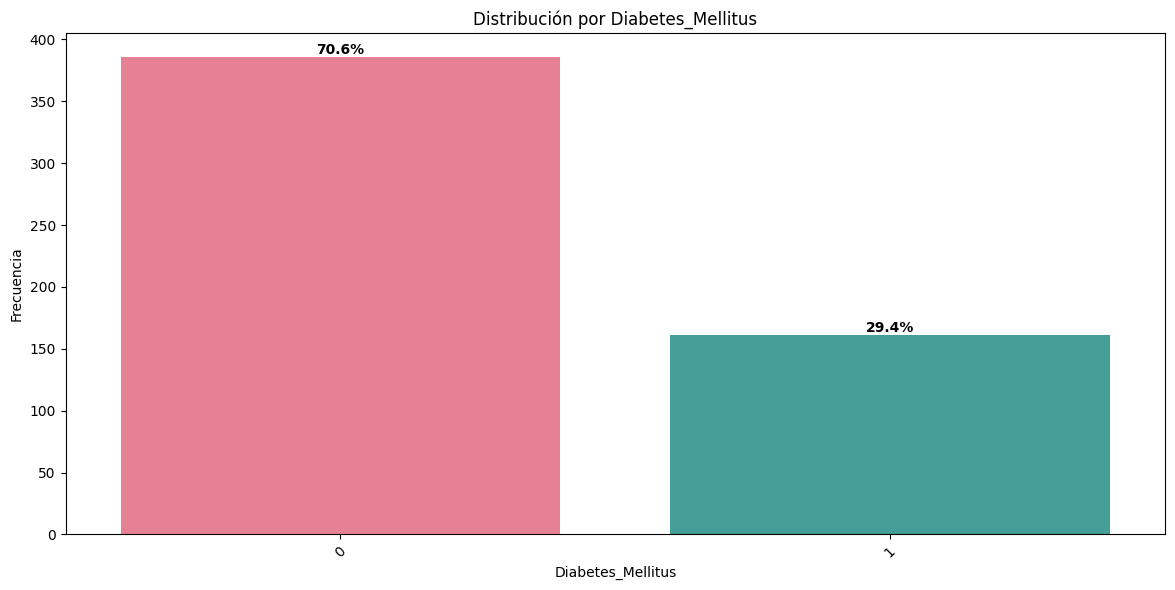

Orden de categorías para 'Tabaquismo': [0, 1]


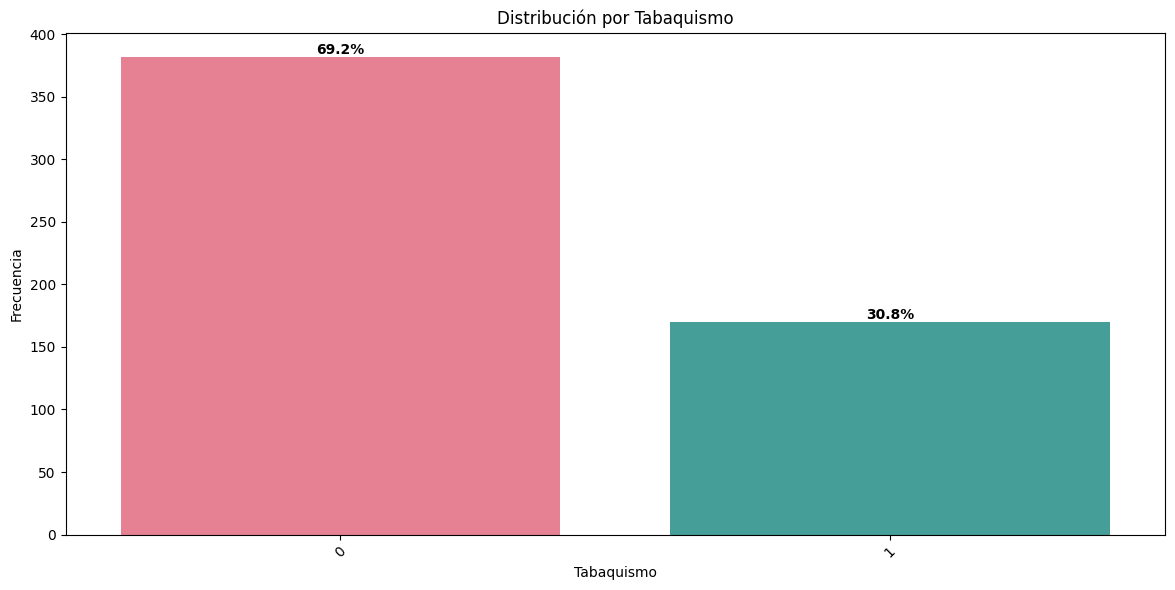

Orden de categorías para 'Alcoholismo': [0, 1]


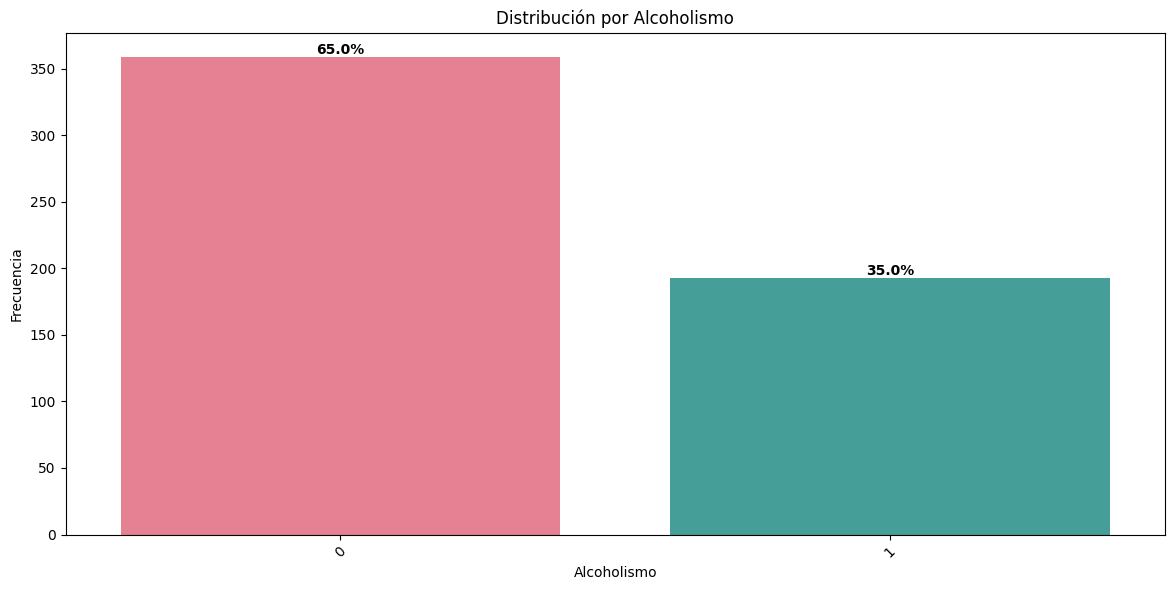

Orden de categorías para 'Hipertensión_Arterial': [0, 1]


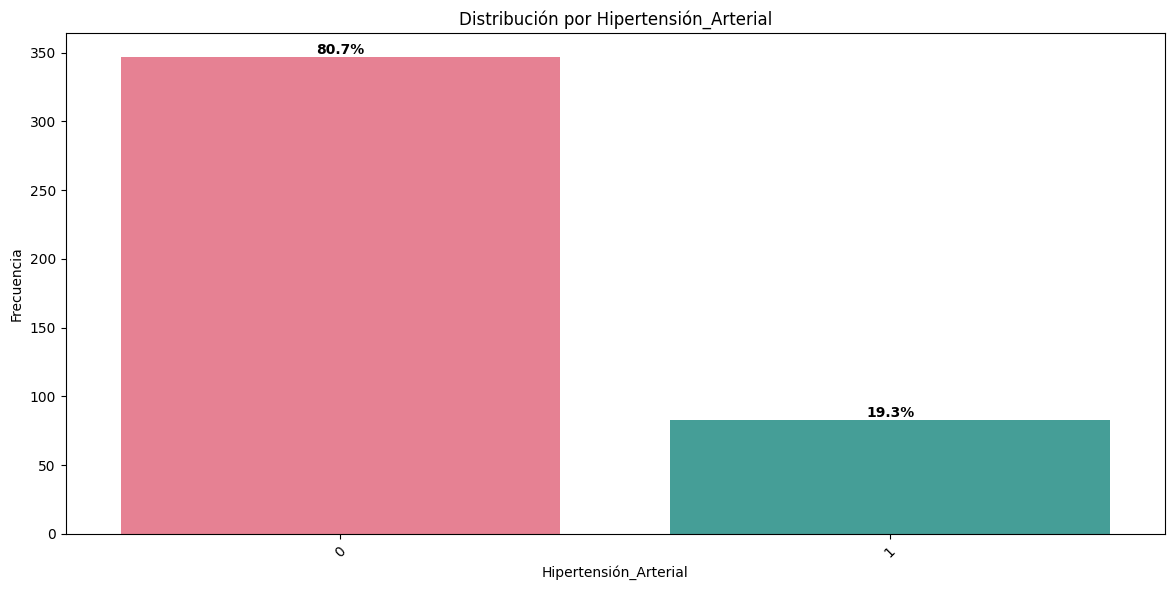

Orden de categorías para 'Antecedente_UCI_6_meses_PreOP': [0, 1]


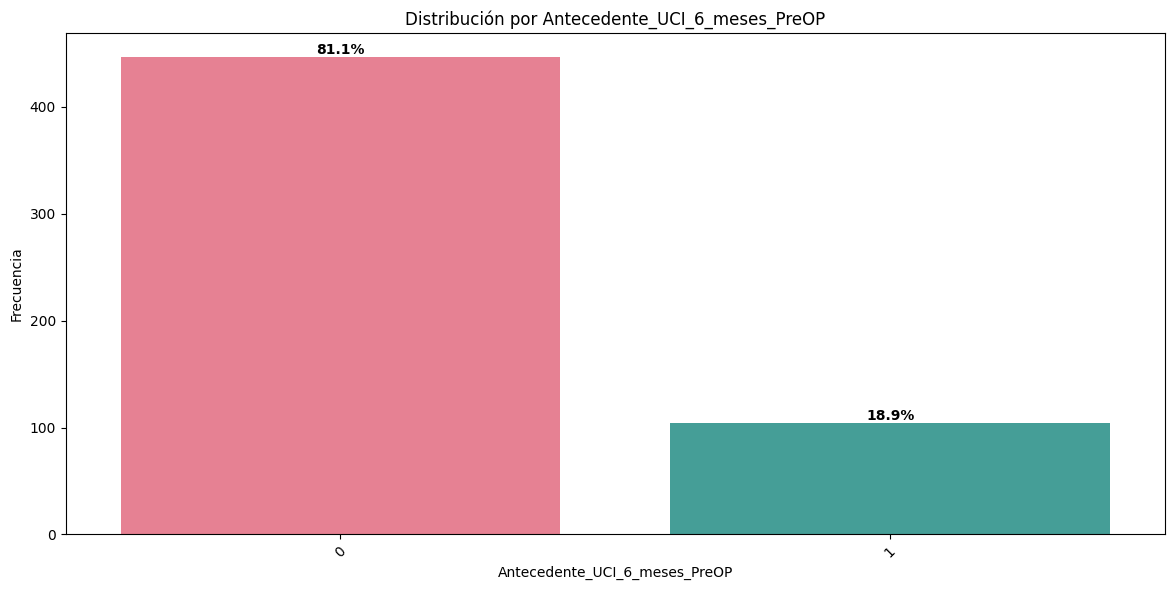

Orden de categorías para 'UCI_al_Momento_Tx': [0, 1]


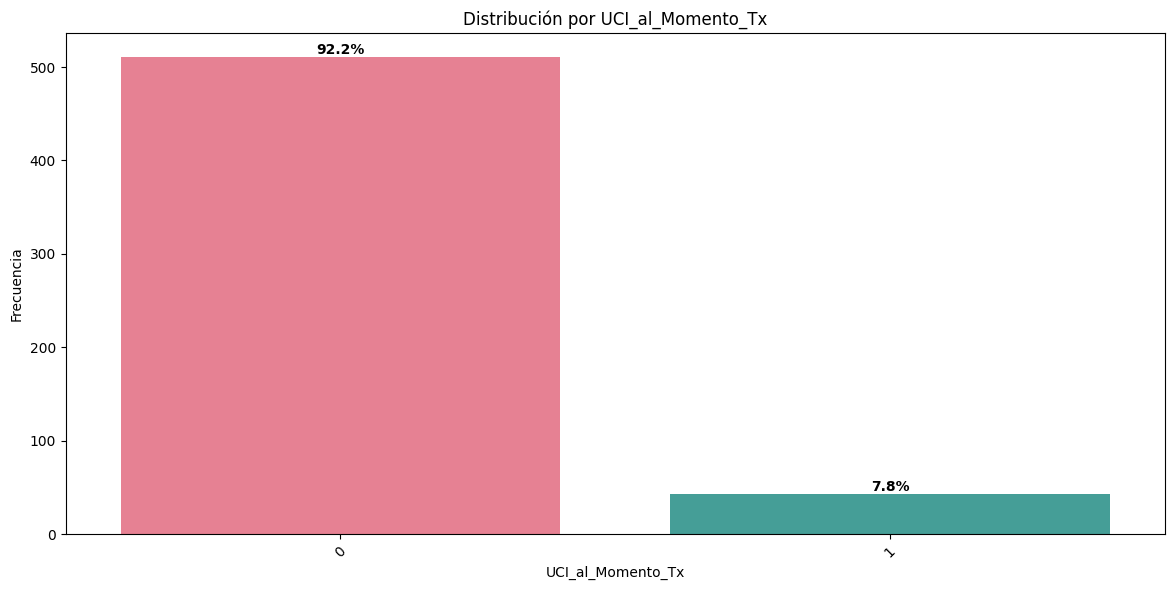

In [2229]:
for var in cat_vars:
    try:
        graficar_var_categorica(df_clean, var, show_legend=True)
    except Exception as e:
        print(f"Error al graficar {var}: {e}")

## *Grupo 2 — Intraoperatorio, profilaxis antibiótica y metadatos de registro*

Año_Tx; Fecha_Tx; Tiempo_Cx; Tiempo_Isquemia_Fria; Tiempo_Isquemia_caliente; Tipo_Reconstrucción_Biliar; Antibiótico_Profiláctico_VS_Terapéutico; Antibiotico_previo_al_Tx; Días_Tratamiento_Antibiótico_Previo_A_Tx#1; Tiempo_De_Dosis_Hasta_Tx#1; Antibiótico_1__Tx#1; Antibiótico_2_Tx#1; Antibiótico_3_Tx#1; Antifúngico_Tx#1; Infección_Al_Momento_Tx.

In [2230]:
columnas = ['Año_Tx', 'Fecha_Tx', 'Tiempo_Cx', 'Tiempo_Isquemia_Fria', 'Tiempo_Isquemia_caliente', 'Tipo_Reconstrucción_Biliar', 'Antibiótico_Profiláctico_VS_Terapéutico', 'Antibiotico_previo_al_Tx', 'Días_Tratamiento_Antibiótico_Previo_A_Tx#1', 'Tiempo_De_Dosis_Hasta_Tx#1', 'Antibiótico_1__Tx#1', 'Antibiótico_2_Tx#1', 'Antibiótico_3_Tx#1', 'Antifúngico_Tx#1', 'Infección_Al_Momento_Tx']

#### ``Año_Tx``
Año del trasplante

In [2231]:
df["Año_Tx"].isna().sum()

np.int64(0)

In [2232]:
df["Año_Tx"].value_counts(dropna=False)

Año_Tx
2017    58
2009    44
2016    43
2010    43
2015    40
2018    38
2012    37
2023    37
2014    35
2011    33
2019    33
2022    29
2013    27
2024    25
2021    22
2020    13
Name: count, dtype: int64

In [2233]:
df["Año_Tx"].describe()

count     557.000000
mean     2015.924596
std         4.500766
min      2009.000000
25%      2012.000000
50%      2016.000000
75%      2019.000000
max      2024.000000
Name: Año_Tx, dtype: float64

Orden de categorías para 'Año_Tx': [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


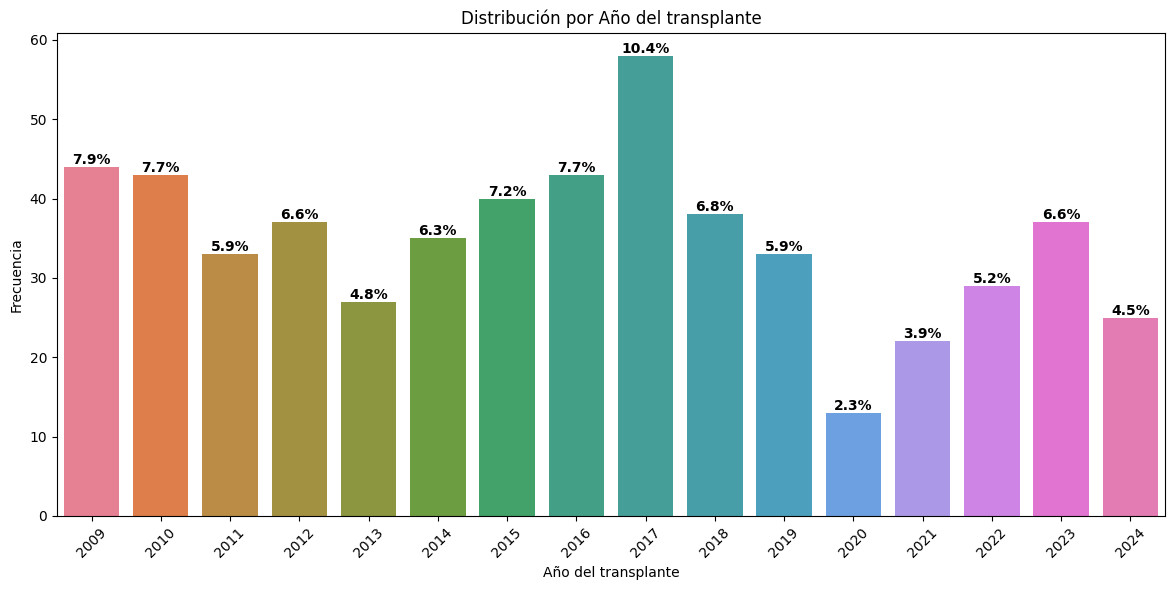

In [2234]:
graficar_var_categorica(df, "Año_Tx", "Año del transplante", ordinal=True)

#### ``Fecha_Tx``
Fecha del trasplante hepático

In [2235]:
df["Fecha_Tx"].dtype

dtype('<M8[ns]')

In [2236]:
df["Fecha_Tx"].isna().sum()

np.int64(0)

In [2237]:
# format as just date
df_clean.loc[:, "Fecha_Tx"] = pd.to_datetime(df_clean["Fecha_Tx"]).dt.date

In [2238]:

print(f"Fecha_Tx range: {df_clean['Fecha_Tx'].min()} to {df_clean['Fecha_Tx'].max()}")
df_clean['Fecha_Tx'].value_counts()

Fecha_Tx range: 2009-01-03 00:00:00 to 2024-10-29 00:00:00


Fecha_Tx
2010-12-27    2
2010-09-17    2
2014-01-05    2
2014-03-20    2
2017-03-11    2
             ..
2024-09-11    1
2009-03-08    1
2024-10-08    1
2024-10-16    1
2024-10-29    1
Name: count, Length: 544, dtype: int64

In [2239]:
# Verificamos que el año extraído de la fecha coincide con la columna Año_Tx
(pd.to_datetime(df["Fecha_Tx"]).dt.year == df["Año_Tx"]).value_counts()

True    557
Name: count, dtype: int64

In [2240]:
# crearemos unas nuevas columna con el mes
df_clean['Mes_Tx'] = pd.to_datetime(df['Fecha_Tx']).dt.month

In [2241]:
df_clean['Mes_Tx'].value_counts().sort_index()

Mes_Tx
1     43
2     51
3     60
4     45
5     41
6     45
7     45
8     41
9     47
10    48
11    43
12    48
Name: count, dtype: int64

Orden de categorías para 'Mes_Tx': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


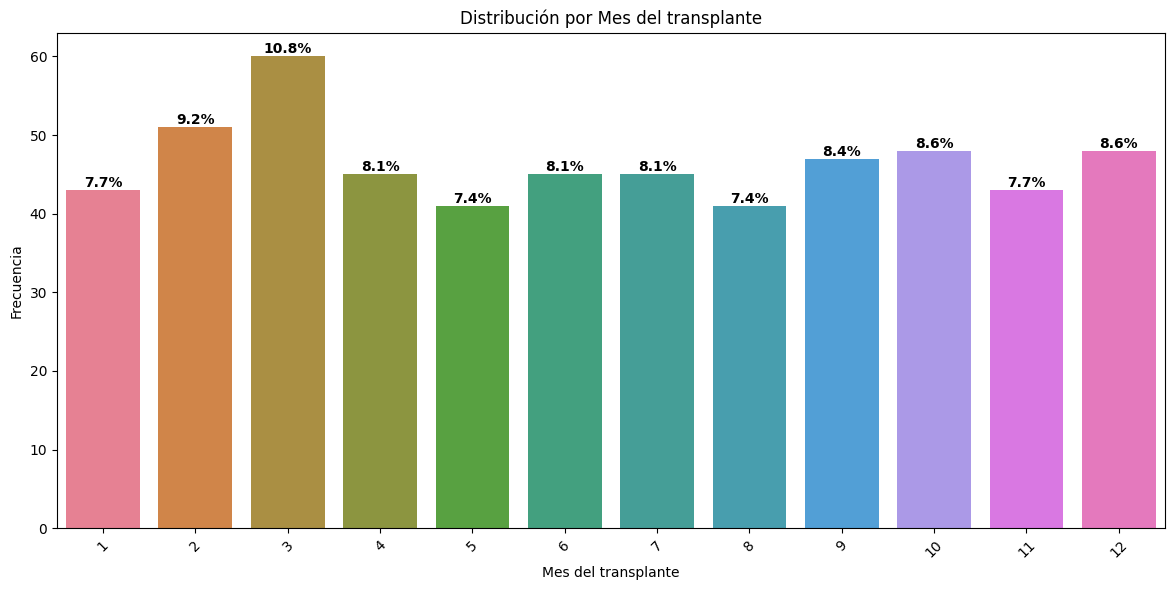

In [2242]:
graficar_var_categorica(df_clean, "Mes_Tx", "Mes del transplante", ordinal=True)

#### ``Tiempo_Cx``
Duración de la cirugia en horas.

Recomendación del experto: remover filas con duración inferior a las 2 horas.

In [2243]:
df["Tiempo_Cx"].isna().sum()

np.int64(0)

In [2244]:
df["Tiempo_Cx"].value_counts(dropna=False).sort_index()

Tiempo_Cx
0.00     83
0.02      1
1.83      1
1.92      1
2.00      1
         ..
19.00     1
20.00     1
20.50     1
21.58     1
22.82     1
Name: count, Length: 183, dtype: int64

In [2245]:
tiempo_operacion = df["Tiempo_Cx"].copy()
# crear máscara para valores válidos, 0 horas no tiene sentido
mask_valid = tiempo_operacion > 2 # mayor o igual a 2 horas
tiempo_operacion[~mask_valid] = np.nan
df_clean["Tiempo_Cx"] = pd.to_numeric(tiempo_operacion, errors="coerce")

In [2246]:
df_clean["Tiempo_Cx"].describe()

count    470.000000
mean       8.989149
std        2.570930
min        2.250000
25%        7.557500
50%        8.670000
75%        9.787500
max       22.820000
Name: Tiempo_Cx, dtype: float64

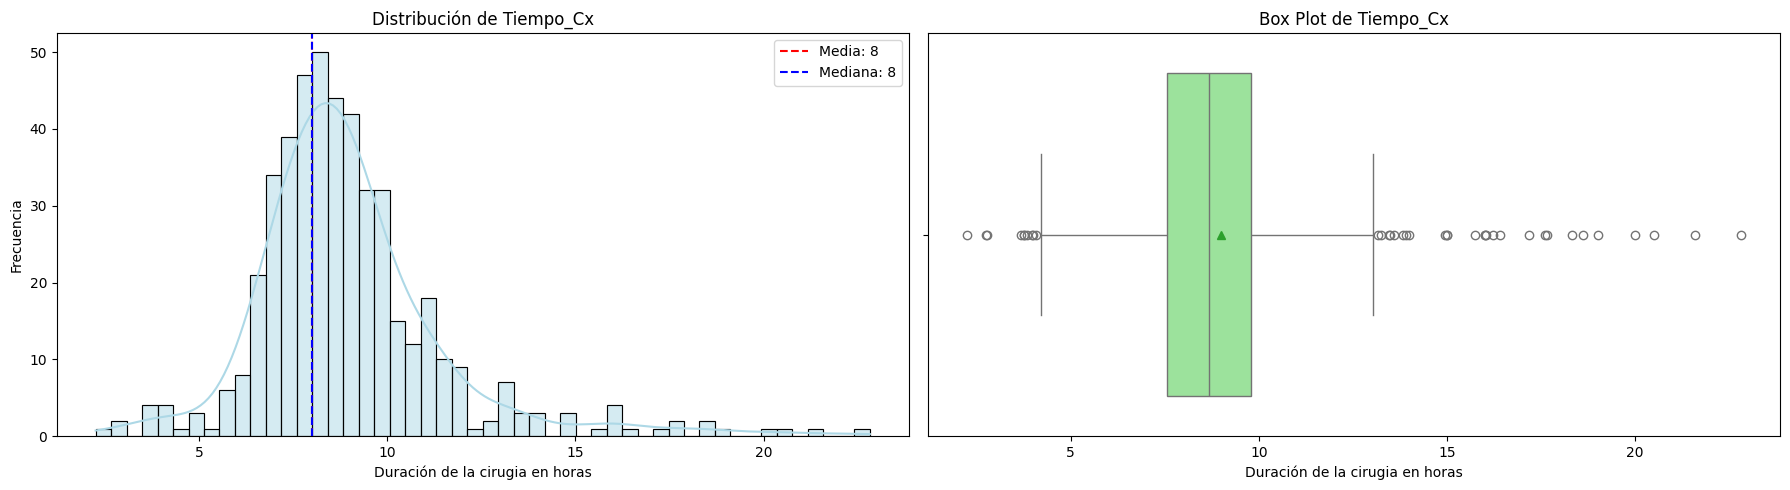

In [2247]:
graficar_var_numerica(df_clean, "Tiempo_Cx", "Duración de la cirugia en horas")

#### ``Tiempo_Isquemia_Fria``
Tiempo de isquemia fría reportado en la historia clínica en horas

In [2248]:
df["Tiempo_Isquemia_Fria"].isna().sum()

np.int64(178)

In [2249]:
import re
def extraer_horas_minutos(value):
    minutos = np.nan
    value = str(value).strip().lower()
    numeros = re.findall(r'\d+', value)
    if len(numeros) == 2:
        minutos = int(numeros[0]) * 60 + int(numeros[1]) # convertir todo a minutos
    elif len(numeros) == 1:
        if "h" in value:
            minutos = int(numeros[0]) * 60
        elif "m" in value:
            minutos = int(numeros[0])
        else:
            # Caso "solo números" (sin texto h o m): asumir MINUTOS
            minutos = int(numeros[0])
    return minutos

In [2250]:
# Creamos un DataFrame temporal para visualizar la transformación
df_temp = pd.DataFrame()
df_temp["Tiempo_Isquemia_Fria new"] = df["Tiempo_Isquemia_Fria"].apply(extraer_horas_minutos)
df_temp["Tiempo_Isquemia_Fria"] = df["Tiempo_Isquemia_Fria"].copy()
df_temp

,Tiempo_Isquemia_Fria new,Tiempo_Isquemia_Fria
0,NaN,NaN
1,662.0,11 HO 2
2,388.0,6H 28MIN
3,NaN,NaN
4,NaN,NaN
...,...,...
552,NaN,NaN
553,NaN,NaN
554,NaN,NaN
555,NaN,NaN


In [2251]:
# aplicamos la transformación al DataFrame limpio
df_clean["Tiempo_Isquemia_Fria"] = (df["Tiempo_Isquemia_Fria"].apply(extraer_horas_minutos) / 60).round(2)

In [2252]:
df_clean["Tiempo_Isquemia_Fria"].value_counts(dropna=False).sort_index()

Tiempo_Isquemia_Fria
0.08       1
0.13       1
2.42       1
2.75       1
3.00       4
        ... 
13.00      5
13.07      1
14.50      1
57.00      1
NaN      180
Name: count, Length: 103, dtype: int64

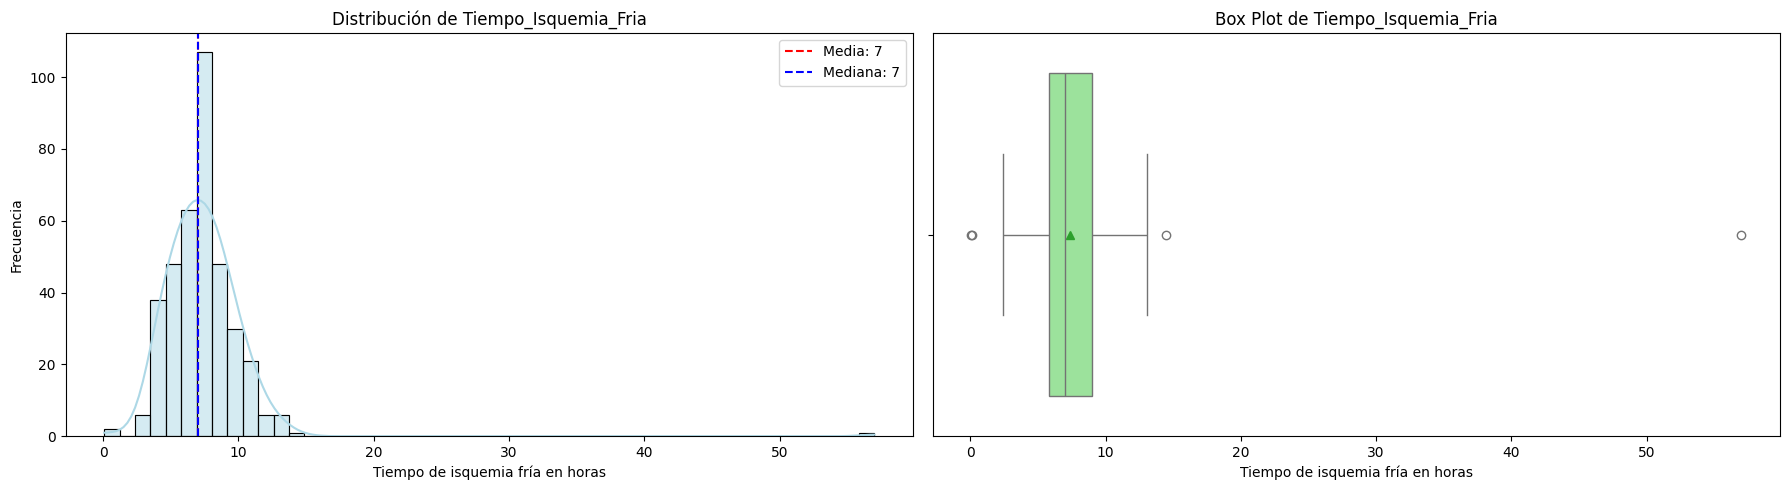

In [2253]:
graficar_var_numerica(df_clean, "Tiempo_Isquemia_Fria", "Tiempo de isquemia fría en horas")

In [2254]:
df_clean["Tiempo_Isquemia_Fria"].describe().round(2)

count    377.00
mean       7.38
std        3.44
min        0.08
25%        5.85
50%        7.00
75%        9.00
max       57.00
Name: Tiempo_Isquemia_Fria, dtype: float64

#### `Tiempo_Isquemia_caliente`
Tiempo de isquemia caliente reportado en la historia clínica en minutos


In [2255]:
df["Tiempo_Isquemia_caliente"].isna().sum()

np.int64(136)

In [2256]:
# aplicamos la transformación al DataFrame limpio
df_clean["Tiempo_Isquemia_caliente"] = df["Tiempo_Isquemia_caliente"].apply(extraer_horas_minutos).astype('Int16')

In [2257]:
df_clean["Tiempo_Isquemia_caliente"].describe().round(2)

count    415.0
mean     36.67
std      16.55
min       20.0
25%       30.0
50%       34.0
75%       40.0
max      301.0
Name: Tiempo_Isquemia_caliente, dtype: Float64

In [2258]:
df_clean["Tiempo_Isquemia_caliente"].value_counts(dropna=False)

Tiempo_Isquemia_caliente
<NA>    142
30       38
35       28
34       27
33       22
28       20
31       19
38       19
27       17
32       17
36       17
40       16
37       16
29       13
39       12
44       12
41       12
45       12
25        8
46        8
23        7
26        7
42        6
43        6
48        6
51        6
21        5
24        5
47        5
50        5
52        4
53        4
20        2
22        2
55        1
301       1
70        1
65        1
58        1
60        1
54        1
69        1
128       1
56        1
125       1
61        1
Name: count, dtype: Int64

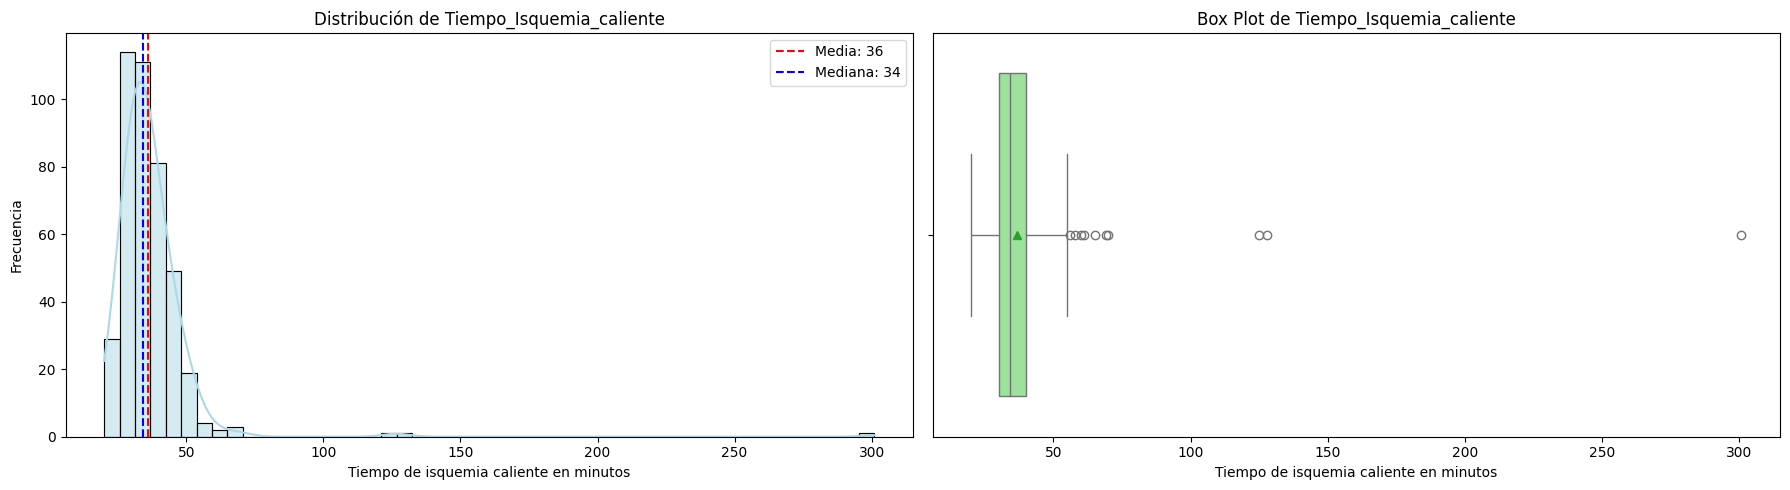

In [2259]:
graficar_var_numerica(df_clean, "Tiempo_Isquemia_caliente", "Tiempo de isquemia caliente en minutos")

#### ``Días_Tratamiento_Antibiótico_Previo_A_Tx#1``

Si fue terapéutico, definir desde cuánto tiempo antes recibió el Antibiotico

In [2260]:
df["Días_Tratamiento_Antibiótico_Previo_A_Tx#1"].isna().sum()

np.int64(0)

In [2261]:
df["Días_Tratamiento_Antibiótico_Previo_A_Tx#1"].value_counts(dropna=False)

Días_Tratamiento_Antibiótico_Previo_A_Tx#1
0     526
2       8
3       5
5       4
4       3
1       3
14      3
10      2
9       1
18      1
27      1
Name: count, dtype: int64

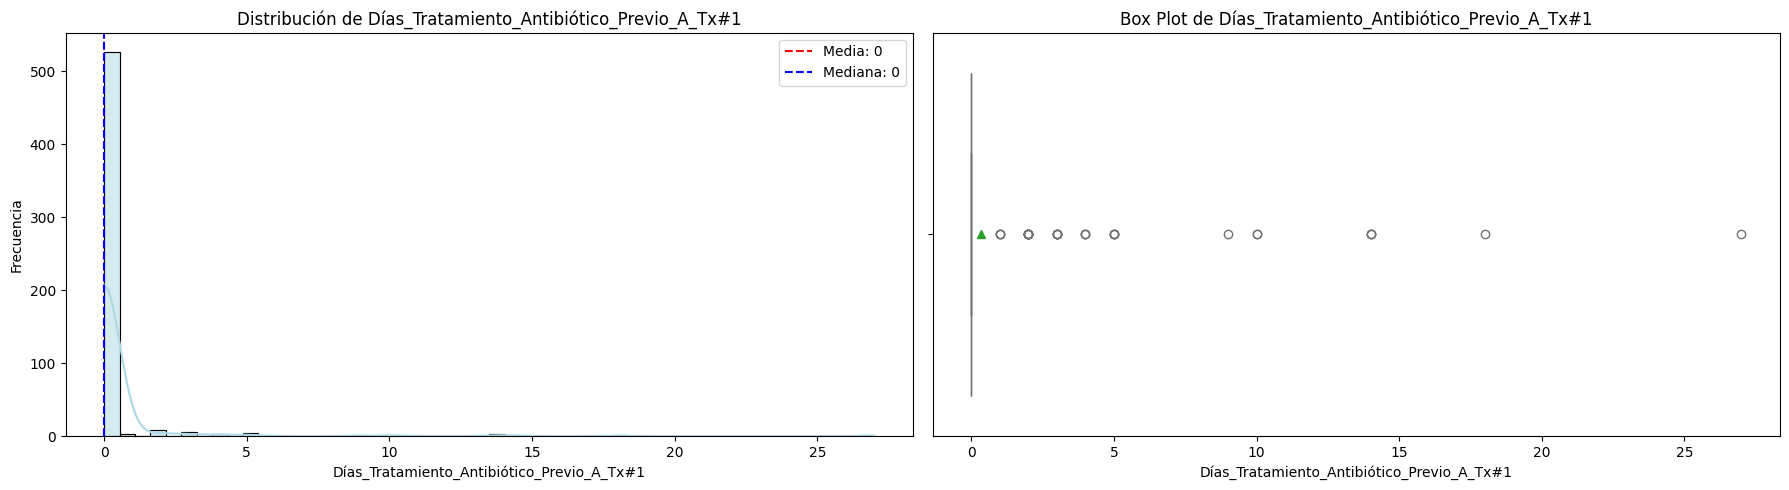

In [2262]:
graficar_var_numerica(df, "Días_Tratamiento_Antibiótico_Previo_A_Tx#1", "Días_Tratamiento_Antibiótico_Previo_A_Tx#1")

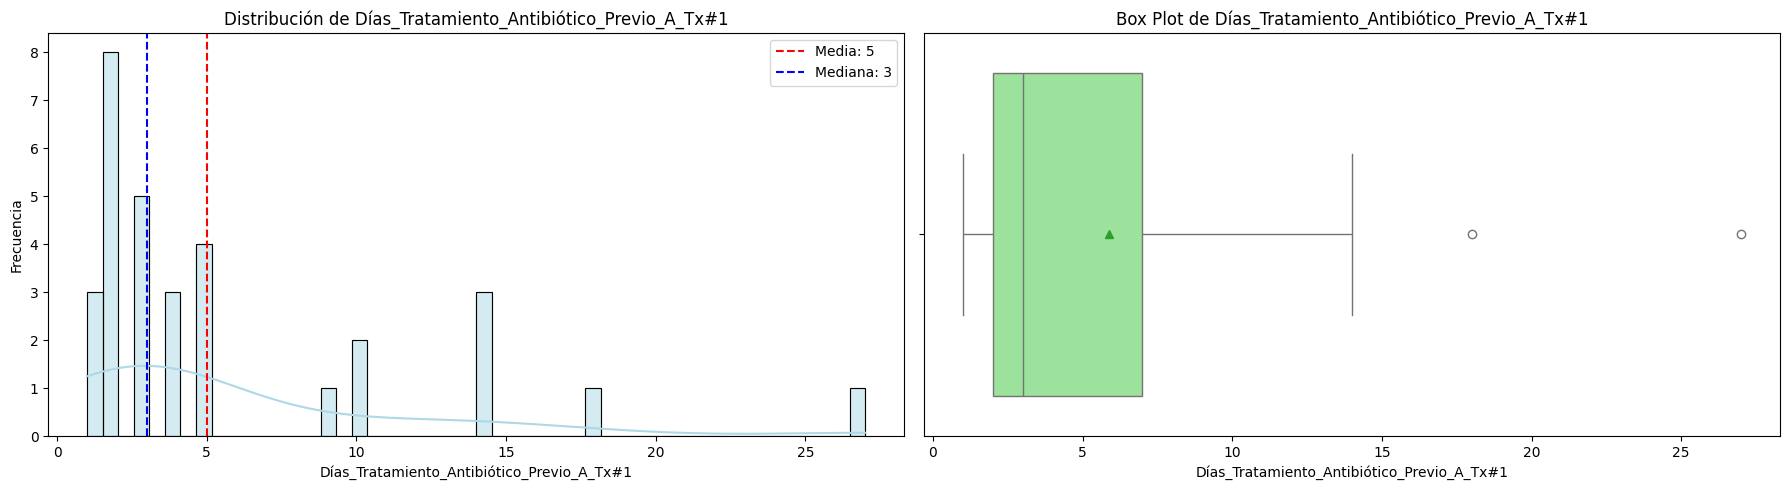

In [2263]:
graficar_var_numerica(df[df["Días_Tratamiento_Antibiótico_Previo_A_Tx#1"]!=0], "Días_Tratamiento_Antibiótico_Previo_A_Tx#1", "Días_Tratamiento_Antibiótico_Previo_A_Tx#1")

#### ``Tiempo_De_Dosis_Hasta_Tx#1``

TIEMPO ENTRE LA PROFILAXIS ANTIBIÓTICA Y LA INCISION (min)

In [2264]:
df["Tiempo_De_Dosis_Hasta_Tx#1"].isna().sum()

np.int64(3)

In [2265]:
df["Tiempo_De_Dosis_Hasta_Tx#1"]

0      60
1      50
2      35
3      90
4      50
       ..
552    48
553    69
554    52
555    46
556    64
Name: Tiempo_De_Dosis_Hasta_Tx#1, Length: 557, dtype: object

dejar solo los enteros, borrar decimales y negativos

In [2266]:
 

# 1) Asegura numérico
s = pd.to_numeric(df["Tiempo_De_Dosis_Hasta_Tx#1"], errors="coerce")

# 2) Deja NaN donde haya decimales (solo se castea si es entero)
non_integer = ~s.isna() & (s != np.floor(s))
s = s.where(~non_integer)

# 2) ceil
s = np.ceil(s)

# 3) Deja NaN donde haya negativos
s = s.where(s >= 0)

# 4) Reemplaza 9999 y 99999 por -2
s = s.where(~s.isin([9999, 99999]), NO_APLICA)

# 5) Ahora sí, castear a entero anulable
df_clean.drop(columns=["Tiempo_De_Dosis_Hasta_Tx#1"], inplace=True, errors='ignore')
df_clean["Tiempo_De_Dosis_Hasta_Tx#1"] = s.astype("Int16")

In [2267]:
df_clean["Tiempo_De_Dosis_Hasta_Tx#1"]

0      60
1      50
2      35
3      90
4      50
       ..
552    48
553    69
554    52
555    46
556    64
Name: Tiempo_De_Dosis_Hasta_Tx#1, Length: 557, dtype: Int16

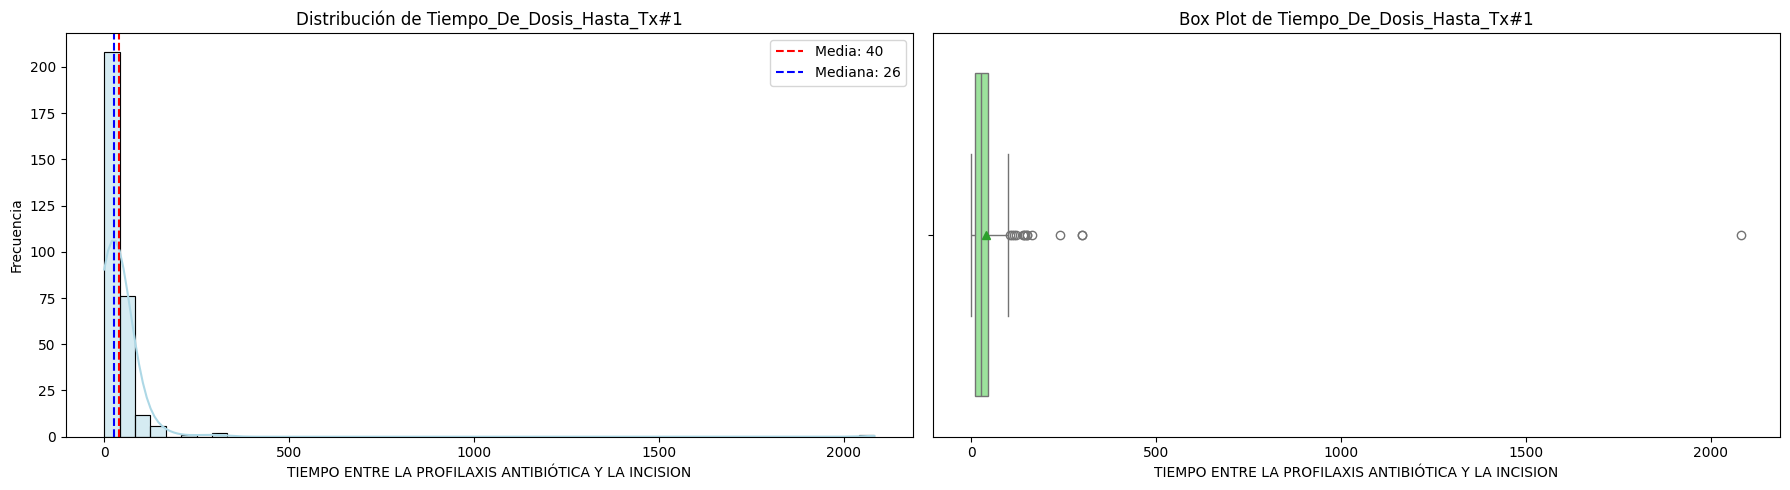

In [2268]:
graficar_var_numerica(df_clean, "Tiempo_De_Dosis_Hasta_Tx#1", "TIEMPO ENTRE LA PROFILAXIS ANTIBIÓTICA Y LA INCISION")

#### ``Tipo_Reconstrucción_Biliar``

Define cómo se reconstruyó la vía biliar

{'1': 'Ducto - Ducto', '2': 'Hepatico o Coledocoyeyunostomía + Reconstrucción en Y de Roux'}

In [2269]:
df["Tipo_Reconstrucción_Biliar"].isna().sum()

np.int64(1)

In [2270]:
df["Tipo_Reconstrucción_Biliar"].value_counts(dropna=False)

Tipo_Reconstrucción_Biliar
1                                                                 482
2                                                                  36
9999-cavo-cavostomia latero lateral                                31
9999                                                                2
NaN                                                                 1
RECONSUTRCCION BILIAR COLEDOCO-COLEDOCOSTOMIA TERMINO-TERMINAL      1
?                                                                   1
no hay nota operatoria                                              1
BILIAR HEPATICO- COLEDOCO STOMIA TERMINO TERMINAL.                  1
0                                                                   1
Name: count, dtype: int64

In [2271]:
s = df["Tipo_Reconstrucción_Biliar"].copy()
# identificar no aplica
mask = s.isin(["9999-cavo-cavostomia latero lateral	31", 9999, 0, "RECONSUTRCCION BILIAR COLEDOCO-COLEDOCOSTOMIA TERMINO-TERMINAL", "BILIAR HEPATICO- COLEDOCO STOMIA TERMINO TERMINAL.	1"])
s = s.where(~mask, np.nan)
# el resto de valores se castean a nan
df_clean["Tipo_Reconstrucción_Biliar"] = pd.to_numeric(s, errors="coerce").astype("Int64")

In [2272]:
df_clean["Tipo_Reconstrucción_Biliar"].value_counts(dropna=False)

Tipo_Reconstrucción_Biliar
1       482
<NA>     39
2        36
Name: count, dtype: Int64

Orden de categorías para 'Tipo_Reconstrucción_Biliar': [1, 2]


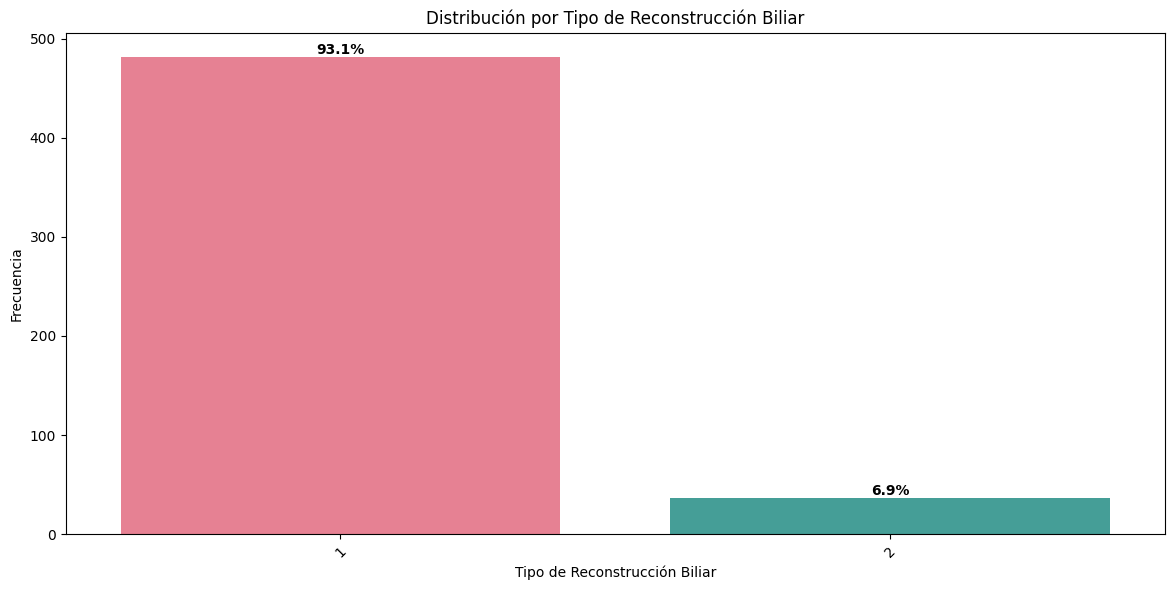

In [2273]:
graficar_var_categorica(df_clean, "Tipo_Reconstrucción_Biliar", "Tipo de Reconstrucción Biliar", show_legend=True, ordinal=False)

#### ``Antibiótico_Profiláctico_VS_Terapéutico``

Define si el AB que recibió al momento de la Cx fue profiláctico como parte de un tratamiento

{'0': 'Profiláctico', '1': 'Terapéutico '}

In [2274]:
df["Antibiótico_Profiláctico_VS_Terapéutico"].isna().sum()

C:\Users\esteb\AppData\Roaming\Python\Python312\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


np.int64(0)

In [2275]:
df["Antibiótico_Profiláctico_VS_Terapéutico"].value_counts(dropna=False)

Antibiótico_Profiláctico_VS_Terapéutico
0    522
1     35
Name: count, dtype: int64

Orden de categorías para 'Antibiótico_Profiláctico_VS_Terapéutico': [0, 1]


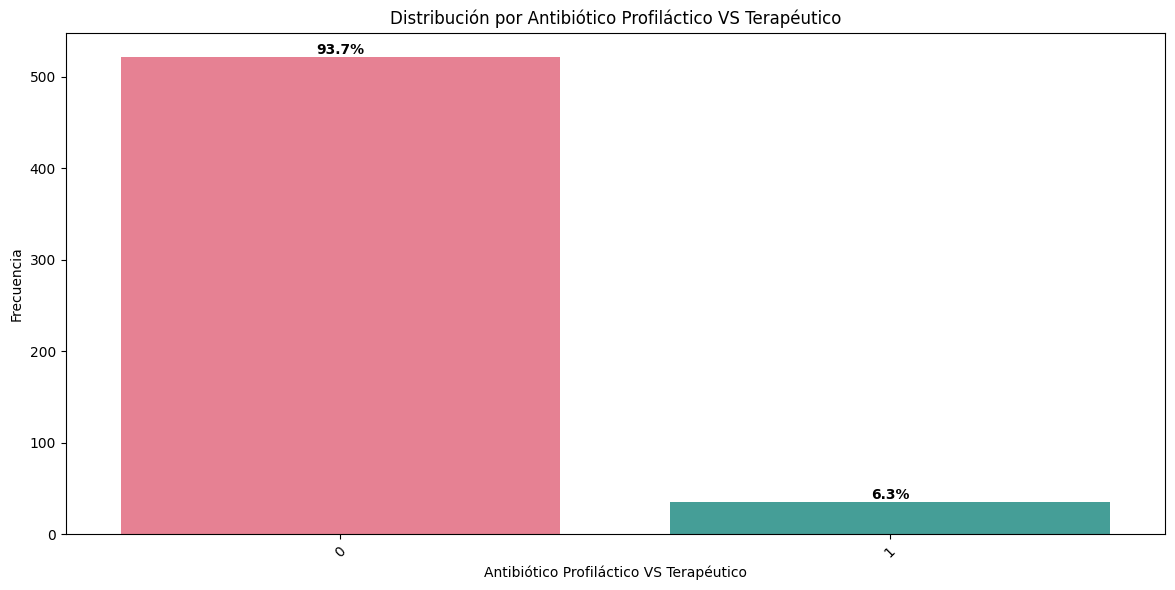

In [2276]:
graficar_var_categorica(df, "Antibiótico_Profiláctico_VS_Terapéutico", "Antibiótico Profiláctico VS Terapéutico", show_legend=True, ordinal=False)

#### ``Antibiotico_previo_al_Tx``

Antibiótico terapia previa a 3 meses

{'0': 'NO', '1': 'SI'}


In [2277]:
df["Antibiotico_previo_al_Tx"].isna().sum()

np.int64(300)

In [2278]:
df["Antibiotico_previo_al_Tx"].value_counts(dropna=False)

Antibiotico_previo_al_Tx
NaN                                                             300
 AMPICILINA-SULBACTAM, GENTAMICINA                               14
 AMPICILINA-SULBACTAM                                            11
 AMPICILINA SULBACTAM - GENTAMICINA                              10
 AMPICILINA SULBACTAM                                            10
                                                               ... 
  CEFTAZIDIME AVIBACTAM + AMIKACINA (ANTIBIOTITOC TERAPEUTIC      1
 PIPERACILINA TZOBACTAM (INICIO 10+47 - FINALIZA 11+30)  COM      1
 PIERACILINA/TAZOBACTAM 4                                         1
  PIPERACILINA TAZOBACTAM (EMPIEZA 07+58 HORAS Y TERMINA 08+      1
  CEFTAZIDIMA AVIBACTAM 2                                         1
Name: count, Length: 198, dtype: int64

In [2279]:
s = df["Antibiotico_previo_al_Tx"].copy()
s.loc[~s.isna()] = 1 # si valor, sí recibió antibiótico previo
s = s.fillna(0) # si nan, no recibió antibiótico previo
df_clean["Antibiotico_previo_al_Tx"] = s.astype("int64")

C:\Users\esteb\AppData\Local\Temp\ipykernel_27020\3252847760.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s = s.fillna(0) # si nan, no recibió antibiótico previo


Orden de categorías para 'Antibiotico_previo_al_Tx': [0, 1]


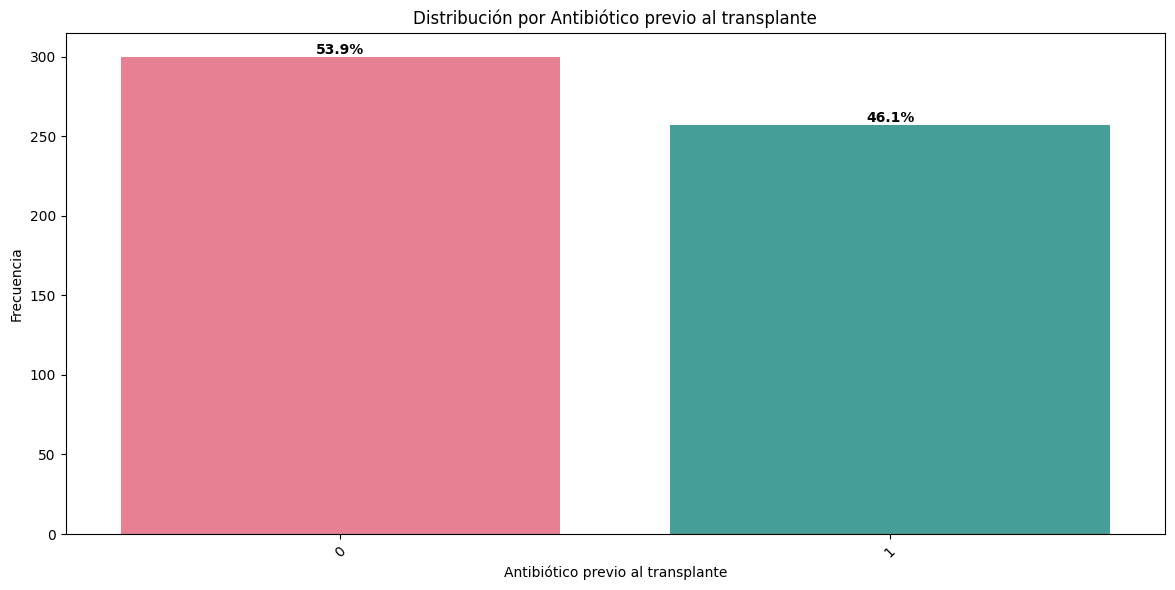

In [2280]:
graficar_var_categorica(df_clean, "Antibiotico_previo_al_Tx", "Antibiótico previo al transplante", show_legend=True, ordinal=False)

#### ``Antibiótico_1__Tx#1``
MEDICAMENTO ANTIBIÓTICO UTILIZADO COMO PROFILAXIS O TRATAMIENTO

{'0': 'NO', '1': 'CEFAZOLINA', '2': 'CEFUROXIMA', '3': 'CEFTRIAXONA', '4': 'CEFEPIME', '5': 'AMPICILINA SULBACTAM ', '6': 'PIPERACILINA TAZOBACTAM ', '7': 'CEFTAZIDIMA AVIBACTAM', '8': 'MEROPENEM ', '9': 'ERTAPENEM ', '10': 'GENTAMICINA', '11': 'AMIKACINA', '12': 'CIPROFLOXACINA', '13': 'CLINDAMICINA', '14': 'VANCOMICINA', '15': 'LINEZOLID', '16': 'TIGECICLINA', '17': 'METRONIDAZOL', '18': 'TRIMETROPIM/SULFAMETOXAZOL'}


In [2281]:
df["Antibiótico_1__Tx#1"].isna().sum()

np.int64(0)

In [2282]:
df["Antibiótico_1__Tx#1"].value_counts(dropna=False)

Antibiótico_1__Tx#1
5     392
6      99
8      19
2      15
10      7
7       7
18      6
16      4
9       3
3       2
0       1
12      1
4       1
Name: count, dtype: int64

Orden de categorías para 'Antibiótico_1__Tx#1': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 16, 18]


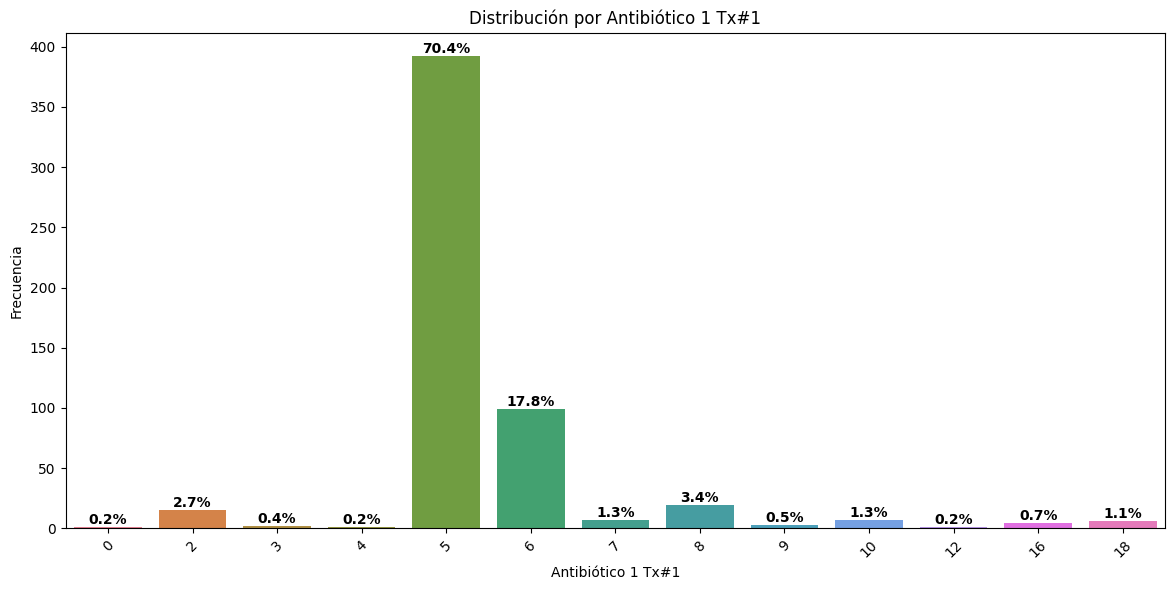

In [2283]:
graficar_var_categorica(df, "Antibiótico_1__Tx#1", "Antibiótico 1 Tx#1", show_legend=True)

#### ``Antibiótico_2_Tx#1	``

MEDICAMENTO ANTIBIÓTICO UTILIZADO COMO PROFILAXIS O TRATAMIENTO

{'0': 'NO', '1': 'CEFAZOLINA', '2': 'CEFUROXIMA', '3': 'CEFTRIAXONA', '4': 'CEFEPIME', '5': 'AMPICILINA SULBACTAM ', '6': 'PIPERACILINA TAZOBACTAM ', '7': 'CEFTAZIDIMA AVIBACTAM', '8': 'MEROPENEM ', '9': 'ERTAPENEM ', '10': 'GENTAMICINA', '11': 'AMIKACINA', '12': 'CIPROFLOXACINA', '13': 'CLINDAMICINA', '14': 'VANCOMICINA', '15': 'LINEZOLID', '16': 'TIGECICLINA', '17': 'METRONIDAZOL', '18': 'TRIMETROPIM/SULFAMETOXAZOL', '19': 'DAPTOMICINA', '20': 'AZTREONAM'}	Categorical

In [2284]:
df["Antibiótico_2_Tx#1"].isna().sum()

np.int64(0)

In [2285]:
df["Antibiótico_2_Tx#1"].value_counts(dropna=False)

Antibiótico_2_Tx#1
10    361
0     154
17     15
5       8
15      4
14      3
11      2
13      1
3       1
9       1
18      1
12      1
7       1
8       1
16      1
19      1
20      1
Name: count, dtype: int64

Orden de categorías para 'Antibiótico_2_Tx#1': [0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


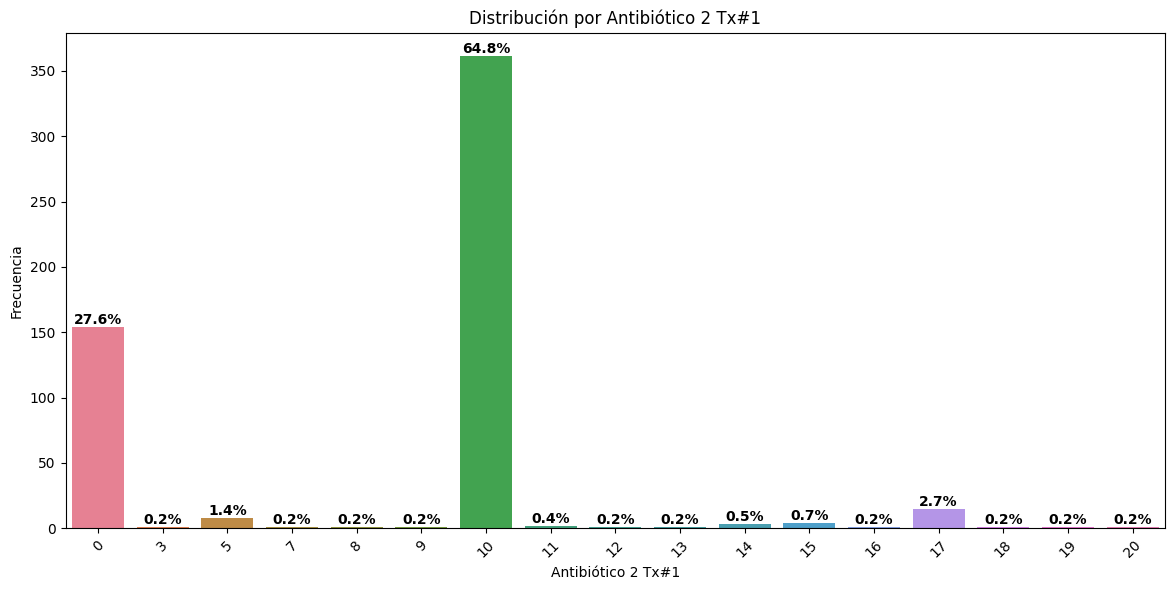

In [2286]:
graficar_var_categorica(df_clean, "Antibiótico_2_Tx#1", "Antibiótico 2 Tx#1", show_legend=True)

#### ``Antibiótico_3_Tx#1``

In [2287]:
df["Antibiótico_3_Tx#1"].isna().sum()

np.int64(0)

In [2288]:
df["Antibiótico_3_Tx#1"].value_counts(dropna=False)

Antibiótico_3_Tx#1
0                           551
14                            2
9                             1
18                            1
FLUCONAZOL 13 DIAS LUEGO      1
PENICILINA                    1
Name: count, dtype: int64

In [2289]:
filter = df["Antibiótico_3_Tx#1"].isin(["FLUCONAZOL 13 DIAS LUEGO"])
df.loc[filter, "Antifúngico_Tx#1"] = 1

In [2290]:
s = df["Antibiótico_3_Tx#1"]
s = s.where(~s.isin(["PENICILINA"]), 19)
s = pd.to_numeric(s, errors="coerce").astype("Int64")
df_clean["Antibiótico_3_Tx#1"] = s

Orden de categorías para 'Antibiótico_3_Tx#1': [0, 9, 14, 18, 19]


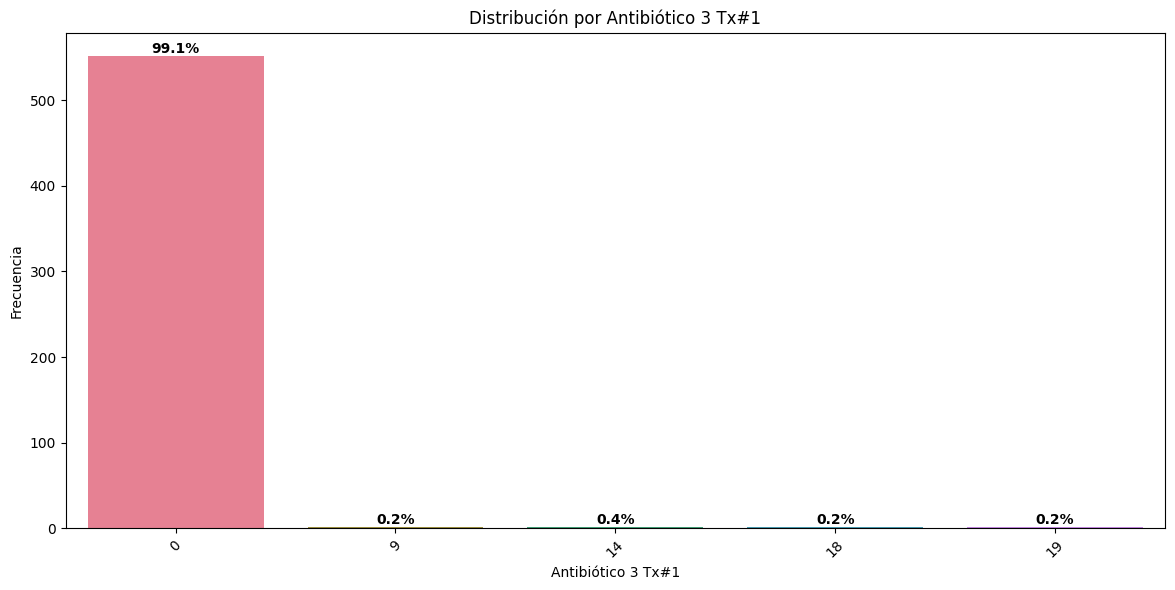

In [2291]:
graficar_var_categorica(df_clean, "Antibiótico_3_Tx#1", "Antibiótico 3 Tx#1", show_legend=True)

#### ``Antifúngico_Tx#1``

MEDICAMENTO ANTIFÚNGICO UTILIZADO COMO PROFILAXIS O TRATAMIENTO
{'0': 'NO', '1': 'FLUCONAZOL ', '2': 'VORICONAZOL'}

In [2292]:
df["Antifúngico_Tx#1"].isna().sum()

np.int64(0)

In [2293]:
df["Antifúngico_Tx#1"].value_counts(dropna=False)

Antifúngico_Tx#1
0                      545
1                        7
2                        1
1*                       1
1* EL 17                 1
0 voriconazol el 19      1
FLUCONAZOL EL 12/11      1
Name: count, dtype: int64

In [2294]:

s = df["Antifúngico_Tx#1"].copy()
# mapear a 1: Fluconazol
mask1 = df["Antifúngico_Tx#1"].isin([ '1*', 'FLUCONAZOL EL 12/11', "1* EL 17"])
s = s.where(~mask1, 1)
#mapear a 2: Voriconazol
mask2 = df["Antifúngico_Tx#1"].isin(["0 voriconazol el 19"])
s = s.where(~mask2, 2)
df_clean["Antifúngico_Tx#1"] = pd.to_numeric(s, errors="coerce").astype("Int64")


In [2295]:
df_clean["Antifúngico_Tx#1"].value_counts(dropna=False)

Antifúngico_Tx#1
0    545
1     10
2      2
Name: count, dtype: Int64

Orden de categorías para 'Antifúngico_Tx#1': [0, 1, 2]


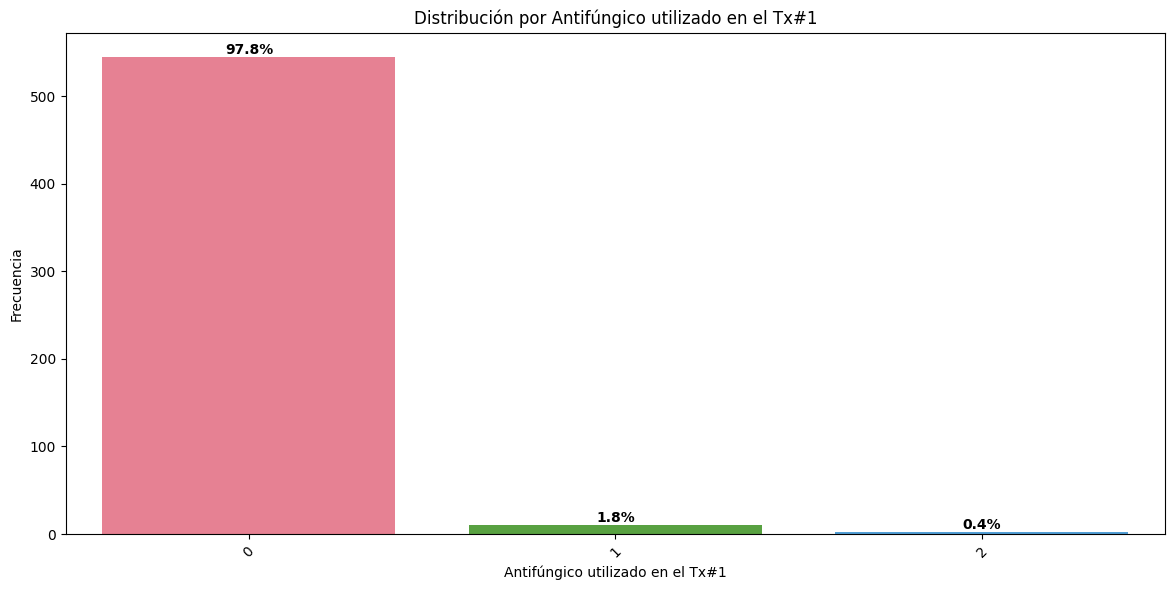

In [2296]:
graficar_var_categorica(df_clean, "Antifúngico_Tx#1", "Antifúngico utilizado en el Tx#1", show_legend=True)

## Grupo 3 — Infección y curso postoperatorio temprano

Localización de la infección; Germen/Microorganismo aislado; Nutrición_Enteral; Días_Nutrición_Enteral; Requerimiento_de_diálisis; Trasfusión_GRE_hasta_1m_POP; Reintervención_Quirúrgica_hasta_1m_POP; Complicaciones_Técnicas; Días_En_UCI_POP; Días_En_Hospitalización_Piso; Días_Totales_Intrahospitalarios; Fecha_Egreso_UCI; Fecha_Egreso_Hospitalario; Retrasplante; Infección_Al_Momento_Tx

In [2297]:
estancias_globales = [
    "Infección_Al_Momento_Tx",
    "Localización de la infección",
    "Germen/Microorganismo aislado",
    "Nutrición_Enteral",
    "Requerimiento_de_diálisis",
    "Trasfusión_GRE_hasta_1m_POP",
    "Complicaciones_Técnicas",
    "Días_En_UCI_POP",
    "Días_En_Hospitalización_Piso",
    "Días_Totales_Intrahospitalarios",
    "Fecha_Egreso_UCI",
    "Fecha_Egreso_Hospitalario",
    "Retrasplante"]

#### ``Localización de la infección``
LOCALIZACIÓN DE LA INFECCIÓN

{
         "1": "Bacteremia primaria ",
         "2": "Neumonia ",
         "3": "IVU ",
         "4": "Bacteremia asociada a catéter ",
         "5": "Infección intraabdominal "
      },

Debido al stake holder, vamos a relacionar esta columna con la columna Localización de la infección.

Por el mal uso de la ingesta de datos, la información que debería estar en la localización de la infección, está en la Infección_Al_Momento, que solo es binaria.

Por lo que, si la columna Infección_Al_Momento tiene texto, se va a interpretar como un si, y con ayuda del stakeholder se clasificó en la columna Localización de la infección.

- Si tiene las siglas IVU, se les puede poner clasificación 3 (IVU)

- Si la columna contiene TBC (Tuberculósis), se les puede poner clasificación 2 (Neumonía)

- Si la columna tiene peritonitis, se les puede poner clasificación 5 (Infección intra abdominal)

In [2298]:
df_clean["Localización de la infección"].value_counts()

Localización de la infección
0.0     61
10.0     8
6.0      3
3.0      3
7.0      2
2.0      1
Name: count, dtype: int64

In [2299]:
df2 = df_clean[["Infección_Al_Momento_Tx" , "Localización de la infección"]].copy()
# Si en la columna 'Infección_Al_Momento_Tx' aparece 'IVU',
# clasificar como categoría 3 (IVU)
df2.loc[
    df2["Infección_Al_Momento_Tx"].astype(str).str.contains('IVU', case=False, na=False),
    "Localización de la infección"
] = 3.0

# Si en la columna 'Infección_Al_Momento_Tx' aparece 'TBC',
# clasificar como categoría 2 (Neumonía)
df2.loc[
    df2["Infección_Al_Momento_Tx"].astype(str).str.contains('TBC', case=False, na=False),
    "Localización de la infección"
] = 2.0


# Si en la columna 'Infección_Al_Momento_Tx' aparece 'peritonitis',
# clasificar como categoría 5 (Infección Intra abdominal)
df2.loc[
    df2["Infección_Al_Momento_Tx"].astype(str).str.contains('peritonitis', case=False, na=False),
    "Localización de la infección"
] = 5.0

In [2300]:
df2["Localización de la infección"].value_counts()

Localización de la infección
0.0     61
2.0     28
3.0     14
5.0      8
10.0     8
6.0      3
7.0      2
Name: count, dtype: int64

In [2301]:
# Pasar a int y poner vacíos como -1
df2["Localización de la infección"] = pd.to_numeric(df2["Localización de la infección"], errors='coerce').astype("Int16")

In [2302]:
df_clean["Localización de la infección"] = df2["Localización de la infección"].copy()
df_clean["Localización de la infección"].value_counts()

Localización de la infección
0     61
2     28
3     14
5      8
10     8
6      3
7      2
Name: count, dtype: Int64

In [2303]:
df_clean.shape

(557, 62)

Orden de categorías para 'Localización de la infección': [0, 2, 3, 5, 6, 7, 10]


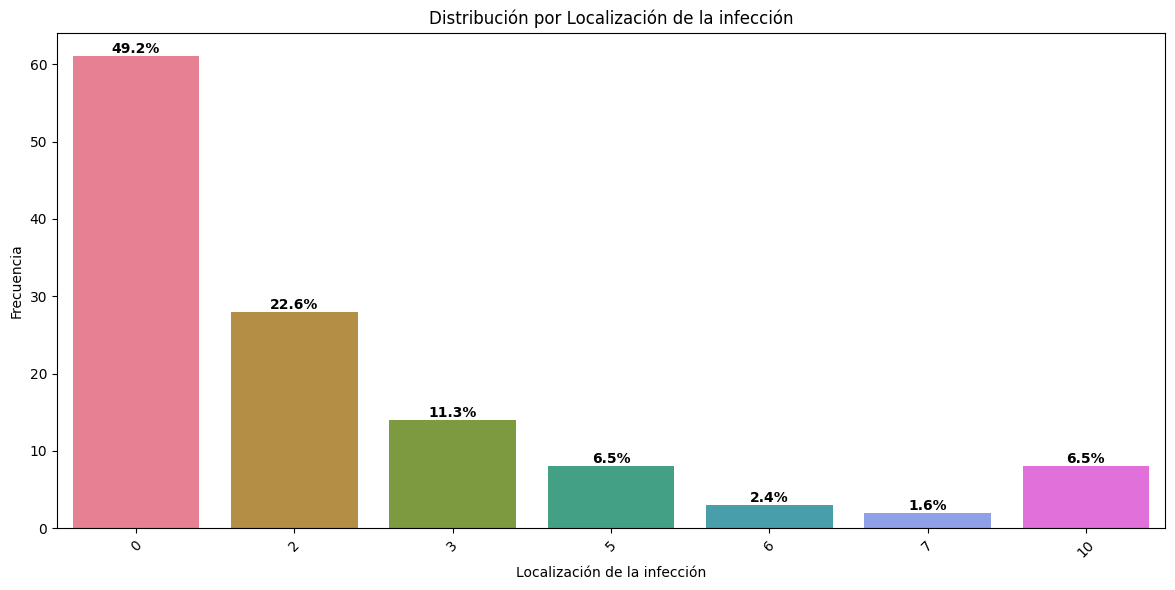

In [2304]:
graficar_var_categorica(df_clean, "Localización de la infección", "Localización de la infección", show_legend=True)

#### ``Infección_Al_Momento_Tx``
ME INDICA SI HAY O NO INFECCIÓN AL MOMENTO DEL TRANSPLANTE

{'0': 'NO', '1': 'SI'}

In [2305]:
col = "Infección_Al_Momento_Tx"

In [2306]:
df["Infección_Al_Momento_Tx"].value_counts(dropna=False)

Infección_Al_Momento_Tx
0                                                                                                                                                                461
1                                                                                                                                                                 14
TBC LATENTE                                                                                                                                                       14
1-IVU                                                                                                                                                              3
IGG TOXOPLASMA, CMV Y EBV                                                                                                                                          2
                                                                                                                                                       

In [2307]:
df.loc[~df[col].isin([0, 1]), col] = 1
df_clean.drop(columns=[col], inplace=True, errors='ignore')
df_clean.loc[:, col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
df_clean["Infección_Al_Momento_Tx"].value_counts(dropna=False)

Infección_Al_Momento_Tx
0    461
1     96
Name: count, dtype: Int64

Orden de categorías para 'Infección_Al_Momento_Tx': [0, 1]


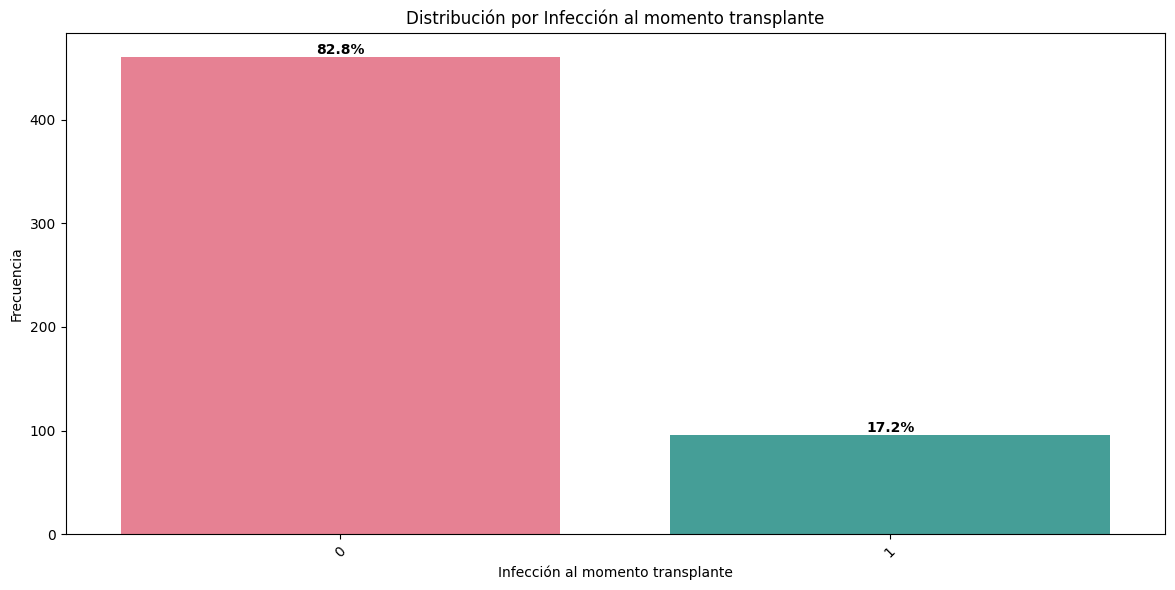

In [2308]:
graficar_var_categorica(df_clean, "Infección_Al_Momento_Tx", "Infección al momento transplante", show_legend=True)

#### ``Germen/Microorganismo aislado``
Me indica el microorganismo asociado

{
         "0": "Escherichia coli",
         "1": "Klebsiella pneumoniae ss. pneumoniae",
         "2": "Staphylococcus aureus ss. aureus",
         "3": "Candida albicans",
         "4": "Enterococcus faecalis",
         "5": "Pseudomonas aeruginosa",
         "6": "Staphylococcus epidermidis",
         "7": "Candida glabrata",
         "8": "Enterococcus faecium",
         "9": "Enterobacter cloacae",
         "10": "Proteus mirabilis",
         "11": "Staphylococcus hominis ss. hominis",
         "12": "Candida parapsilosis",
         "13": "Citrobacter freundii",
         "14": "Staphylococcus haemolyticus",
         "15": "Morganella morganii ss. morganii",
         "16": "Klebsiella oxytoca",
         "17": "Klebsiella aerogenes",
         "18": "Candida tropicalis",
         "19": "Stenotrophomonas maltophilia",
         "20": "Enterobacter asburiae",
         "21": "Acinetobacter calcoaceticus-baumannii complex",
         "22": "Streptococcus agalactiae",
         "23": "Enterococcus gallinarum",
         "24": "Enterococcus durans",
         "25": "Enterobacter sp.",
         "26": "Candida kefyr (pseudotropicalis)",
         "27": "Acinetobacter baumannii",
         "28": "Pseudomonas putida",
         "29": "Enterococcus avium",
         "30": "Serratia marcescens",
         "31": "Citrobacter amalonaticus",
         "32": "Streptococcus salivarius",
         "33": "Streptococcus mitis",
         "34": "Candida sp.",
         "35": "Staphylococcus warneri",
         "36": "Staphylococcus capitis ss. capitis",
         "37": "Streptococcus pneumoniae",
         "38": "Moraxella (Branh.) catarrhalis",
         "39": "Salmonella sp.",
         "40": "Staphylococcus lugdunensis",
         "41": "Streptococcus, beta-haem. Group B",
         "42": "Raoultella planticola",
         "43": "Klebsiella pneumoniae ss. ozaenae",
         "44": "Saccharomyces cerevisiae",
         "45": "Pseudomonas fluorescens",
         "46": "Hafnia alvei",
         "47": "Gemella morbillorum",
         "48": "Enterococcus casseliflavus",
         "49": "Citrobacter koseri (diversus)",
         "50": "Haemophilus influenzae",
         "51": "Streptococcus constellatus",
         "52": "Candida krusei",
         "53": "Erysipelothrix rhusiopathiae",
         "54": "Chryseomonas luteola",
         "55": "Pantoea agglomerans",
         "56": "Candida famata",
         "57": "Streptococcus sanguinis I",
         "58": "Acinetobacter lwoffii",
         "59": "Streptococcus intermedius",
         "60": "Staphylococcus intermedius",
         "61": "Providencia rettgeri",
         "62": "Candida intermedia",
         "63": "Streptococcus parasanguinis",
         "64": "Gemella sp.",
         "65": "Candida lusitaniae",
         "66": "Klebsiella sp.",
         "67": "Cutibacterium acnes",
         "68": "Enterococcus raffinosus",
         "69": "Enterococcus sp.",
         "70": "Lactobacillus sp.",
         "71": "Leifsonia aquatica"
      }

In [2309]:
col = "Germen/Microorganismo aislado"

In [2310]:
df_clean[col].value_counts()

Germen/Microorganismo aislado
0.0     67
1.0      5
2.0      2
7.0      1
14.0     1
23.0     1
10.0     1
Name: count, dtype: int64

In [2311]:
df[col].value_counts()

Germen/Microorganismo aislado
0.0     67
1.0      5
2.0      2
7.0      1
14.0     1
23.0     1
10.0     1
Name: count, dtype: int64

In [2312]:
#Convertir a int y vacíos a -1
s = pd.to_numeric(df[col], errors='coerce').astype("Int16").copy()
df_clean[col] = s.copy()
df_clean[col].value_counts()

Germen/Microorganismo aislado
0     67
1      5
2      2
7      1
14     1
23     1
10     1
Name: count, dtype: Int64

Orden de categorías para 'Germen/Microorganismo aislado': [0, 1, 2, 7, 10, 14, 23]


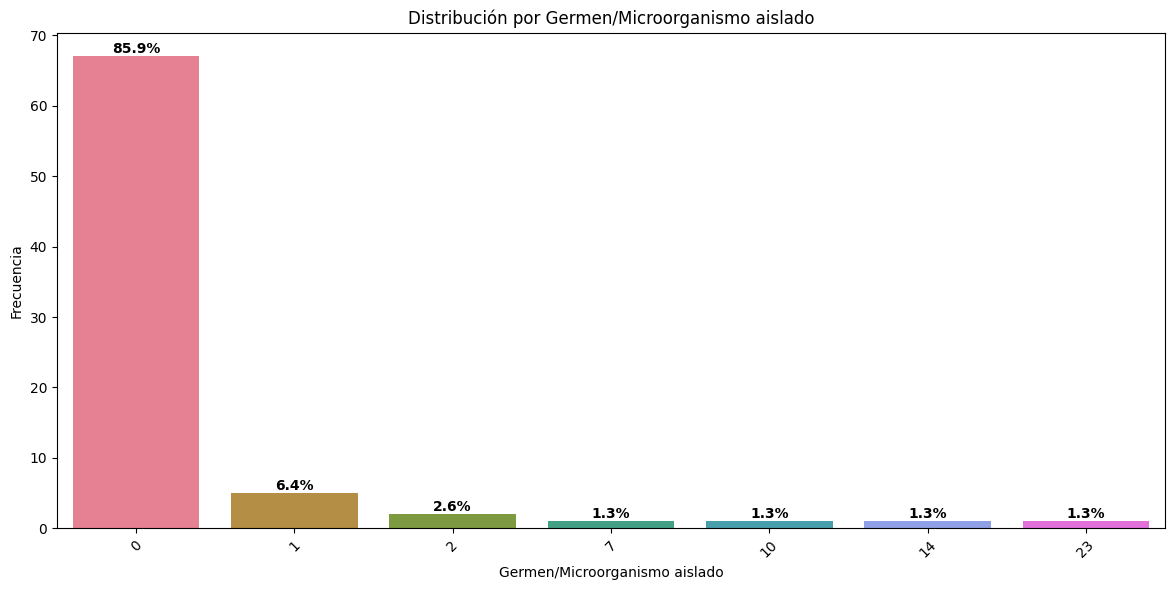

In [2313]:
graficar_var_categorica(df_clean, col, "Germen/Microorganismo aislado", show_legend=True)

#### ``Nutrición_Enteral``
DEFINE SI RECIBIÓ NUTRICIÓN ENTERAL

{'0': 'NO', '1': 'SI'}

In [2314]:
col = "Nutrición_Enteral"

In [2315]:
df[col].value_counts()

Nutrición_Enteral
0.0    514
1.0     40
Name: count, dtype: int64

In [2316]:
#Convertir a int y vacíos a -1
s = pd.to_numeric(df[col], errors='coerce').astype("Int64")
df_clean[col] = s.copy()
df_clean[col].value_counts()

Nutrición_Enteral
0    514
1     40
Name: count, dtype: Int64

Orden de categorías para 'Nutrición_Enteral': [0, 1]


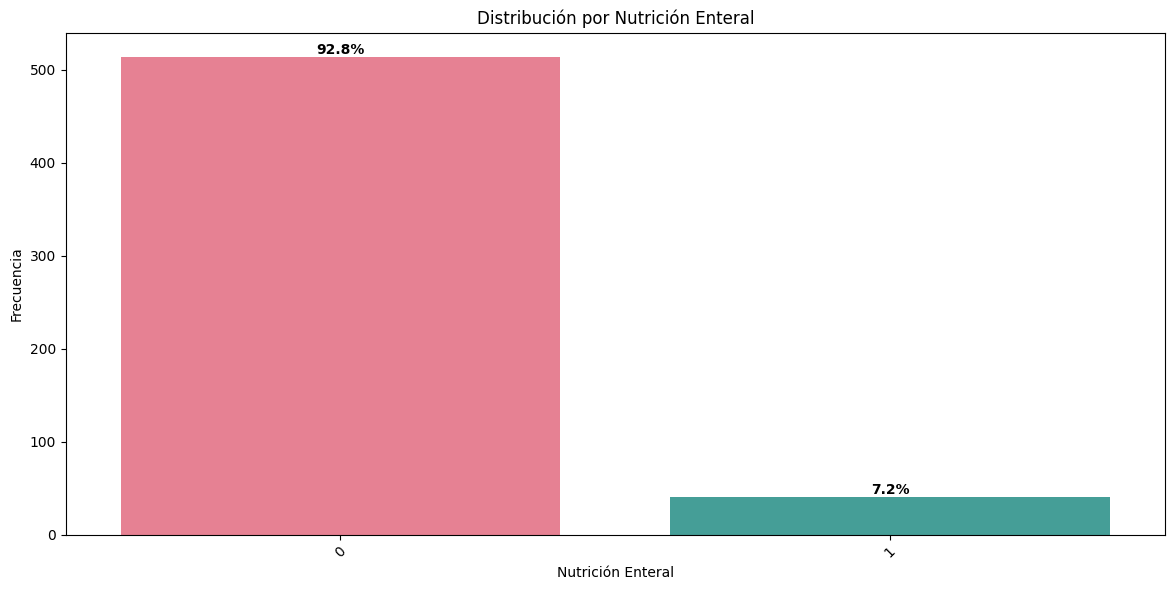

In [2317]:
graficar_var_categorica(df_clean, col, "Nutrición Enteral", show_legend=True)

#### ``Requerimiento_de_diálisis``
DEFINE SI RECIBIÓ DIÁLISIS POST OPERATORIA

{'0': 'NO', '1': 'SI'}

In [2318]:
col = "Requerimiento_de_diálisis"

In [2319]:
df[col].value_counts()

Requerimiento_de_diálisis
0               507
1                43
HEMODIALISIS      2
1 HEMO            1
Name: count, dtype: int64

In [2320]:
#Convertir a int y vacíos a -1

s = df[col].fillna(GENERAL_MISSING).copy()
# Las palabras HEMODIALISIS y HEMO indican que sí hubo diálisis
s.loc[~s.isin([0, 1, -1])] = 1
df_clean[col] = pd.to_numeric(s, errors='coerce').copy()
df_clean[col].value_counts()

Requerimiento_de_diálisis
0    507
1     50
Name: count, dtype: int64

Orden de categorías para 'Requerimiento_de_diálisis': [0, 1]


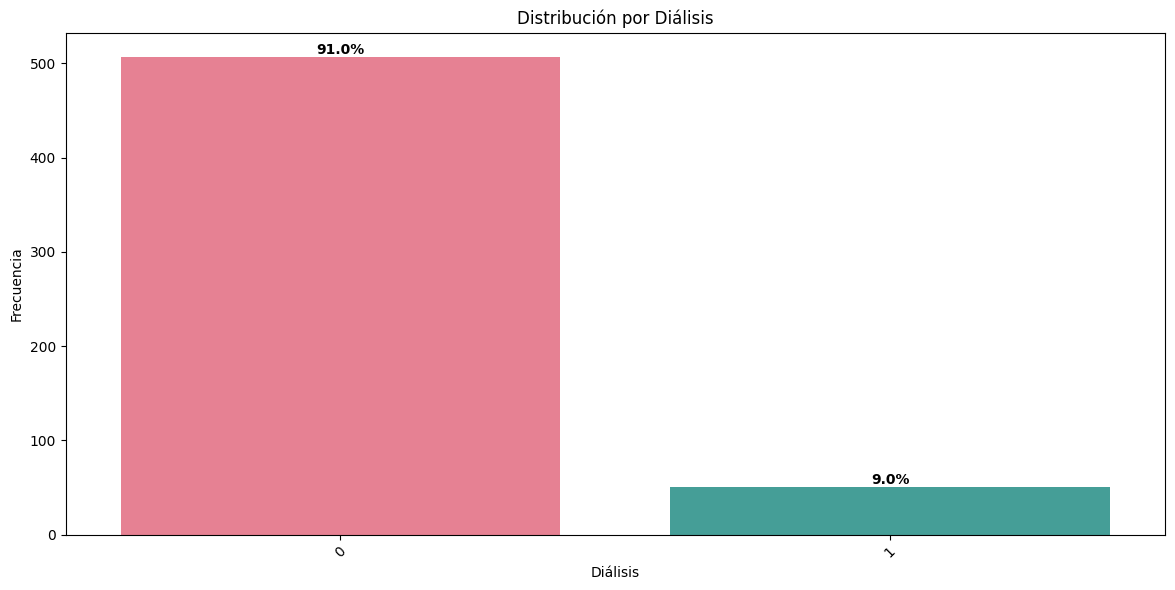

In [2321]:
graficar_var_categorica(df_clean, col, "Diálisis", show_legend=True)

#### ``Trasfusión_GRE_hasta_1m_POP``
DEFINE SI REQUIRIÓ TRASTUSIÓN POST OPERATORIA

{'0': 'NO', '1': 'SI'}

In [2322]:
col = "Trasfusión_GRE_hasta_1m_POP"
df[col].value_counts()

Trasfusión_GRE_hasta_1m_POP
0                                     507
1                                      10
4                                       7
2                                       6
3                                       4
7                                       2
8                                       2
13                                      2
5                                       1
24                                      1
6                                       1
9                                       1
17                                      1
30                                      1
10                                      1
21                                      1
1*                                      1
54                                      1
murio luego de ingresar el cateter      1
12*                                     1
23                                      1
Name: count, dtype: int64

El diccionario y el stakeholder nos indicó que la variable es binaria

In [2323]:
s = df[col]
# Las que son mayores a 1, pasarlas a 1
s.loc[~s.isin([0, 1, -1])] = 1
df_clean[col] = pd.to_numeric(s, errors='coerce').astype("Int64")
df_clean[col].value_counts()

C:\Users\esteb\AppData\Local\Temp\ipykernel_27020\1310687758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s.loc[~s.isin([0, 1, -1])] = 1


Trasfusión_GRE_hasta_1m_POP
0    507
1     50
Name: count, dtype: Int64

Orden de categorías para 'Trasfusión_GRE_hasta_1m_POP': [0, 1]


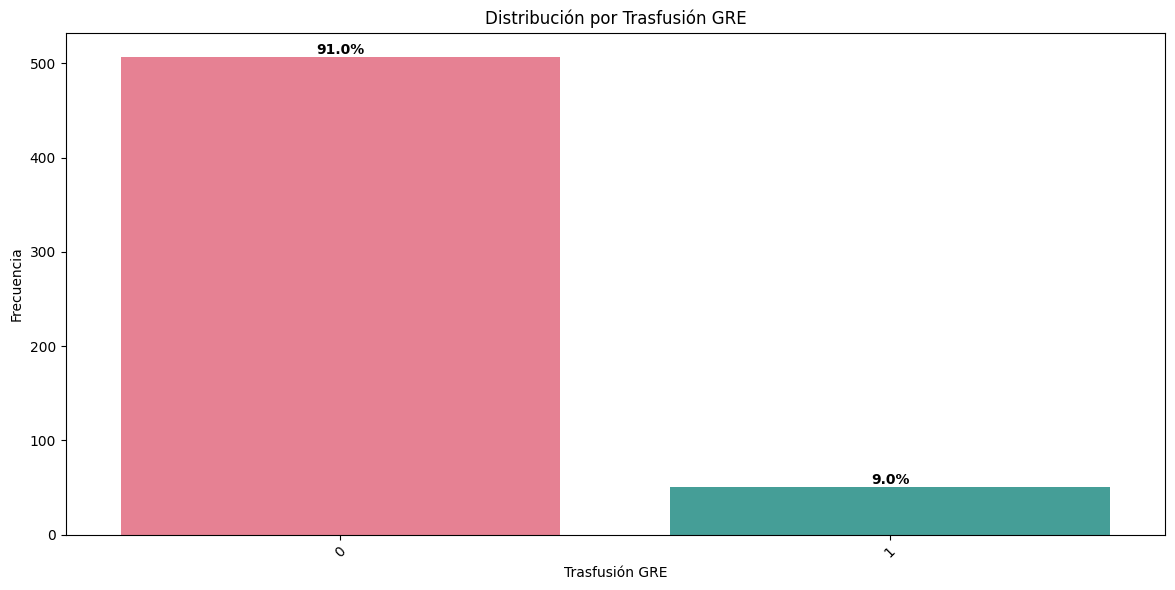

In [2324]:
graficar_var_categorica(df_clean, col, "Trasfusión GRE", show_legend=True)

#### ``Complicaciones_Técnicas``
Reporte en historia clínica de compliaciones técnicas: fuga biliar o trombosis arterial hepática

{'0': 'NO', '1': 'SI'}

In [2325]:
col = "Complicaciones_Técnicas"
df[col].value_counts()

Complicaciones_Técnicas
0                                                   402
1                                                    94
0 (cpre)                                             41
0 (drenaje percutaneo)                                2
0 (cpre?)                                             1
1 (reint + cpre)                                      1
0 (drenaje de absceso cerebral - traqueo - cpre)      1
0 (Traqueo perc)                                      1
0 (tubo de torax)                                     1
0(drenaje de colección subhepatica)                   1
0 (cpre+ derivación biliar+ traqueo)                  1
0 (toracentesis)                                      1
0 (Drenaje biliar externo- interno)                   1
0 (retrasplante a los 2 meses)                        1
0 (Drenaje colección intrabd)                         1
0 (calculo uretral)                                   1
45824                                                 1
Name: count, dtype: int6

In [2326]:
s = df[col].fillna(GENERAL_MISSING).copy()
# Las que son texto, me indican que si hubo complicaciones técnicas
s.loc[~s.isin([0, 1, -1])] = 1
df_clean[col] = pd.to_numeric(s, errors='coerce').copy()
df_clean[col].value_counts()

Complicaciones_Técnicas
0    402
1    155
Name: count, dtype: int64

Orden de categorías para 'Complicaciones_Técnicas': [0, 1]


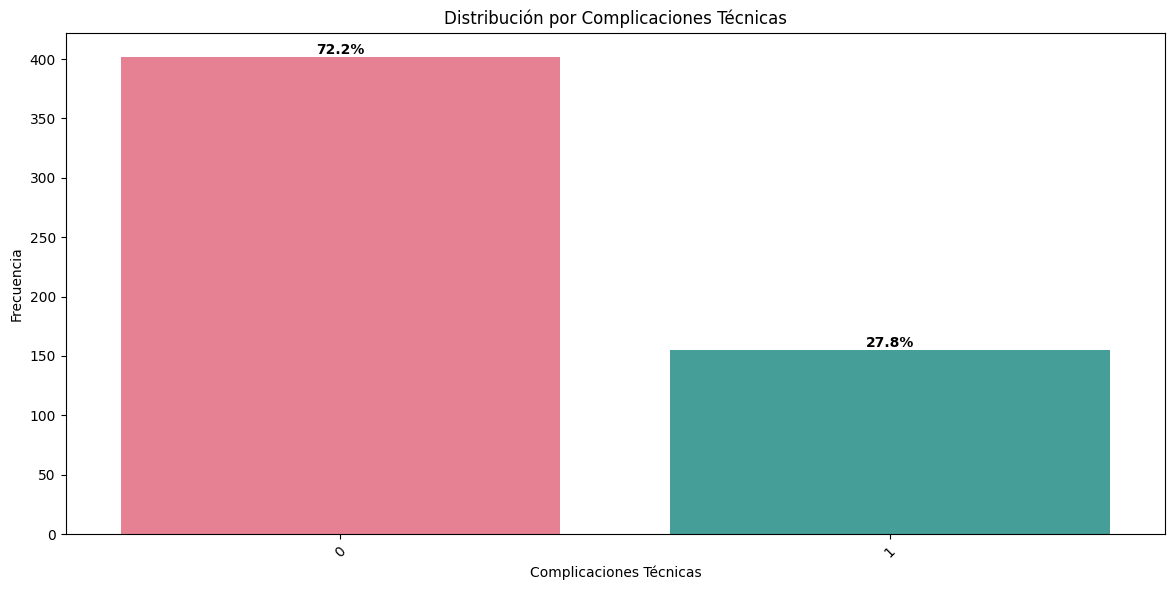

In [2327]:
graficar_var_categorica(df_clean, col, "Complicaciones Técnicas", show_legend=True)

#### `Días_Nutrición_Enteral`

In [2328]:
col = "Días_Nutrición_Enteral"
df[col].value_counts(dropna=False)

Días_Nutrición_Enteral
0.0     513
15.0      4
NaN       4
2.0       4
4.0       4
13.0      3
7.0       2
3.0       2
10.0      2
5.0       2
35.0      2
20.0      1
36.0      1
14.0      1
11.0      1
19.0      1
21.0      1
25.0      1
6.0       1
28.0      1
8.0       1
17.0      1
1.0       1
22.0      1
54.0      1
24.0      1
Name: count, dtype: int64

In [2329]:
#Convertir a int

s = pd.to_numeric(df[col], errors='coerce')
s = np.ceil(s).mask(s > 10000, np.nan).astype("Int32")

df_clean.drop(columns=["Días_Nutrición_Enteral"], inplace=True, errors='ignore')
df_clean.loc[:, "Días_Nutrición_Enteral"] = s
df_clean["Días_Nutrición_Enteral"].value_counts(dropna=False).sort_index()


Días_Nutrición_Enteral
0       513
1         1
2         4
3         2
4         4
5         2
6         1
7         2
8         1
10        2
11        1
13        3
14        1
15        4
17        1
19        1
20        1
21        1
22        1
24        1
25        1
28        1
35        2
36        1
54        1
<NA>      4
Name: count, dtype: Int64

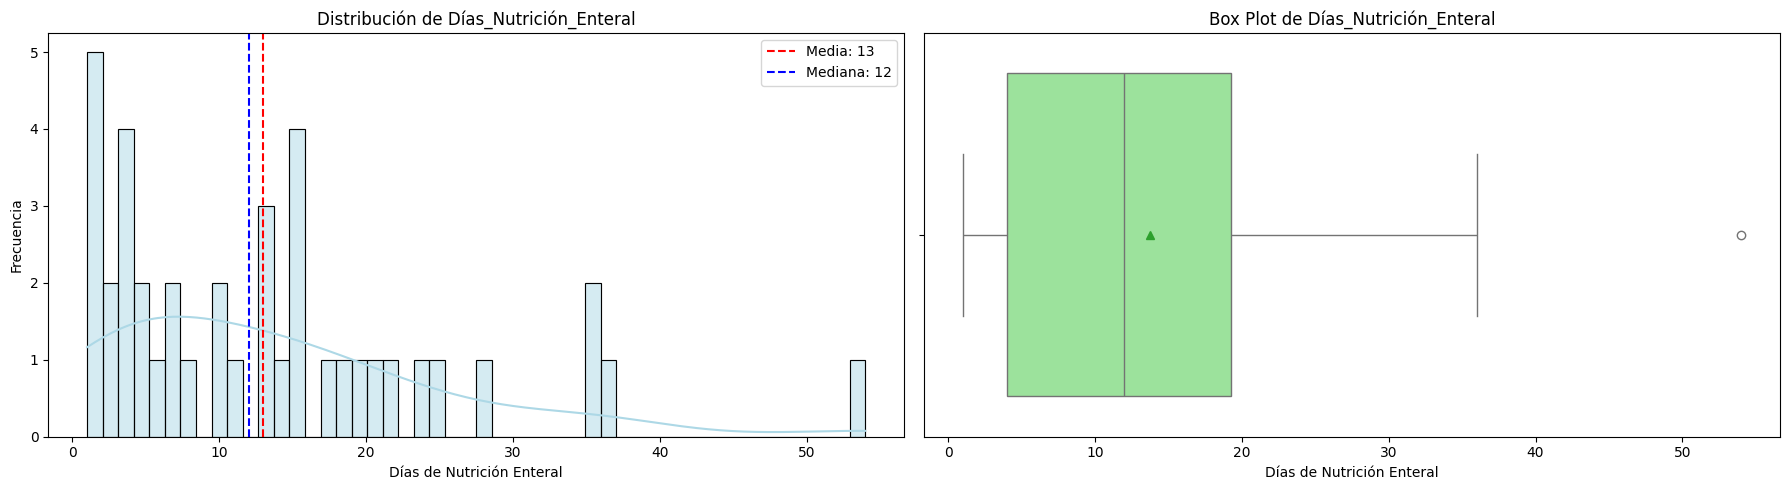

In [2330]:
graficar_var_numerica(df_clean[df_clean[col] > 0], col, "Días de Nutrición Enteral")

#### ``Días_En_UCI_POP``
DÍAS EN UCI POST TRANSPLANTE

Numerica

In [2331]:
col = "Días_En_UCI_POP"
df[col].value_counts()

Días_En_UCI_POP
2        121
1        118
3         65
0         50
4         48
        ... 
45386      1
3*         1
45488      1
35553      1
45581      1
Name: count, Length: 94, dtype: int64

Dado que hay registros cuyo valor es de más de 40.000, lo que corresponde a más de 100 años, y esto es imposible, se van a mapear como si estuvieran vacías.

In [2332]:
#Convertir a int
s = pd.to_numeric(df[col], errors='coerce')
s = np.ceil(s).mask(s > 365*20, np.nan).astype("Int32")
df_clean.drop(columns=["Días_En_UCI_POP"], inplace=True, errors='ignore')
df_clean.loc[:, "Días_En_UCI_POP"] = s
df_clean.loc[:, "Días_En_UCI_POP"]

0         3
1         1
2         7
3         5
4         3
       ... 
552       0
553    <NA>
554       0
555       0
556    <NA>
Name: Días_En_UCI_POP, Length: 557, dtype: Int32

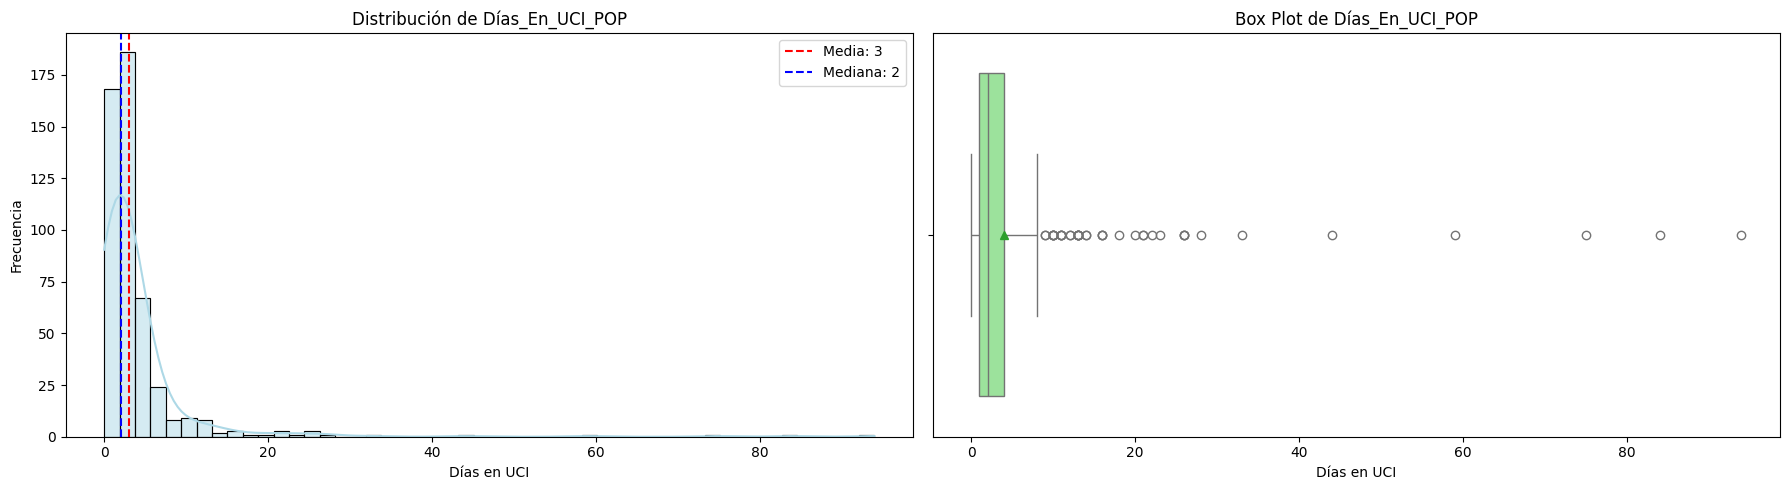

In [2333]:
graficar_var_numerica(df_clean, col, "Días en UCI")

#### ``Días_En_Hospitalización_Piso``
DÍAS EN PISO POST TRANSPLANTE

Numerica

In [2334]:
col = "Días_En_Hospitalización_Piso"
df[col].value_counts()

Días_En_Hospitalización_Piso
4.0        68
7.0        53
5.0        52
8.0        47
6.0        42
0.0        42
3.0        37
9.0        37
2.0        21
10.0       19
13.0       18
11.0       17
12.0       15
16.0        9
15.0        8
17.0        6
14.0        6
1.0         6
18.0        5
25.0        5
21.0        5
30.0        4
20.0        4
19.0        3
32.0        2
23.0        2
22.0        2
24.0        2
29.0        2
41.0        2
28.0        2
43.0        1
55.0        1
26.0        1
49.0        1
27.0        1
35.0        1
31.0        1
36.0        1
45.0        1
44800.0     1
44939.0     1
45001.0     1
39.0        1
Name: count, dtype: int64

In [2335]:
#Convertir a int
s = pd.to_numeric(df[col], errors='coerce')
s = np.ceil(s)                                      # aplica techo
s = s.mask(s > 10000, np.nan)
df_clean[col] = s.astype("Int16")  
df_clean[col].value_counts(dropna = False)

Días_En_Hospitalización_Piso
4       68
7       53
5       52
8       47
0       42
6       42
9       37
3       37
2       21
10      19
13      18
11      17
12      15
16       9
15       8
14       6
1        6
17       6
21       5
25       5
18       5
20       4
<NA>     4
30       4
19       3
32       2
28       2
23       2
24       2
22       2
29       2
41       2
49       1
43       1
26       1
55       1
27       1
35       1
36       1
31       1
45       1
39       1
Name: count, dtype: Int64

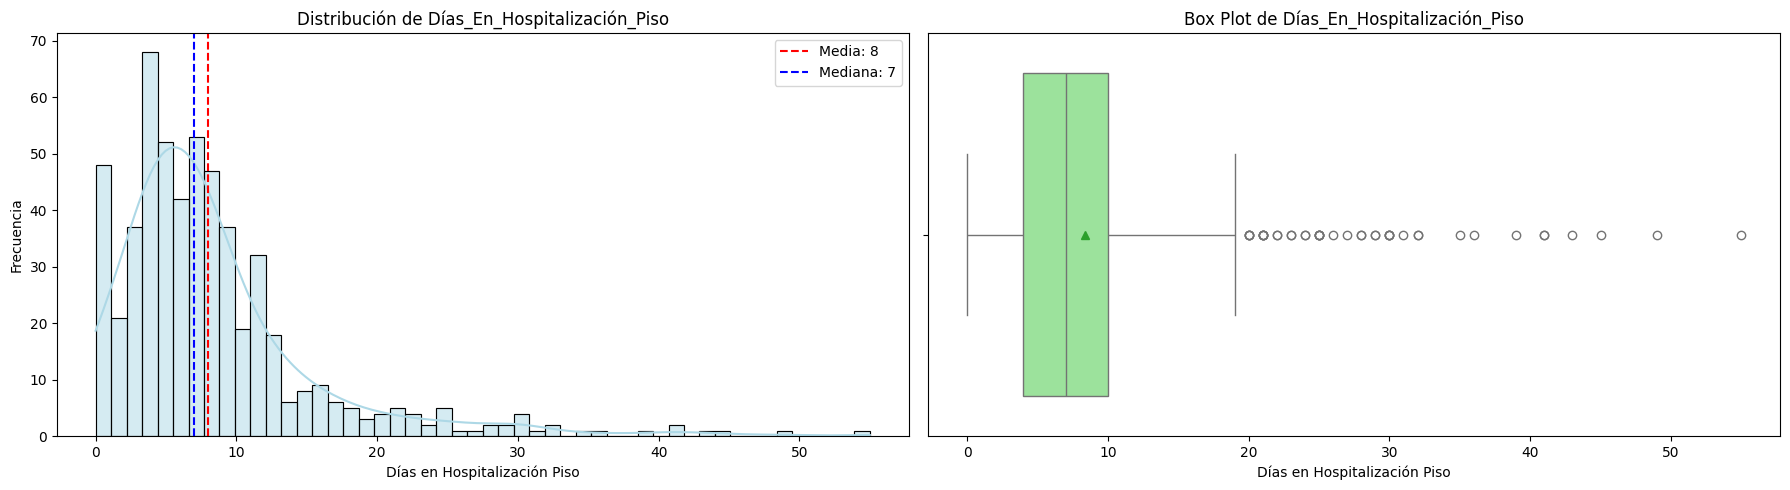

In [2336]:
graficar_var_numerica(df_clean, col, "Días en Hospitalización Piso")

#### ``Días_Totales_Intrahospitalarios``
DÍAS TOTALES POST TRANSPLANTE

Numerica

In [2337]:
col = "Días_Totales_Intrahospitalarios"
df[col].value_counts()

Días_Totales_Intrahospitalarios
6        45
7        43
8        38
9        38
10       36
         ..
35578     1
45540     1
45557     1
45576     1
45592     1
Name: count, Length: 150, dtype: int64

In [2338]:
#Convertir a int
s = pd.to_numeric(df[col], errors='coerce')
s = np.ceil(s).mask(s > 10000, np.nan).astype("Int16") 
df_clean.drop(columns=[col], inplace=True, errors='ignore')
df_clean.loc[:, col] = s

In [2339]:
df_clean.loc[:, col].value_counts(dropna = False).sort_index()

Días_Totales_Intrahospitalarios
0         4
1         6
2         3
3         7
4        21
5        31
6        45
7        43
8        38
9        38
10       36
11       22
12       22
13       14
14       16
15       10
16       15
17        8
18        8
19        5
20        2
21        3
22        9
23        6
24        3
25        1
26        1
27        3
28        1
30        4
31        1
33        3
34        4
36        1
37        1
39        1
41        2
43        2
44        2
46        1
47        1
52        1
54        2
58        1
59        1
75        1
91        1
94        1
<NA>    105
Name: count, dtype: Int64

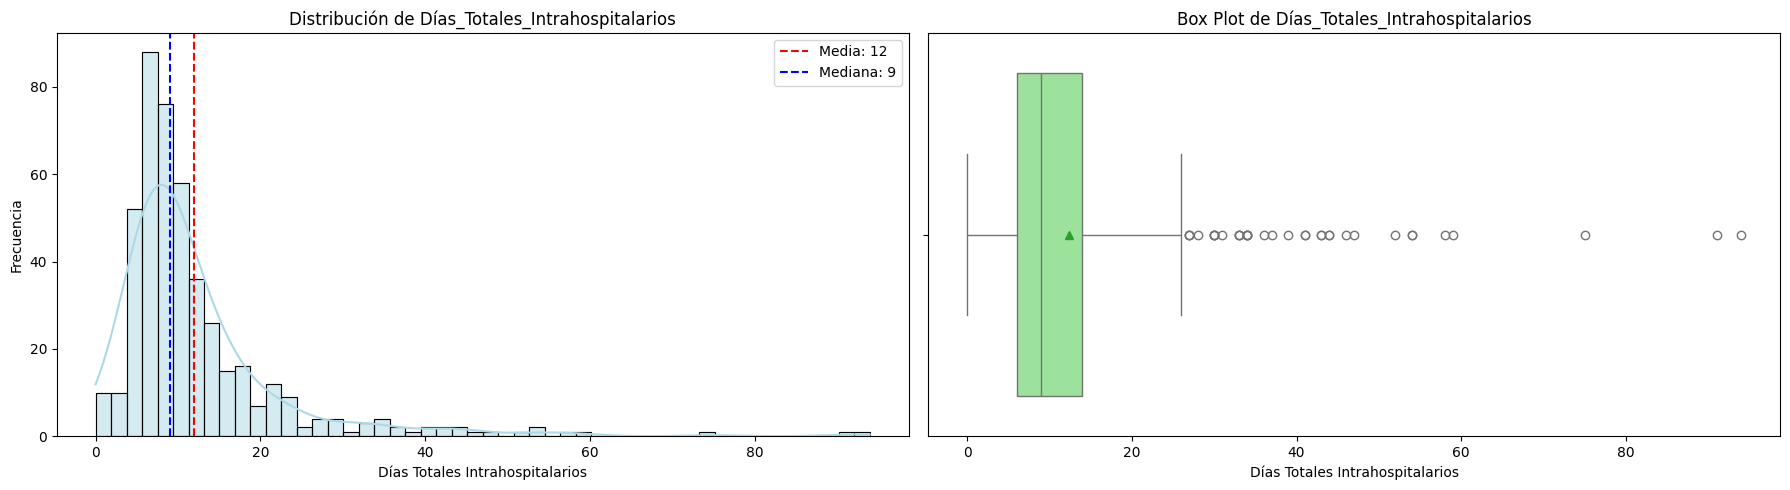

In [2340]:
graficar_var_numerica(df_clean, col, "Días Totales Intrahospitalarios")

#### ``Fecha_Egreso_UCI``
Fecha de egreso de la UCI
Date

In [2341]:
df[col].dtype

dtype('O')

In [2342]:
col = "Fecha_Egreso_UCI"
df[col].value_counts()

Fecha_Egreso_UCI
2010-07-12    2
2010-04-29    2
2010-09-22    2
2017-11-09    2
2009-10-24    1
             ..
2024-04-26    1
2024-05-25    1
2024-08-08    1
2024-09-17    1
2024-11-03    1
Name: count, Length: 124, dtype: int64

In [2343]:
# format as just date
df_clean.drop(columns = col, inplace=True, errors='ignore')
df_clean.loc[:,"Fecha_Egreso_UCI"] = pd.to_datetime(df["Fecha_Egreso_UCI"]).dt.date.astype('datetime64[ns]')


In [2344]:
df_clean["Fecha_Egreso_UCI"]

0            NaT
1            NaT
2            NaT
3            NaT
4            NaT
         ...    
552          NaT
553          NaT
554          NaT
555          NaT
556   2024-11-03
Name: Fecha_Egreso_UCI, Length: 557, dtype: datetime64[ns]

#### ``Fecha_Egreso_Hospitalario``
Fecha de egreso hospitalización general

Date

In [2345]:
col = "Fecha_Egreso_Hospitalario"
df[col].value_counts()

Fecha_Egreso_Hospitalario
2010-01-12    2
2009-07-16    2
2022-02-12    2
2017-11-10    2
2023-01-28    2
             ..
2024-08-08    1
2024-09-11    1
2024-09-27    1
2024-10-25    1
2024-11-14    1
Name: count, Length: 180, dtype: int64

In [2346]:
# format as just date
df_clean.drop(columns = col, inplace=True, errors='ignore')
df_clean["Fecha_Egreso_Hospitalario"] = pd.to_datetime(df["Fecha_Egreso_Hospitalario"]).dt.date.astype('datetime64[ns]')
df_clean[col]

0            NaT
1            NaT
2            NaT
3            NaT
4            NaT
         ...    
552   2024-09-27
553          NaT
554   2024-10-12
555   2024-10-25
556   2024-11-14
Name: Fecha_Egreso_Hospitalario, Length: 557, dtype: datetime64[ns]

#### ``Retrasplante``
DEFINE SI REQUIRIÓ RETRANSPLANTE

{'0': 'NO', '1': 'SI'}

In [2347]:
col = "Retrasplante"
df[col].value_counts()

Retrasplante
0.0    513
1.0     42
Name: count, dtype: int64

In [2348]:
#Convertir a int y vacíos a -1
s = pd.to_numeric(df[col], errors='coerce').astype("Int16").copy()
df_clean[col] = s.copy()
df_clean[col].value_counts()

Retrasplante
0    513
1     42
Name: count, dtype: Int64

Orden de categorías para 'Retrasplante': [0, 1]


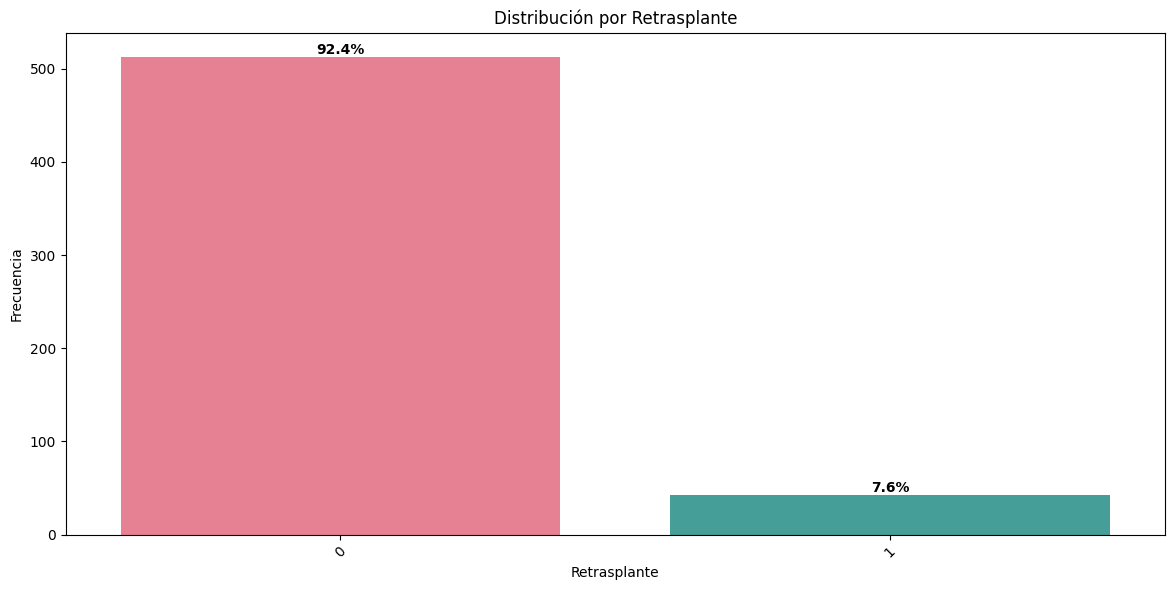

In [2349]:
graficar_var_categorica(df_clean, col, "Retrasplante", show_legend=True)

## Grupo 4 — Estancias globales, inmunosupresión y desenlaces
Inmunosupresor_1_Postx; Inmunosupresor_2_PostTx; Inmunosupresión_con_Anticuerpos; Inmunosupresor_1_1mesPostTx; Inmunosupresor_2_PostTx_1mesPx; Inmunosupresor_1_6mesesPostx; Inmunosupresor_2_6mesesPostTx; Vivo_Hoy; Fecha_Control/Muerte; SOBREVIDA_DIAS; SOBREVIDA_MESES; SOBREVIDA_AÑOS; Dias_Estancia_Hospitalaria; Días_Hospitalización_UCI.

In [2350]:
estancias_globales = [
    "Inmunosupresor_1_Postx",
    "Inmunosupresor_2_PostTx",
    "Inmunosupresión_con_Anticuerpos",
    "Inmunosupresor_1_1mesPostTx",
    "Inmunosupresor_2_PostTx_1mesPx",
    "Inmunosupresor_1_6mesesPostx",
    "Inmunosupresor_2_6mesesPostTx",
    "Vivo_Hoy",
    "Fecha_Control/Muerte",
    "SOBREVIDA_DIAS",
    "SOBREVIDA_MESES",
    "SOBREVIDA_AÑOS",
    "Dias_Estancia_Hospitalaria",
    "Días_Hospitalización_UCI"
]

#### ``Inmunosupresor_1_Postx``
INMUNOSUPRESOR BASAL POST TRASPLANTE

{'0': 'No', '1': 'CICLOSPORINA', '2': 'TACROLIMUS', '3': 'SIROLIMUS'}

In [2351]:
df["Inmunosupresor_1_Postx"].value_counts(dropna=False)

Inmunosupresor_1_Postx
1       346
2       193
9999     11
0         4
3         1
/         1
NaN       1
Name: count, dtype: int64

In [2352]:
s = df["Inmunosupresor_1_Postx"].copy()
# Identificar no aplica
mask = s.isin([9999])
s[mask] = NO_APLICA
# el resto de valores se castean a nan

df_clean["Inmunosupresor_1_Postx"] = pd.to_numeric(s, errors="coerce").astype("Int64")

In [2353]:
df_clean["Inmunosupresor_1_Postx"].value_counts(dropna=False)

Inmunosupresor_1_Postx
1       346
2       193
<NA>     13
0         4
3         1
Name: count, dtype: Int64

Orden de categorías para 'Inmunosupresor_1_Postx': [0, 1, 2, 3]


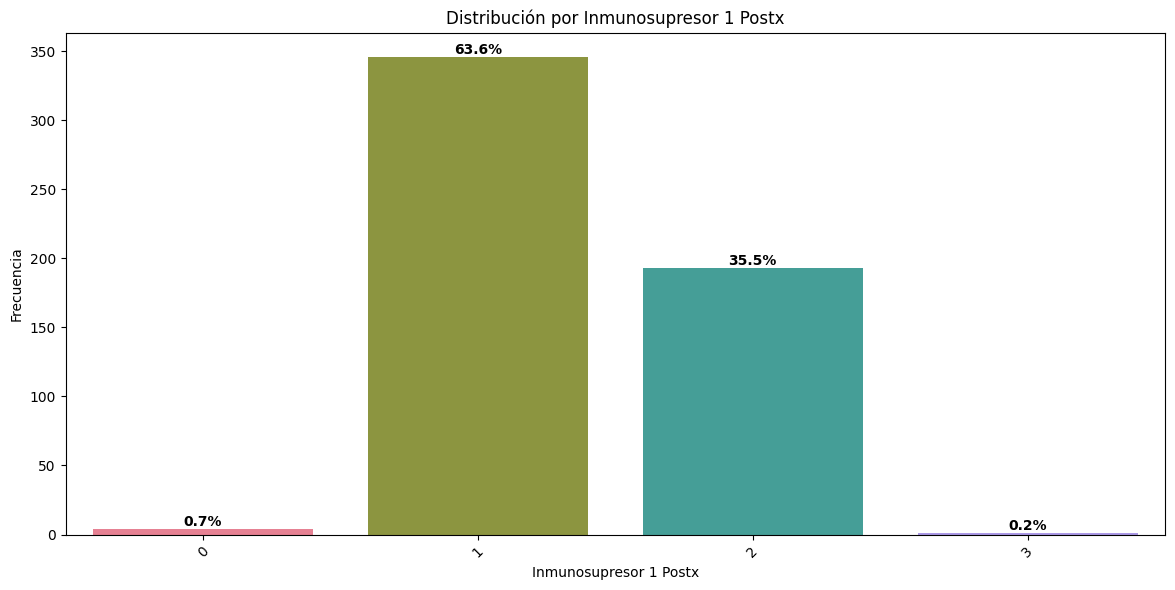

In [2354]:
graficar_var_categorica(df_clean, "Inmunosupresor_1_Postx", "Inmunosupresor 1 Postx", show_legend=True)

#### ``Inmunosupresor_2_PostTx``
INMUNOSUPRESOR AÑADIDO POSTRASPLANTE

{'0': 'No', '1': 'MICOFENOLATO', '2': 'AZATIOPRINA'}

In [2355]:
df["Inmunosupresor_2_PostTx"].value_counts(dropna=False).sort_index()

Inmunosupresor_2_PostTx
0.0         7
1.0       536
2.0         1
9999.0     11
NaN         2
Name: count, dtype: int64

In [2356]:
s = df["Inmunosupresor_2_PostTx"].copy()
# Identificar no aplica
mask = s.isin([9999])
s = s.where(~mask, NO_APLICA)

# el resto de valores se castean a nan
s = pd.to_numeric(s, errors="coerce").astype("Int64")

df_clean["Inmunosupresor_2_PostTx"] = s.copy()

Orden de categorías para 'Inmunosupresor_2_PostTx': [0, 1, 2]


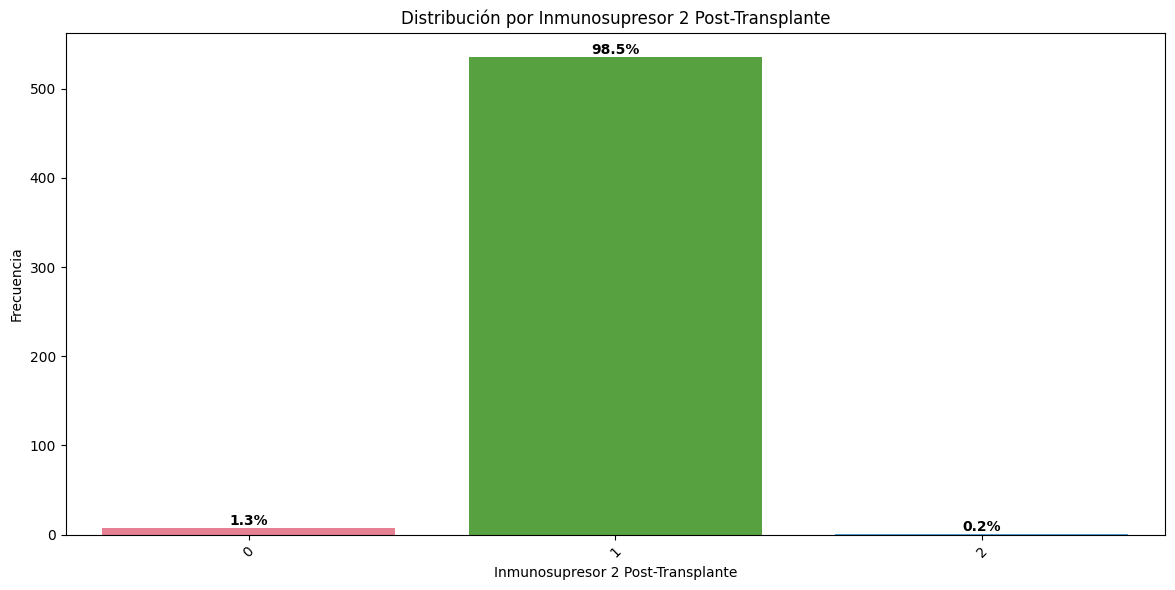

In [2357]:
graficar_var_categorica(df_clean, "Inmunosupresor_2_PostTx", "Inmunosupresor 2 Post-Transplante", show_legend=True)

#### ``Inmunosupresión_con_Anticuerpos	``

INMUNOSUPRESIÓN CON ANTICUERPOS RECOMBINADOS POSTRASPLANTE

{'0': 'No', '1': 'SIMULECT (BASILIXIMAB)', '2': 'ZENAPAX (DACLIZUMAB)', '3': 'OKT3 (ORTHOCLONE)', '4': 'TIMOGLOBULINA'}	Categorical

In [2358]:
df["Inmunosupresión_con_Anticuerpos"].value_counts(dropna=False)

Inmunosupresión_con_Anticuerpos
9999.0    360
0.0       171
1.0        19
NaN         7
Name: count, dtype: int64

In [2359]:
s = df["Inmunosupresión_con_Anticuerpos"].copy()
mask_no_aplica = s.isin([9999.0])
s[mask_no_aplica] = NO_APLICA
s = pd.to_numeric(s, errors="coerce").astype("Int64")
df_clean["Inmunosupresión_con_Anticuerpos"] = s.copy()

Orden de categorías para 'Inmunosupresión_con_Anticuerpos': [0, 1]


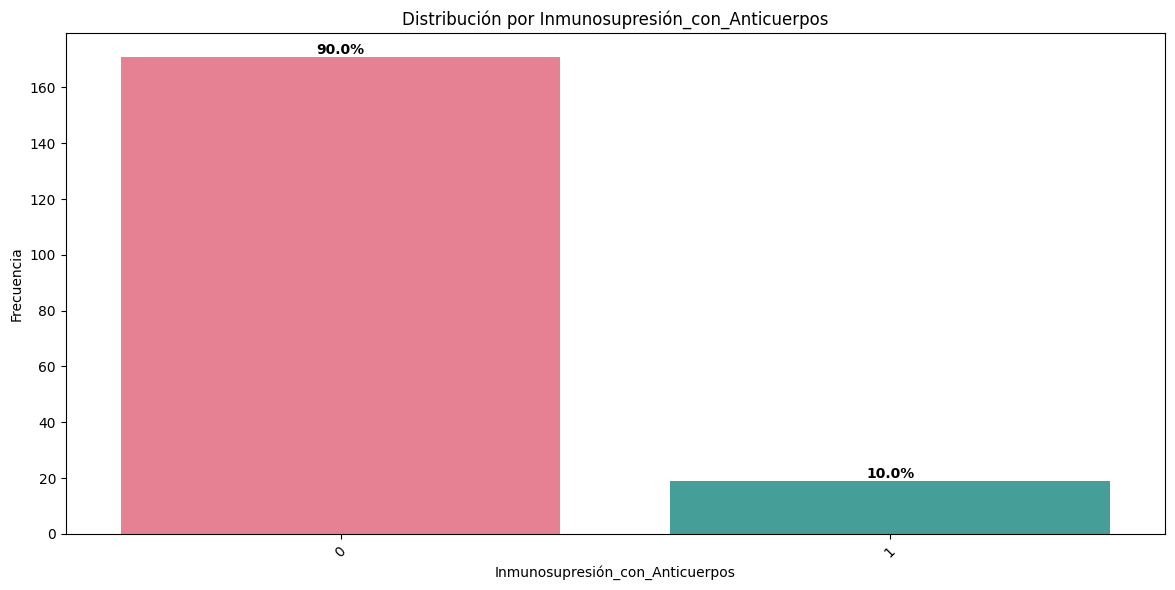

In [2360]:
graficar_var_categorica(df_clean, "Inmunosupresión_con_Anticuerpos")

#### ``Inmunosupresor_1_1mesPostTx``

INMUNOSUPRESOR BASAL 1 MES POST TX

{'0': 'No', '1': 'CICLOSPORINA', '2': 'TACROLIMUS', '3': 'SIROLIMUS'}

In [2361]:
df["Inmunosupresor_1_1mesPostTx"].value_counts(dropna=False)

Inmunosupresor_1_1mesPostTx
1.0       281
2.0       224
9999.0     33
0.0        10
NaN         8
3.0         1
Name: count, dtype: int64

In [2362]:
s = df["Inmunosupresor_1_1mesPostTx"].copy()
mask_no_aplica = s.isin([9999.0])
s[mask_no_aplica] = NO_APLICA
s = pd.to_numeric(s, errors="coerce").astype("Int64")
df_clean["Inmunosupresor_1_1mesPostTx"] = s.copy()

Orden de categorías para 'Inmunosupresor_1_1mesPostTx': [0, 1, 2, 3]


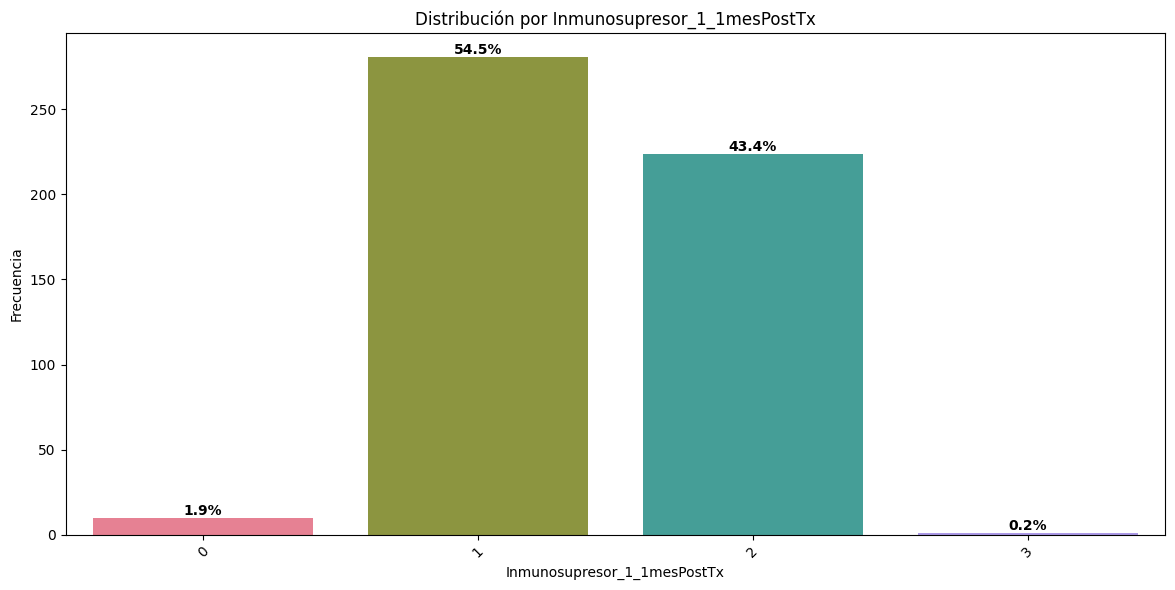

In [2363]:
graficar_var_categorica(df_clean, "Inmunosupresor_1_1mesPostTx", show_legend=True)

#### ``Inmunosupresor_2_PostTx_1mesPx``

INMUNOSUPRESOR AÑADIDO 1 MES POST TX

{'0': 'No', '1': 'MICOFENOLATO', '2': 'AZATIOPRINA'}

In [2364]:
col = "Inmunosupresor_2_PostTx_1mesPx"
df[col].value_counts(dropna=False)


Inmunosupresor_2_PostTx_1mesPx
1.0       494
9999.0     33
0.0        22
NaN         8
Name: count, dtype: int64

In [2365]:
s = df[col].copy()
mask_no_aplica = s.isin([9999.0, 9999])
s[mask_no_aplica] = NO_APLICA
df_clean[col] = pd.to_numeric(s, errors="coerce").astype("Int64")

In [2366]:
df_clean[col].value_counts(dropna=False)

Inmunosupresor_2_PostTx_1mesPx
1       494
<NA>     41
0        22
Name: count, dtype: Int64

Orden de categorías para 'Inmunosupresor_2_PostTx_1mesPx': [0, 1]


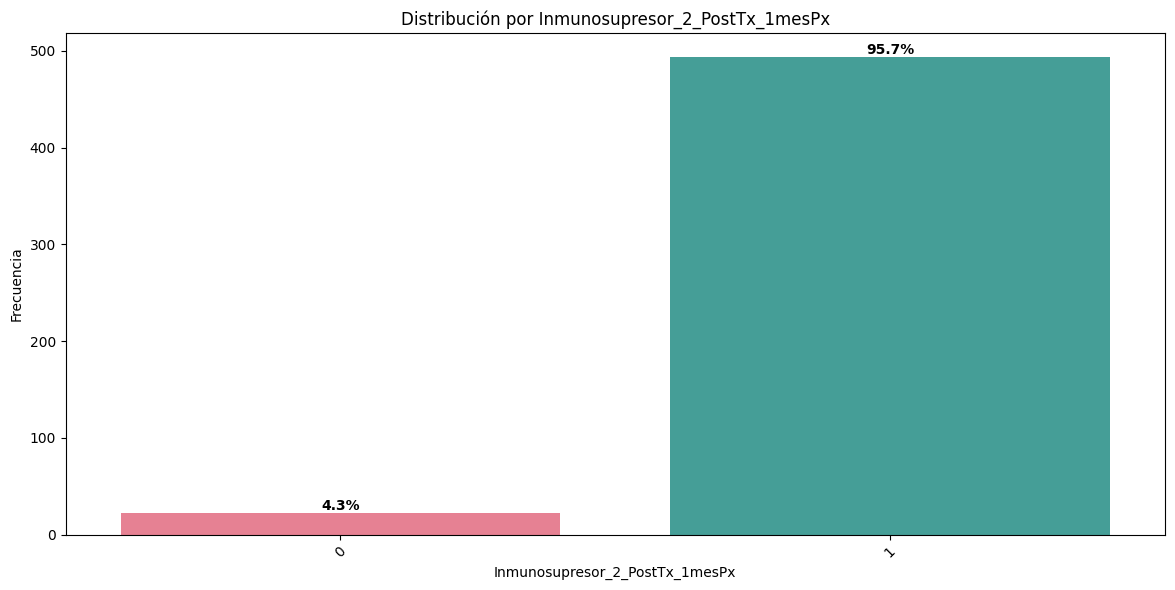

In [2367]:
graficar_var_categorica(df_clean, col)

#### ``Inmunosupresor_1_6mesesPostx``

INMUNOSUPRESOR BASAL 6 MES POST TX

{'0': 'No', '1': 'CICLOSPORINA', '2': 'TACROLIMUS', '3': 'SIROLIMUS'}

In [2368]:
df["Inmunosupresor_1_6mesesPostx"].value_counts(dropna=False)

Inmunosupresor_1_6mesesPostx
2.0       261
1.0       220
9999.0     56
NaN        11
3.0         5
0.0         4
Name: count, dtype: int64

In [2369]:
s = df["Inmunosupresor_1_6mesesPostx"].copy()
mask_no_aplica = s.isin([9999.0, 9999])
s[mask_no_aplica] = NO_APLICA
df_clean["Inmunosupresor_1_6mesesPostx"] = pd.to_numeric(s, errors="coerce").astype("Int64")

Orden de categorías para 'Inmunosupresor_1_6mesesPostx': [0, 1, 2, 3]


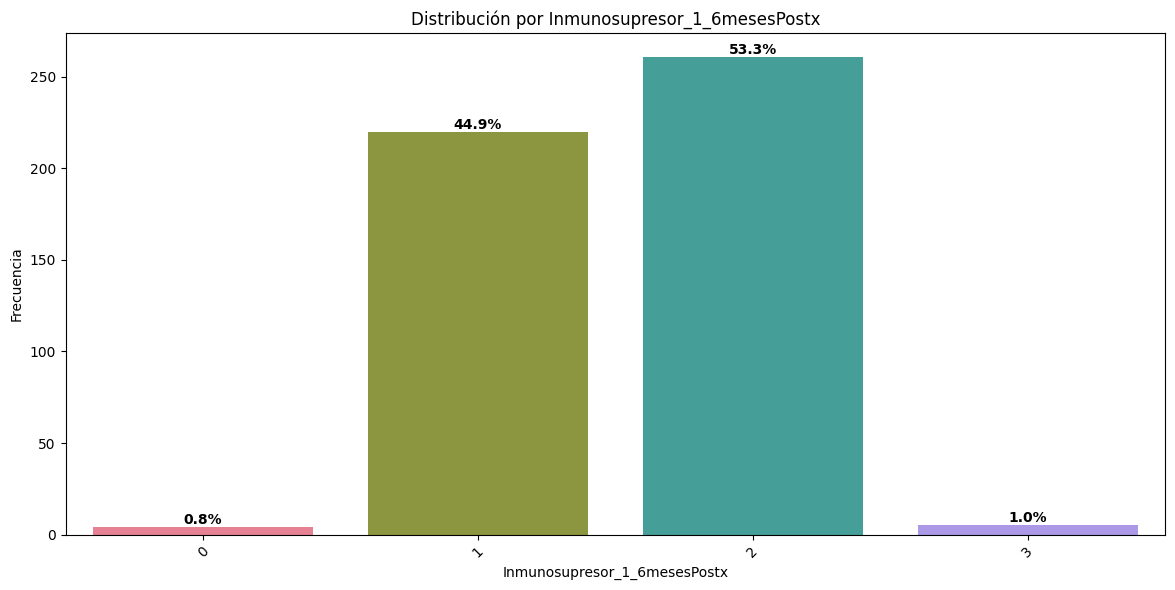

In [2370]:
graficar_var_categorica(df_clean, "Inmunosupresor_1_6mesesPostx", show_legend=True)


#### ``Inmunosupresor_2_6mesesPostTx``

INMUNOSUPRESOR AÑADIDO 6 MES POST TX

{'0': 'No', '1': 'MICOFENOLATO', '2': 'AZATIOPRINA'}

In [2371]:
df["Inmunosupresor_2_6mesesPostTx"].value_counts(dropna=False)

Inmunosupresor_2_6mesesPostTx
1.0       425
0.0        60
9999.0     57
NaN        11
2.0         4
Name: count, dtype: int64

In [2372]:
s = df["Inmunosupresor_2_6mesesPostTx"].copy()
mask_no_aplica = s.isin([9999.0])
s[mask_no_aplica] = NO_APLICA
df_clean["Inmunosupresor_2_6mesesPostTx"] = pd.to_numeric(s, errors="coerce").astype("Int64")

In [2373]:
df_clean["Inmunosupresor_2_6mesesPostTx"].value_counts(dropna=False)

Inmunosupresor_2_6mesesPostTx
1       425
<NA>     68
0        60
2         4
Name: count, dtype: Int64

Orden de categorías para 'Inmunosupresor_2_6mesesPostTx': [0, 1, 2]


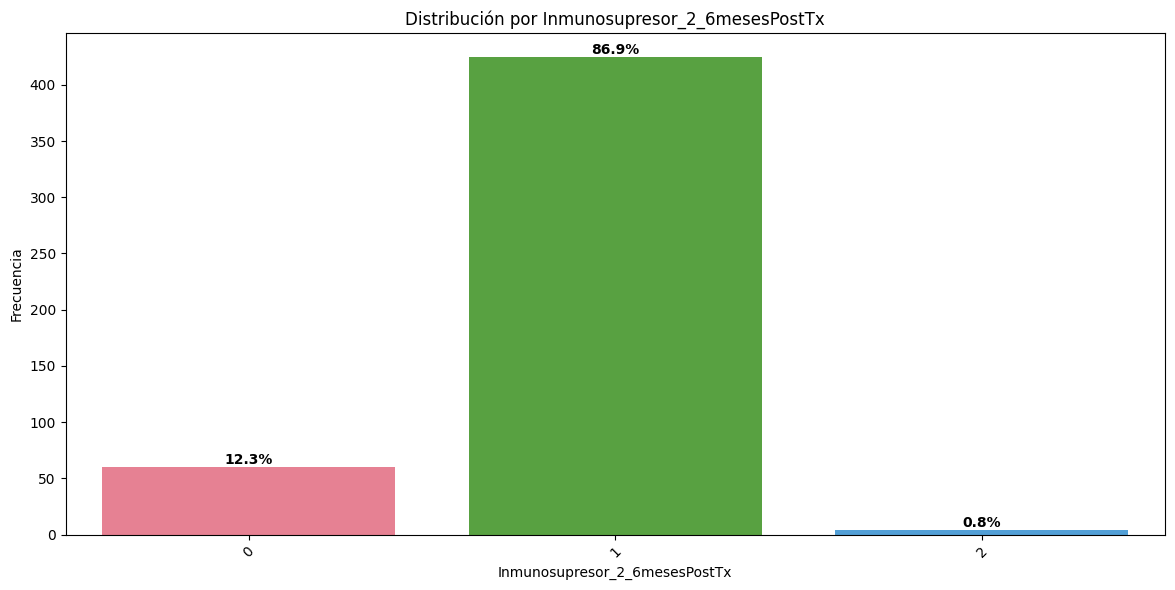

In [2374]:
graficar_var_categorica(df_clean, "Inmunosupresor_2_6mesesPostTx", show_legend=True)

``Vivo_Hoy``

Define Si está vivo hoy

{'0': 'NO', '1': 'SI'}


In [2375]:
df["Vivo_Hoy"].value_counts(dropna=False)

Vivo_Hoy
1    395
0    162
Name: count, dtype: int64

Orden de categorías para 'Vivo_Hoy': [0, 1]


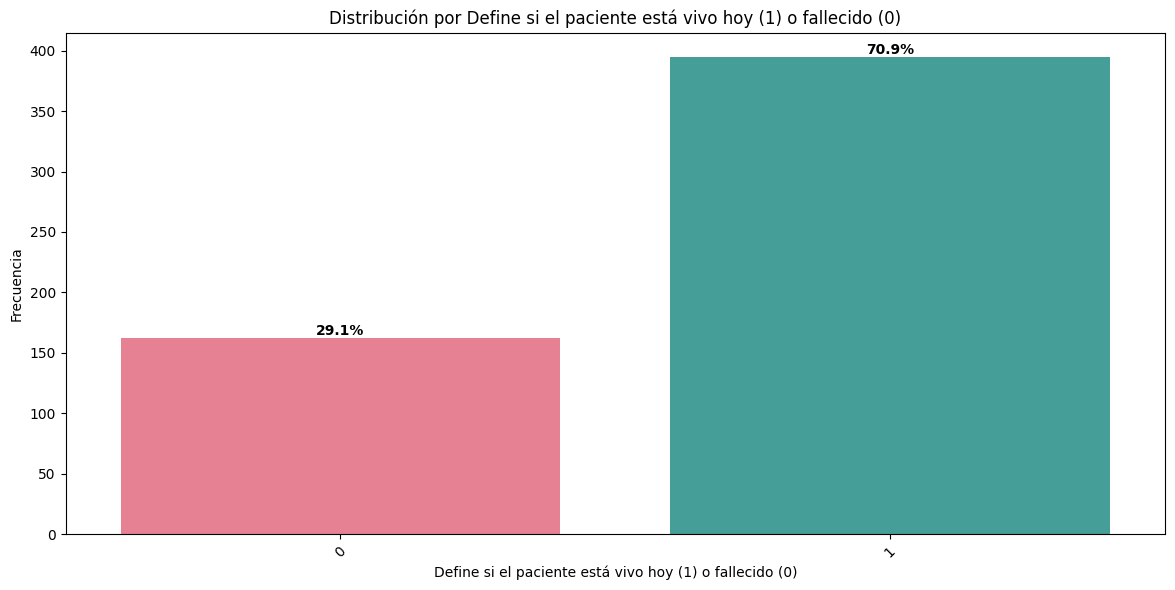

In [2376]:
graficar_var_categorica(df_clean, "Vivo_Hoy", "Define si el paciente está vivo hoy (1) o fallecido (0)")

#### ``Fecha_Control/Muerte``


In [2377]:
df["Fecha_Control/Muerte"].isna().sum()

np.int64(0)

In [2378]:
df["Fecha_Control/Muerte"].value_counts(dropna=False)

Fecha_Control/Muerte
2023-12-31    314
2025-05-13      4
2025-03-19      3
2025-03-27      3
2025-03-25      3
             ... 
2025-04-25      1
2025-05-02      1
2024-09-21      1
2025-03-31      1
2025-05-07      1
Name: count, Length: 215, dtype: int64

In [2379]:
# format as just date
df_clean.loc[:, "Fecha_Control/Muerte"] = pd.to_datetime(df["Fecha_Control/Muerte"]).dt.date

In [2380]:
df_clean["Fecha_Control/Muerte"].dtype

dtype('<M8[ns]')

``SOBREVIDA_DIAS``

Sobrevida en días post trasplante

In [2381]:
df["SOBREVIDA_DIAS"].value_counts(dropna=False)

SOBREVIDA_DIAS
1       9
5       5
3       3
13      3
7       3
       ..
247     1
233     1
187     1
196     1
2752    1
Name: count, Length: 518, dtype: int64

In [2382]:
df_clean["SOBREVIDA_DIAS"] = pd.to_numeric(df["SOBREVIDA_DIAS"], errors="coerce").astype("Int64")

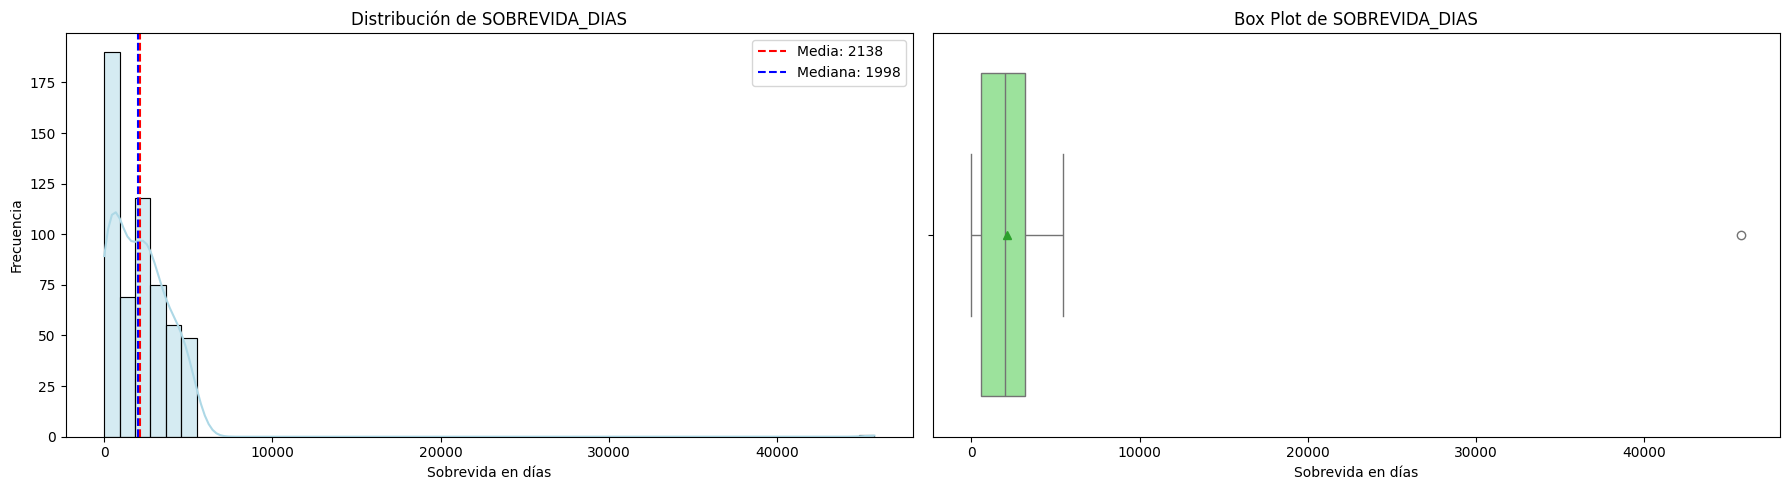

In [2383]:
graficar_var_numerica(df_clean, "SOBREVIDA_DIAS", "Sobrevida en días")

#### ``SOBREVIDA_MESES``

Sobrevida en meses post trasplante

In [2384]:
df["SOBREVIDA_MESES"].value_counts(dropna=False).sort_index()

SOBREVIDA_MESES
0.00       10
0.03        7
0.07        2
0.10        2
0.13        1
           ..
179.27      1
180.57      1
181.40      1
181.47      1
1503.00     1
Name: count, Length: 472, dtype: int64

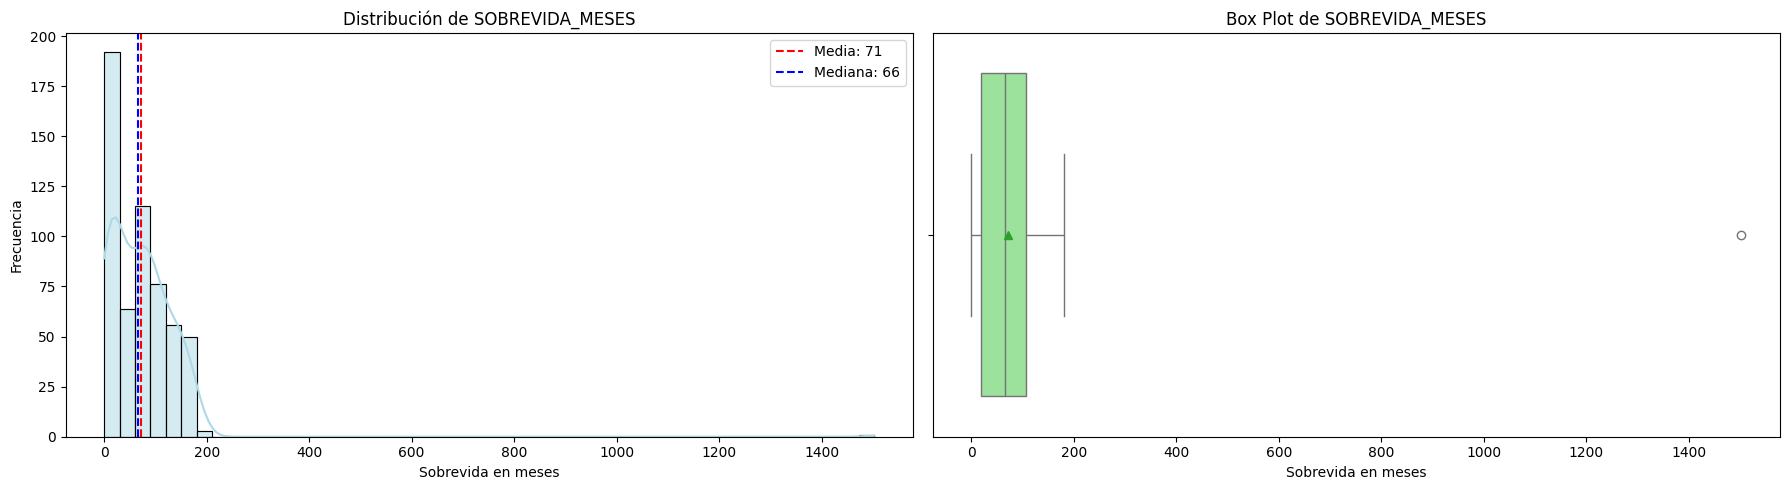

In [2385]:
graficar_var_numerica(df_clean, "SOBREVIDA_MESES", "Sobrevida en meses")

#### ``SOBREVIDA_AÑOS``

Sobrevida en años post trasplante

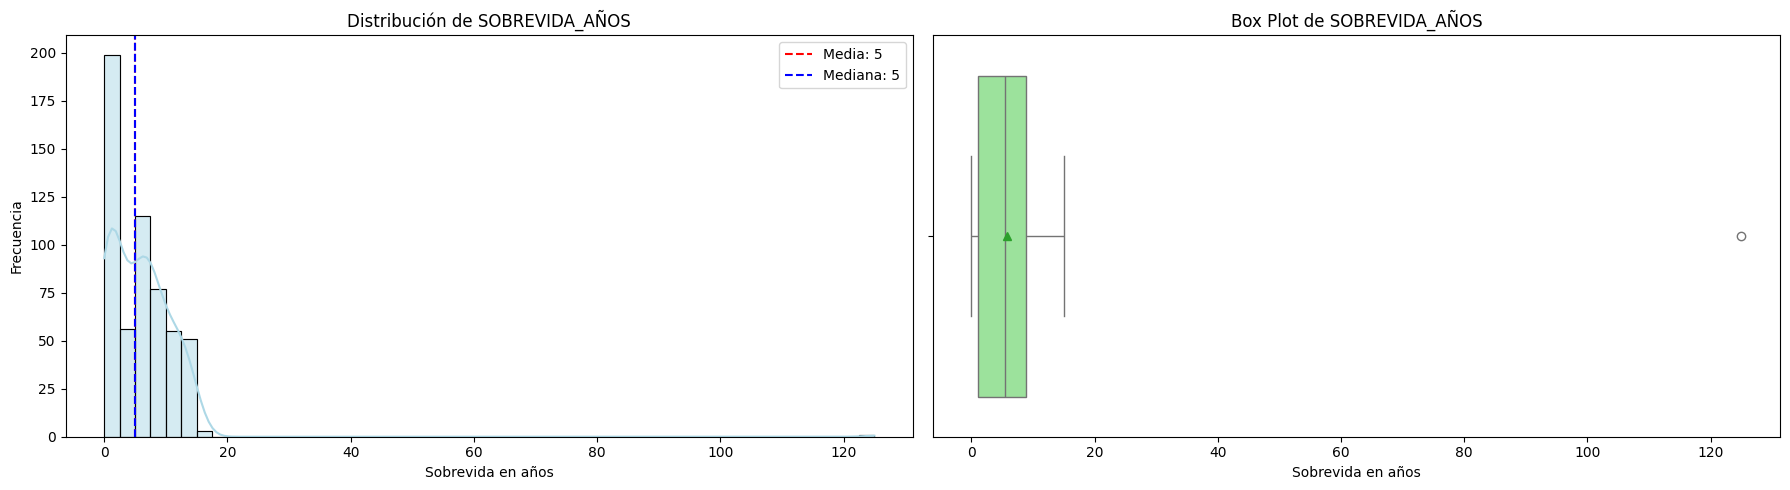

In [2386]:
graficar_var_numerica(df_clean, "SOBREVIDA_AÑOS", "Sobrevida en años")

#### ``Dias_Estancia_Hospitalaria``

Días totales de hospitalización

In [2387]:
df["Dias_Estancia_Hospitalaria"].value_counts(dropna=False).sort_index()

Dias_Estancia_Hospitalaria
0.00      83
0.48       1
0.57       1
0.81       1
1.28       1
          ..
91.34      1
92.49      1
93.90      1
101.20     1
106.50     1
Name: count, Length: 421, dtype: int64

In [2388]:
s = pd.to_numeric(df["Dias_Estancia_Hospitalaria"], errors="coerce")
s = np.ceil(s).astype("Int32")                                 
df_clean.drop(columns=["Dias_Estancia_Hospitalaria"], inplace=True, errors='ignore')
df_clean.loc[:, "Dias_Estancia_Hospitalaria"] = s


In [2389]:
df_clean["Dias_Estancia_Hospitalaria"].value_counts(dropna=False).sort_index()

Dias_Estancia_Hospitalaria
0      83
1       3
2       4
3       4
4       7
       ..
92      1
93      1
94      1
102     1
107     1
Name: count, Length: 63, dtype: Int64

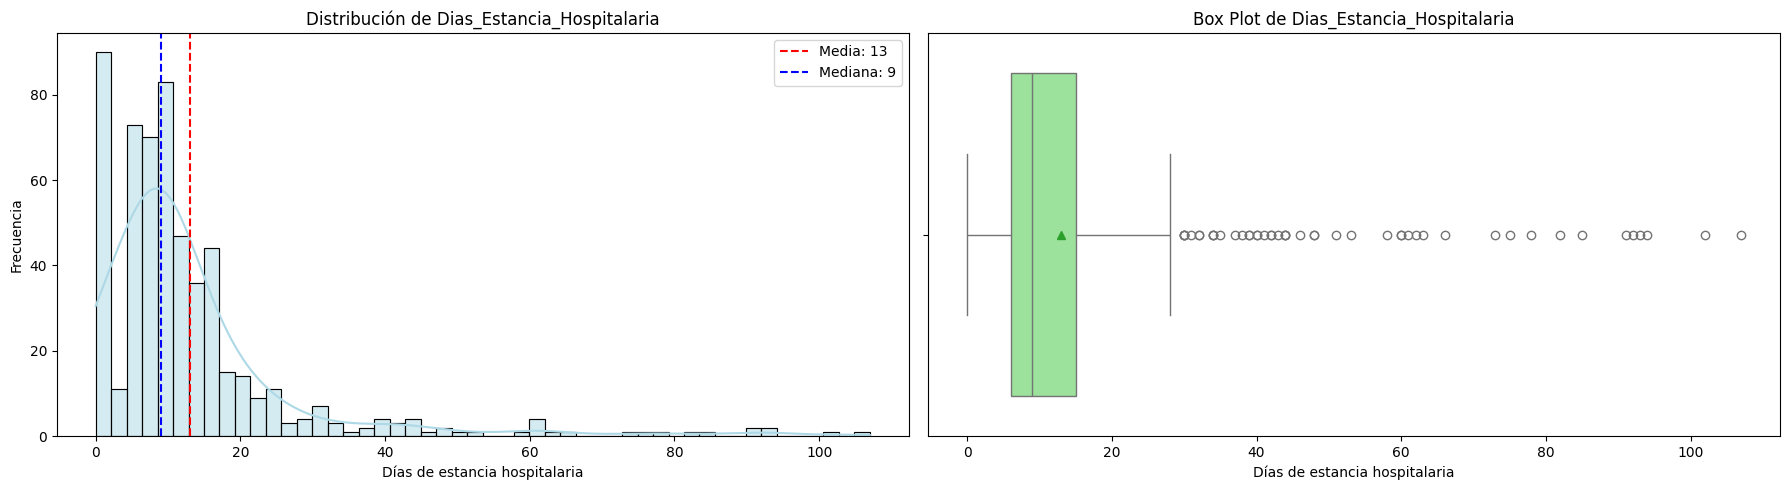

In [2390]:
graficar_var_numerica(df_clean, "Dias_Estancia_Hospitalaria", "Días de estancia hospitalaria")

#### ``Días_Hospitalización_UCI``

Días totales de hospitalización en UCI

In [2391]:
def IQR_filter(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return series.where((series >= lower_bound) & (series <= upper_bound))

In [2392]:
col = "Días_Hospitalización_UCI"
df[col].value_counts(dropna=False).sort_index()

Días_Hospitalización_UCI
0.000        392
0.551          1
0.706          1
0.726          1
0.764          1
            ... 
25132.000      1
32591.000      1
38568.000      1
68499.000      1
78374.000      1
Name: count, Length: 158, dtype: int64

In [2393]:
#Convertir a int
s = pd.to_numeric(df["Días_Hospitalización_UCI"], errors="coerce")
s = np.ceil(s).mask(s > 365*20, np.nan).astype("Int32")
df_clean.loc[:, "Días_Hospitalización_UCI"] = s
df_clean["Días_Hospitalización_UCI"].value_counts(dropna = False).sort_index()

C:\Users\esteb\AppData\Local\Temp\ipykernel_27020\453551906.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 ...
    0,    0,    0,    0, 5417,    0,    0,    0,    0,    0]
Length: 557, dtype: Int32' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_clean.loc[:, "Días_Hospitalización_UCI"] = s


Días_Hospitalización_UCI
0       392
1        14
2         9
3         2
4         2
       ... 
6261      1
6678      1
6694      1
7226      1
<NA>     19
Name: count, Length: 118, dtype: Int64

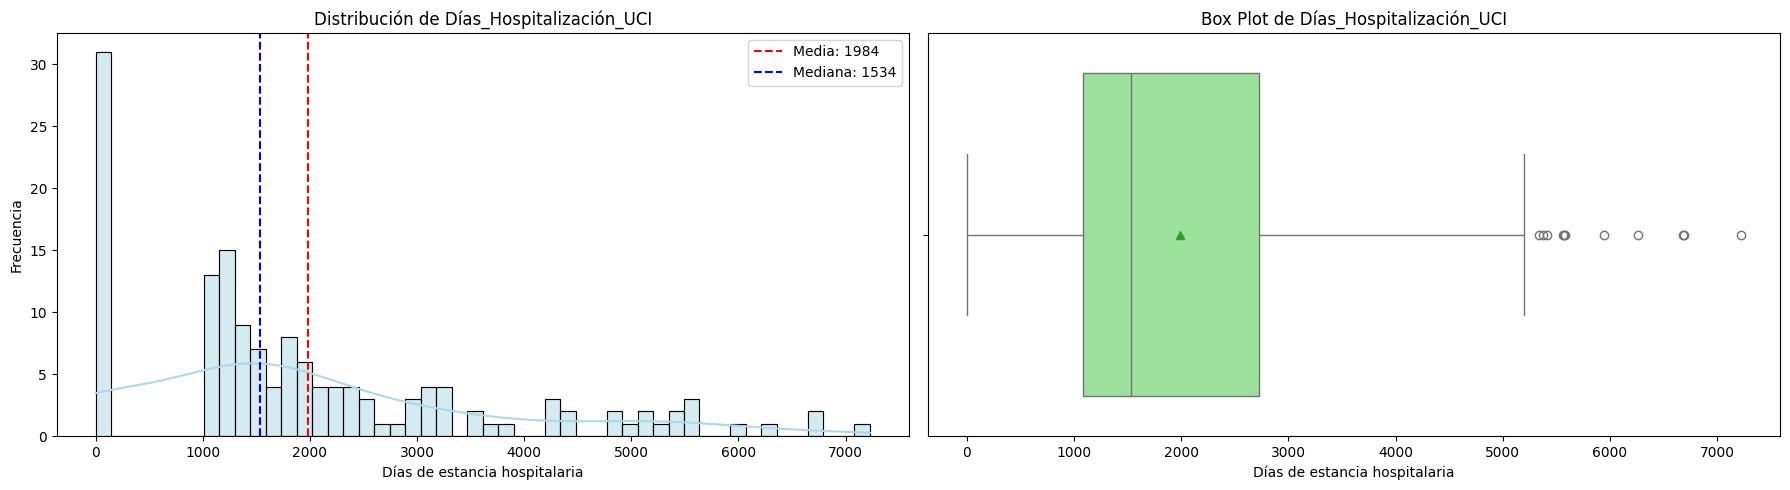

In [2394]:
graficar_var_numerica(df_clean[df_clean[col] > 0], "Días_Hospitalización_UCI", "Días de estancia hospitalaria")

# **4. Guardar versión limpia**

In [2395]:
orden = ["Código anonimizado", "#Paciente_Tx",	"Año_Tx",	"Fecha_Tx",	"Etiología_#1",	"Etiología_#2",	"Edad",	"Sexo",	
         "Child_Pugh_Score_Cat", "Child_Pugh_Score",	"Meld_Score","Diabetes_Mellitus","Tabaquismo","Alcoholismo",
        "Hipertensión_Arterial", "Peso_previo_Cx",	"Talla",	"IMC",	"Antecedente_UCI_6_meses_PreOP", "UCI_al_Momento_Tx",	
        "Tiempo_Isquemia_Fria",	"Tiempo_Isquemia_caliente",	"Tiempo_Cx", "Tipo_Reconstrucción_Biliar",	
        "Infección_Al_Momento_Tx",	"Localización de la infección",	"Germen/Microorganismo aislado",	
        "Antibiotico_previo_al_Tx",	"Días_Tratamiento_Antibiótico_Previo_A_Tx#1",	
        "Antibiótico_Profiláctico_VS_Terapéutico",	"Antibiótico_1__Tx#1",	"Antibiótico_2_Tx#1",	
        "Antibiótico_3_Tx#1", "Antifúngico_Tx#1",	"Tiempo_De_Dosis_Hasta_Tx#1",	
        "Nutrición_Enteral","Días_Nutrición_Enteral",	"Complicaciones_Técnicas",	"Dias_Estancia_Hospitalaria",	
        "Días_Hospitalización_UCI",	"Días_En_Hospitalización_Piso",	"Días_Totales_Intrahospitalarios",	
        "Inmunosupresión_con_Anticuerpos",	"Inmunosupresor_1_Postx",	"Inmunosupresor_2_PostTx",	
        "Inmunosupresor_1_1mesPostTx",	"Inmunosupresor_2_PostTx_1mesPx",	"Inmunosupresor_1_6mesesPostx",	
        "Inmunosupresor_2_6mesesPostTx", "Fecha_Egreso_UCI",	"Fecha_Egreso_Hospitalario",	
        "Requerimiento_de_diálisis", "Días_En_UCI_POP",	"Trasfusión_GRE_hasta_1m_POP",	
        "Reintervención_Quirúrgica_hasta_1m_POP",	"Retrasplante",	
        "Vivo_Hoy",	"Fecha_Control/Muerte",	"SOBREVIDA_DIAS",	"SOBREVIDA_MESES",	"SOBREVIDA_AÑOS"]

In [2396]:
df_clean = df_clean[orden]

In [2398]:
df_clean.to_csv(CLEAN_DB, index=False)

In [2399]:
df_clean.to_excel(CLEAN_DB_XLSX, index=False, engine='openpyxl')

In [2408]:
df_clean.dtypes.value_counts().sort_values(ascending=False)

Int64             20
int64             14
Int16              9
float64            8
datetime64[ns]     4
Int32              4
category           1
object             1
Name: count, dtype: int64

In [2401]:
df_clean.isna().sum().sort_values(ascending=False)

Germen/Microorganismo aislado    479
Localización de la infección     433
Fecha_Egreso_UCI                 429
Child_Pugh_Score                 405
Child_Pugh_Score_Cat             399
                                ... 
Vivo_Hoy                           0
Fecha_Control/Muerte               0
SOBREVIDA_DIAS                     0
SOBREVIDA_MESES                    0
SOBREVIDA_AÑOS                     0
Length: 61, dtype: int64

In [2402]:
demograficas = ['#Paciente_Tx', 'Edad', 'Sexo', "Fecha_Tx", 'Etiología_#1', 'Etiología_#2', 'Meld_Score', 'Diabetes_Mellitus', 'Tabaquismo', 'Alcoholismo', 'IMC', "Peso_previo_Cx"]
otras = ["Tipo_Reconstrucción_Biliar", "Dias_Estancia_Hospitalaria", "Retrasplante"]
infeccion = ['Infección_Al_Momento_Tx', "Antibiótico_Profiláctico_VS_Terapéutico", "Antibiotico_previo_al_Tx"]
columnas_de_interes = demograficas + infeccion + otras

# Filtrar columnas con menos de 130 valores nulos
columnas_de_interes = df_clean.columns[df_clean.isna().sum() < 130]


In [2403]:
df_temp = df_clean.dropna(subset = columnas_de_interes)
df_temp[columnas_de_interes]

,Código anonimizado,#Paciente_Tx,Año_Tx,Fecha_Tx,Etiología_#1,Etiología_#2,Edad,Sexo,Meld_Score,Diabetes_Mellitus,...,Requerimiento_de_diálisis,Días_En_UCI_POP,Trasfusión_GRE_hasta_1m_POP,Reintervención_Quirúrgica_hasta_1m_POP,Retrasplante,Vivo_Hoy,Fecha_Control/Muerte,SOBREVIDA_DIAS,SOBREVIDA_MESES,SOBREVIDA_AÑOS
8,P009,9,2009,2009-03-08,10,0,66,2,16,0,...,0,5,0,1.0,0,0,2016-12-25,2849,94.97,7.91
15,P016,16,2009,2009-04-29,10,0,51,1,22,1,...,0,3,0,1.0,0,0,2014-08-10,1929,64.30,5.36
18,P019,19,2009,2009-06-04,3,0,72,1,14,0,...,0,1,0,1.0,0,1,2023-12-31,5323,177.43,14.79
19,P020,20,2009,2009-06-10,1,0,57,2,13,0,...,0,4,0,0.0,0,0,2010-02-18,253,8.43,0.70
20,P021,21,2009,2009-06-23,4,0,54,1,22,1,...,0,5,0,0.0,0,0,2010-04-09,290,9.67,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,P465,465,2021,2021-12-14,11,0,68,2,15,1,...,0,3,0,0.0,0,1,2023-12-31,747,24.90,2.08
467,P468,468,2022,2022-02-06,9,0,68,2,25,0,...,0,4,0,1.0,0,1,2025-02-06,1094,35.00,2.00
469,P470,470,2022,2022-03-10,8,0,52,1,22,0,...,0,1,0,0.0,0,1,2023-06-16,457,15.00,1.00
471,P472,472,2022,2022-03-28,11,0,57,2,28,1,...,0,0,0,1.0,0,1,2023-11-16,588,19.00,1.00


## Análisis multivariado

In [2404]:
def calculate_and_plot_correlation_matrix(df_num, method='pearson', mask = False):
    correlation_matrix = df_num.corr(method=method)

    # Crear máscara para ocultar la parte inferior
    mask = None if not mask else np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Heatmap solo parte superior
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'label': 'Coeficiente de Correlación'})
    plt.title(f'Matriz de Correlación ({method.capitalize()})')
    plt.tight_layout()
    plt.show()
    return correlation_matrix

In [2405]:
df_num = df_clean[["Alcoholismo", "Talla", "IMC", "Peso_previo_Cx", "Diabetes_Mellitus", "Tabaquismo", "Hipertensión_Arterial"]].copy()

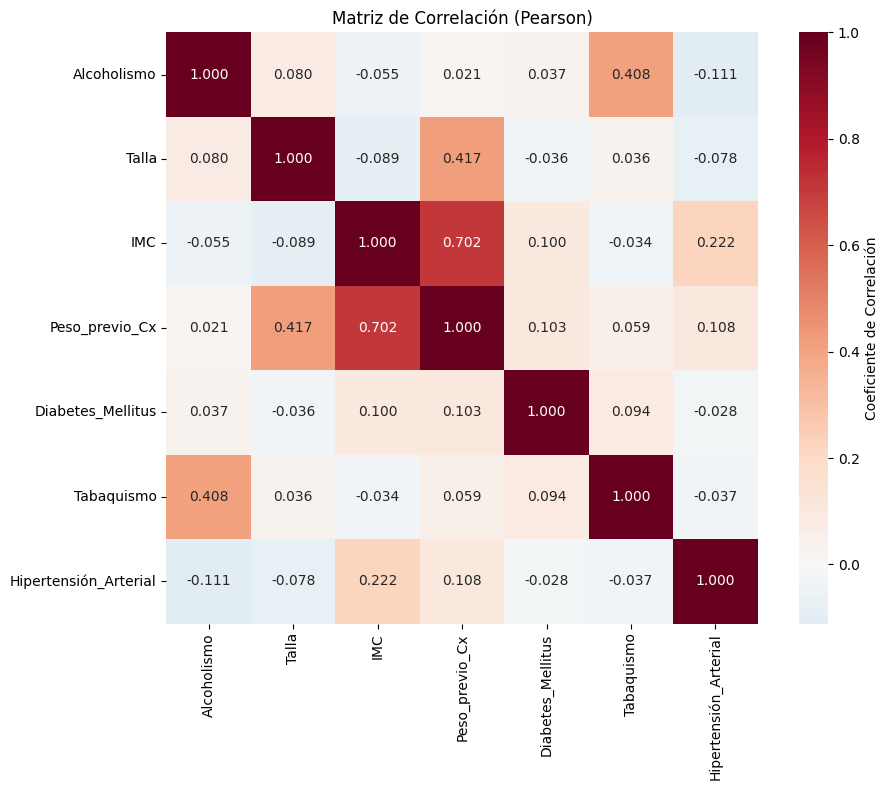

,Alcoholismo,Talla,IMC,Peso_previo_Cx,Diabetes_Mellitus,Tabaquismo,Hipertensión_Arterial
Alcoholismo,1.000000,0.079996,-0.054754,0.021380,0.036883,0.407852,-0.111083
Talla,0.079996,1.000000,-0.088723,0.416549,-0.035615,0.035877,-0.078131
IMC,-0.054754,-0.088723,1.000000,0.701771,0.099969,-0.034091,0.221811
Peso_previo_Cx,0.021380,0.416549,0.701771,1.000000,0.102540,0.058804,0.108116
Diabetes_Mellitus,0.036883,-0.035615,0.099969,0.102540,1.000000,0.094304,-0.028316
Tabaquismo,0.407852,0.035877,-0.034091,0.058804,0.094304,1.000000,-0.037259
Hipertensión_Arterial,-0.111083,-0.078131,0.221811,0.108116,-0.028316,-0.037259,1.000000


In [2406]:
calculate_and_plot_correlation_matrix(df_num)